# LSTM-Based Slow-Rate SSH Attack Detection Research

In [1]:
import pandas as pd
import numpy as np
import cupy as cp
import json
import re
import pickle
import os
import glob
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

mempool = cp.get_default_memory_pool()
mempool.set_limit(size=4**30)

print("GPU Memory Available:", cp.cuda.runtime.memGetInfo()[0] / 1024**3, "GB")
print("CuPy Version:", cp.__version__)

GPU Memory Available: 9.9619140625 GB
CuPy Version: 13.6.0


## 1 Data Loading and Parsing

In [2]:
def parse_proxmox_logs_optimized(file_path):
    """Optimized Proxmox SSH log parsing with GPU acceleration"""
    log_entries = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            # Extract timestamp
            timestamp_match = re.match(r'(\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})', line)
            if not timestamp_match:
                continue
                
            timestamp_str = timestamp_match.group(1)
            
            # Extract IP addresses
            ip_pattern = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'
            ip_matches = re.findall(ip_pattern, line)
            
            log_type = 'unknown'
            if 'Accepted password' in line:
                log_type = 'successful_auth'
            elif 'Failed password' in line:
                log_type = 'failed_auth'
            elif 'Connection closed' in line and '[preauth]' in line:
                log_type = 'connection_closed'
            elif 'Invalid user' in line:
                log_type = 'invalid_user'
            elif 'authentication failure' in line:
                log_type = 'auth_failure'
                
            entry = {
                'timestamp': timestamp_str,
                'raw_line': line,
                'log_type': log_type,
                'source_ips': ip_matches,
                'source_ip': ip_matches[0] if ip_matches else None
            }
            
            log_entries.append(entry)
    
    return pd.DataFrame(log_entries)

# Load Proxmox data
proxmox_files = [
    'proxmox_logs/january_2025_ssh_logs.txt',
    'proxmox_logs/february_2025_ssh_logs.txt',
    'proxmox_logs/march_2025_ssh_logs.txt'
]

proxmox_data = []
for file_path in proxmox_files:
    df = parse_proxmox_logs_optimized(file_path)
    df['file_source'] = file_path
    proxmox_data.append(df)
    print(f"Loaded {len(df)} entries from {file_path}")

proxmox_df = pd.concat(proxmox_data, ignore_index=True)
print(f"Total Proxmox entries: {len(proxmox_df)}")
print(f"Memory usage: {proxmox_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loaded 1007435 entries from proxmox_logs/january_2025_ssh_logs.txt
Loaded 2350644 entries from proxmox_logs/february_2025_ssh_logs.txt
Loaded 2573433 entries from proxmox_logs/march_2025_ssh_logs.txt
Total Proxmox entries: 5931512
Memory usage: 3014.4 MB


In [3]:
def load_pwnjutsu_data_optimized():    
    # Load SSH network logs
    ssh_data = []
    ssh_files = glob.glob("pwnjutsu_dataset/network_json/**/player_*_*.pcap_ssh.log", recursive=True)
    
    for file_path in ssh_files:
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            entry = json.loads(line.strip())
                            entry['file_source'] = file_path
                            ssh_data.append(entry)
                        except json.JSONDecodeError:
                            continue
        except Exception:
            continue
    
    # Load system logs
    system_data = []
    system_files = glob.glob("pwnjutsu_dataset/system_json/pwnjutsu_dataset-system-json-*.json")
    
    for file_path in system_files:
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            entry = json.loads(line.strip())
                            entry['file_source'] = file_path
                            system_data.append(entry)
                        except json.JSONDecodeError:
                            continue
        except Exception:
            continue
    
    pwnjutsu_ssh_df = pd.DataFrame(ssh_data)
    pwnjutsu_system_df = pd.DataFrame(system_data)
    
    return pwnjutsu_ssh_df, pwnjutsu_system_df

# Load PWNJUTSU data
pwnjutsu_ssh_df, pwnjutsu_system_df = load_pwnjutsu_data_optimized()

print(f"PWNJUTSU SSH entries: {len(pwnjutsu_ssh_df)}")
print(f"PWNJUTSU System entries: {len(pwnjutsu_system_df)}")

if len(pwnjutsu_ssh_df) > 0:
    print(f"SSH date range: {pd.to_datetime(pwnjutsu_ssh_df['ts'], unit='s').min()} to {pd.to_datetime(pwnjutsu_ssh_df['ts'], unit='s').max()}")

# Filter SSH-related system logs
if len(pwnjutsu_system_df) > 0:
    ssh_system_entries = len(pwnjutsu_system_df[pwnjutsu_system_df['raw'].str.contains('ssh', case=False, na=False)])
    print(f"SSH-related system entries: {ssh_system_entries}")

PWNJUTSU SSH entries: 4542
PWNJUTSU System entries: 16467074
SSH date range: 2021-05-09 10:22:54.549381971 to 2021-06-20 15:53:50.574860096
SSH-related system entries: 4144050


In [4]:
def parse_loghub_openssh_two_year(file_path, start_year=2024):
    """
    Parse Loghub OpenSSH syslog and assign dates across exactly TWO years:
    start_year (e.g., 2024) and start_year+1 (e.g., 2025).

    We scan lines in file order, and when month/day goes backward (Dec -> Jan),
    we increment the synthetic year ONCE. Any further wraps are ignored.
    """
    import os, re
    import pandas as pd

    if not os.path.exists(file_path):
        print(f"[WARN] Loghub file not found: {file_path}")
        return pd.DataFrame(columns=[
            'timestamp','datetime','raw_line','log_type','source_ips','source_ip',
            'host','pid','dataset','line_no'
        ])

    ts_re   = re.compile(r'^(\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2})')   # e.g., "Dec 10 06:55:46"
    host_re = re.compile(r'^\w{3}\s+\d{1,2}\s+\d{2}:\d{2}:\d{2}\s+(\S+)')
    pid_re  = re.compile(r'sshd\[(\d+)\]')
    ip_re   = re.compile(r'(\d{1,3}(?:\.\d{1,3}){3})')

    def detect_log_type(line: str) -> str:
        if 'Accepted password' in line: return 'successful_auth'
        if 'Failed password' in line:  return 'failed_auth'
        if 'Invalid user' in line:     return 'invalid_user'
        if 'Connection closed by' in line or 'Received disconnect from' in line:
            return 'connection_closed'
        if 'authentication failure' in line: return 'auth_failure'
        if 'reverse mapping checking' in line or 'POSSIBLE BREAK-IN ATTEMPT' in line:
            return 'unknown'
        return 'unknown'

    rows = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, raw in enumerate(f):
            line = raw.strip()
            if not line:
                continue
            m_ts = ts_re.match(line)
            if not m_ts:
                continue
            ts = m_ts.group(1)   # "Dec 10 06:55:46"

            m_host = host_re.match(line)
            host = m_host.group(1) if m_host else None

            m_pid = pid_re.search(line)
            pid = m_pid.group(1) if m_pid else None

            ips = ip_re.findall(line)
            first_ip = ips[0] if ips else None

            rows.append({
                'line_no': i,
                'timestamp': ts,
                'raw_line': line,
                'log_type': detect_log_type(line),
                'source_ips': ips,
                'source_ip': first_ip,
                'host': host,
                'pid': pid,
                'dataset': 'loghub'
            })

    df = pd.DataFrame(rows)
    if df.empty:
        df['datetime'] = pd.to_datetime([])
        return df

    # ---- Two-year assignment (Dec -> Jan rollover once) ----
    MONTH2IDX = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
                 'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

    df = df.sort_values('line_no').reset_index(drop=True)

    # Extract month/day/time strings
    months = df['timestamp'].str.extract(r'^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)')[0]
    days   = df['timestamp'].str.extract(r'^\w+\s+(\d{1,2})')[0].astype(int)
    times  = df['timestamp'].str.extract(r'(\d{2}:\d{2}:\d{2})$')[0]

    curr_year = start_year
    rolled_once = False
    last_m, last_d = None, None
    dts = []

    for m_str, d, t in zip(months, days, times):
        m = MONTH2IDX.get(m_str, None)
        if m is None or pd.isna(d) or pd.isna(t):
            dts.append(pd.NaT)
            continue

        # Detect a backward wrap (e.g., Dec -> Jan or 31 -> 1 inside same month)
        if last_m is not None and not rolled_once:
            if (m < last_m) or (m == last_m and d < last_d):
                curr_year = min(start_year + 1, curr_year + 1)  # only up to +1 year
                rolled_once = True

        # Build datetime with fixed two-year ceiling
        if curr_year > start_year + 1:
            curr_year = start_year + 1

        dts.append(pd.to_datetime(f"{curr_year}-{m:02d}-{int(d):02d} {t}", errors='coerce'))
        last_m, last_d = m, d

    df['datetime'] = pd.to_datetime(dts)
    return df

# ---- Use it ----
loghub_path = r'loghub/SSH.log'
loghub_df = parse_loghub_openssh_two_year(loghub_path, start_year=2024)

print(f"Loghub entries: {len(loghub_df)}")
if len(loghub_df) > 0:
    print(f"Datetime range: {loghub_df['datetime'].min()}  →  {loghub_df['datetime'].max()}")
    span_days = (loghub_df['datetime'].max() - loghub_df['datetime'].min()).days + 1
    print(f"Approx span (days): {span_days}")
    print("Log type distribution:")
    print(loghub_df['log_type'].value_counts(dropna=False))


Loghub entries: 655147
Datetime range: 2024-12-10 06:55:46  →  2025-01-07 17:22:01
Approx span (days): 29
Log type distribution:
log_type
auth_failure         230673
failed_auth          197587
connection_closed    117663
unknown               94448
invalid_user          14594
successful_auth         182
Name: count, dtype: int64


## 2 Attack Detection

In [5]:
def analyze_proxmox_gpu(df):
    """Optimized Proxmox behavioral analysis with corrected attack classification."""
    # Preprocessing - vectorized operations
    df['datetime'] = pd.to_datetime('2025 ' + df['timestamp'], format='%Y %b %d %H:%M:%S', errors='coerce')
    df = df.dropna(subset=['datetime', 'source_ip'])
    
    # Vectorized success/failure classification
    df['is_success'] = df['log_type'].isin(['successful_auth']).astype(int)
    df['is_failure'] = df['log_type'].isin(['failed_auth', 'invalid_user', 'auth_failure']).astype(int)
    
    # Vectorized per-IP metrics computation
    ip_stats = df.groupby('source_ip').agg({
        'datetime': ['min', 'max', 'count'],
        'is_success': 'sum',
        'is_failure': 'sum'
    }).round(3)
    
    # Flatten column names
    ip_stats.columns = ['first_attempt', 'last_attempt', 'total_attempts', 'success_count', 'failed_count']
    
    # Vectorized derived metrics
    ip_stats['span_hours'] = (ip_stats['last_attempt'] - ip_stats['first_attempt']).dt.total_seconds() / 3600
    ip_stats['attempts_per_hour'] = ip_stats['total_attempts'] / ip_stats['span_hours'].clip(lower=1)
    ip_stats['success_rate'] = ip_stats['success_count'] / ip_stats['total_attempts']
    
    # Work hours analysis (vectorized)
    df['is_work_hours'] = (df['datetime'].dt.hour.between(9, 17)) & (df['datetime'].dt.weekday < 5)
    work_hours_stats = df.groupby('source_ip')['is_work_hours'].mean()
    ip_stats['work_hours_ratio'] = work_hours_stats
    
    # CORRECTED Classification Logic
    benign_ips = set()
    fast_attack_ips = set()
    slow_attack_ips = set()
    
    for ip, stats in ip_stats.iterrows():
        total_attempts = stats['total_attempts']
        success_rate = stats['success_rate']
        span_hours = stats['span_hours']
        attempts_per_hour = stats['attempts_per_hour']
        work_hours_ratio = stats['work_hours_ratio']
        failed_count = stats['failed_count']
        
        # Early exit for obvious cases
        if total_attempts == 1:
            benign_ips.add(ip)
            continue
            
        # High success rate = benign
        if success_rate >= 0.3:
            benign_ips.add(ip)
            continue
            
        # Some success + reasonable behavior = benign
        if success_rate > 0 and total_attempts <= 20 and span_hours <= 24:
            benign_ips.add(ip)
            continue
            
        # Work hours + low attempts = likely benign
        if work_hours_ratio >= 0.6 and total_attempts <= 10:
            benign_ips.add(ip)
            continue
            
        # Attack classification (only for 0% success rate and sufficient attempts)
        if success_rate == 0 and total_attempts >= 5:
            # CORRECTED LOGIC: Rate-based classification only
            if attempts_per_hour >= 50:
                # High rate = Fast Attack (regardless of duration)
                fast_attack_ips.add(ip)
            elif attempts_per_hour <= 10:
                # True slow rate = Slow Attack
                slow_attack_ips.add(ip)
            else:
                # Medium rate (10-50/hour) = Fast Attack (sustained but still fast)
                fast_attack_ips.add(ip)
        
        # Remaining cases with some success = benign
        elif success_rate > 0:
            benign_ips.add(ip)
    
    return benign_ips, fast_attack_ips, slow_attack_ips


def analyze_pwnjutsu_gpu(ssh_df):
    """Optimized PWNJUTSU behavioral analysis with corrected attack classification."""
    if len(ssh_df) == 0:
        return set(), set(), set()
    
    ssh_df['datetime'] = pd.to_datetime(ssh_df['ts'], unit='s', errors='coerce')
    ssh_df = ssh_df.dropna(subset=['datetime'])
    ssh_df['source_ip'] = ssh_df['id.orig_h']
    
    # Handle NaN values in success detection
    if 'auth_success' in ssh_df.columns:
        ssh_df['is_success'] = ssh_df['auth_success'].fillna(0).astype(int)
    else:
        ssh_df['is_success'] = (ssh_df.get('resp_bytes', 0).fillna(0) > 0).astype(int)
    
    # Vectorized per-IP stats
    ip_stats = ssh_df.groupby('source_ip').agg({
        'datetime': ['min', 'max', 'count'],
        'is_success': 'sum'
    })
    
    ip_stats.columns = ['first_attempt', 'last_attempt', 'total_attempts', 'success_count']
    ip_stats['span_hours'] = (ip_stats['last_attempt'] - ip_stats['first_attempt']).dt.total_seconds() / 3600
    ip_stats['attempts_per_hour'] = ip_stats['total_attempts'] / ip_stats['span_hours'].clip(lower=1)
    ip_stats['success_rate'] = ip_stats['success_count'] / ip_stats['total_attempts']
    
    # Work hours
    ssh_df['is_work_hours'] = (ssh_df['datetime'].dt.hour.between(9, 17)) & (ssh_df['datetime'].dt.weekday < 5)
    work_hours_stats = ssh_df.groupby('source_ip')['is_work_hours'].mean()
    ip_stats['work_hours_ratio'] = work_hours_stats
    
    # CORRECTED Classification Logic
    benign_ips = set()
    fast_attack_ips = set()
    slow_attack_ips = set()
    
    for ip, stats in ip_stats.iterrows():
        success_rate = stats['success_rate']
        total_attempts = stats['total_attempts']
        span_hours = stats['span_hours']
        attempts_per_hour = stats['attempts_per_hour']
        work_hours_ratio = stats['work_hours_ratio']
        
        # Benign classification
        if success_rate >= 0.2 or (work_hours_ratio >= 0.6 and total_attempts <= 10):
            benign_ips.add(ip)
        # Attack classification (0% success rate)
        elif success_rate == 0 and total_attempts >= 5:
            # CORRECTED: Rate-based only
            if attempts_per_hour >= 50:
                fast_attack_ips.add(ip)
            elif attempts_per_hour <= 10:
                slow_attack_ips.add(ip)
            else:
                # Medium rate = Fast
                fast_attack_ips.add(ip)
        # Has some success = benign
        elif success_rate > 0:
            benign_ips.add(ip)
    
    return benign_ips, fast_attack_ips, slow_attack_ips


def analyze_loghub_gpu(df):
    """Optimized LogHub behavioral analysis."""
    if df is None or len(df) == 0:
        return set(), set(), set()
    
    # Ensure datetime exists
    if 'datetime' not in df.columns:
        if 'timestamp' in df.columns:
            df['datetime'] = pd.to_datetime('2025 ' + df['timestamp'], format='%Y %b %d %H:%M:%S', errors='coerce')
        else:
            df['datetime'] = pd.to_datetime(df.get('datetime', pd.NaT), errors='coerce')
    
    df = df.dropna(subset=['datetime', 'source_ip'])
    
    # Use same corrected analysis logic as Proxmox
    return analyze_proxmox_gpu(df)


# Run behavioral analysis with corrected classification
print("Running behavioral analysis with CORRECTED attack classification...")
print("NEW LOGIC:")
print("  Fast Attack: ≥50 attempts/hour OR 10-50 attempts/hour (any duration)")
print("  Slow Attack: ≤10 attempts/hour (true slow rate)")
print("  Benign: Success rate ≥30% OR reasonable patterns")

proxmox_benign_ips, proxmox_fast_ips, proxmox_slow_ips = analyze_proxmox_gpu(proxmox_df.copy())

print(f"\nProxmox Results:")
print(f"  Benign IPs: {len(proxmox_benign_ips)}")
print(f"  Fast Attack IPs: {len(proxmox_fast_ips)}")
print(f"  Slow Rate Attack IPs: {len(proxmox_slow_ips)}")

pwnjutsu_benign_ips, pwnjutsu_fast_ips, pwnjutsu_slow_ips = analyze_pwnjutsu_gpu(pwnjutsu_ssh_df.copy())

print(f"\nPWNJUTSU Results:")
print(f"  Benign IPs: {len(pwnjutsu_benign_ips)}")
print(f"  Fast Attack IPs: {len(pwnjutsu_fast_ips)}")
print(f"  Slow Rate Attack IPs: {len(pwnjutsu_slow_ips)}")

loghub_benign_ips, loghub_fast_ips, loghub_slow_ips = analyze_loghub_gpu(loghub_df.copy())

print(f"\nLogHub Results:")
print(f"  Benign IPs: {len(loghub_benign_ips)}")
print(f"  Fast Attack IPs: {len(loghub_fast_ips)}")
print(f"  Slow Rate Attack IPs: {len(loghub_slow_ips)}")

Running behavioral analysis with CORRECTED attack classification...
NEW LOGIC:
  Fast Attack: ≥50 attempts/hour OR 10-50 attempts/hour (any duration)
  Slow Attack: ≤10 attempts/hour (true slow rate)
  Benign: Success rate ≥30% OR reasonable patterns

Proxmox Results:
  Benign IPs: 1091
  Fast Attack IPs: 1623
  Slow Rate Attack IPs: 1535

PWNJUTSU Results:
  Benign IPs: 57
  Fast Attack IPs: 3
  Slow Rate Attack IPs: 3

LogHub Results:
  Benign IPs: 340
  Fast Attack IPs: 215
  Slow Rate Attack IPs: 444


## 3 Data Labeling

In [6]:
from tqdm import tqdm
import pandas as pd
import numpy as np

def create_enhanced_labels_gpu(df, benign_ips, fast_attack_ips, slow_attack_ips, dataset_name):
    """Create traffic labels with confidence scoring and multi-stage classification."""
    if df is None or len(df) == 0:
        return df

    df = df.copy()
    
    # Ensure source_ip exists
    if 'source_ip' not in df.columns:
        if dataset_name == 'pwnjutsu' and 'id.orig_h' in df.columns:
            df['source_ip'] = df['id.orig_h']
        else:
            df['source_ip'] = None

    # Initialize with unknown
    df['traffic_label'] = 'unknown'
    df['dataset'] = dataset_name
    df['label_confidence'] = 'low'

    # Apply high-confidence labels (vectorized) - THESE ARE FINAL, NO OVERRIDE
    df.loc[df['source_ip'].isin(benign_ips), 'traffic_label'] = 'benign'
    df.loc[df['source_ip'].isin(benign_ips), 'label_confidence'] = 'high'
    
    df.loc[df['source_ip'].isin(fast_attack_ips), 'traffic_label'] = 'fast_attack'
    df.loc[df['source_ip'].isin(fast_attack_ips), 'label_confidence'] = 'high'
    
    df.loc[df['source_ip'].isin(slow_attack_ips), 'traffic_label'] = 'slow_rate_attack'
    df.loc[df['source_ip'].isin(slow_attack_ips), 'label_confidence'] = 'high'
    
    return df


def vectorized_unknown_analysis(df, dataset_name):
    """Vectorized analysis of ONLY truly unknown IPs - NO OVERRIDE of Cell 7 decisions."""
    if df is None or len(df) == 0:
        return df
    
    # Get only unknown entries for processing
    unknown_mask = df['traffic_label'] == 'unknown'
    if not unknown_mask.any():
        return df
    
    print(f"\n{dataset_name}: Processing truly unknown IPs (no override of rate-based decisions)...")
    
    # Vectorized IP statistics computation
    print("  Computing IP statistics...")
    ip_stats = df.groupby('source_ip').agg({
        'traffic_label': 'count'  # Total attempts per IP
    }).rename(columns={'traffic_label': 'total_attempts'})
    
    # Vectorized success detection (if log_type exists)
    if 'log_type' in df.columns:
        success_mask = df['log_type'].isin(['successful_auth', 'accepted'])
        success_counts = df[success_mask].groupby('source_ip').size()
        ip_stats['success_count'] = success_counts.reindex(ip_stats.index, fill_value=0)
    else:
        ip_stats['success_count'] = 0
    
    # Filter to only unknown IPs
    unknown_ips = df[unknown_mask]['source_ip'].unique()
    unknown_ip_stats = ip_stats.loc[ip_stats.index.isin(unknown_ips)]
    
    print(f"  Processing {len(unknown_ip_stats):,} truly unknown IPs...")
    
    # Conservative classification for ambiguous cases only
    single_attempt = unknown_ip_stats['total_attempts'] == 1
    few_attempts = (unknown_ip_stats['total_attempts'] >= 2) & (unknown_ip_stats['total_attempts'] <= 4)
    has_success = unknown_ip_stats['success_count'] > 0
    
    # Create classification mappings - CONSERVATIVE ONLY
    benign_ips = set()
    
    # Single attempt → benign (likely typo/probe)
    benign_ips.update(unknown_ip_stats[single_attempt].index.tolist())
    
    # Few attempts → benign (likely user errors)
    benign_ips.update(unknown_ip_stats[few_attempts].index.tolist())
    
    # Any success → benign (legitimate user)
    benign_ips.update(unknown_ip_stats[has_success].index.tolist())
    
    # REMOVED: No automatic slow attack classification - let Cell 7 handle rate-based decisions
    
    # Apply vectorized updates
    print("  Applying conservative classifications...")
    
    # Only benign updates for truly ambiguous cases
    if benign_ips:
        benign_mask = df['source_ip'].isin(benign_ips) & unknown_mask
        df.loc[benign_mask, 'traffic_label'] = 'benign'
        df.loc[benign_mask, 'label_confidence'] = 'medium'
    
    print(f"  Classified: {len(benign_ips):,} benign (conservative)")
    
    return df


def analyze_classification_confidence(df, dataset_name):
    """Analyze classification confidence with conservative unknown processing."""
    if df is None or len(df) == 0:
        return df
        
    print(f"\n=== {dataset_name.upper()} CONFIDENCE ANALYSIS ===")
    
    # Overall distribution
    label_counts = df['traffic_label'].value_counts()
    confidence_counts = df['label_confidence'].value_counts()
    
    print("Label Distribution:")
    for label, count in label_counts.items():
        pct = (count / len(df)) * 100
        unique_ips = df[df['traffic_label'] == label]['source_ip'].nunique()
        print(f"  {label}: {count:,} entries ({pct:.1f}%) from {unique_ips:,} IPs")
    
    print(f"\nConfidence Distribution:")
    for conf, count in confidence_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {conf}: {count:,} entries ({pct:.1f}%)")
    
    # Conservative unknown processing (NO OVERRIDE of Cell 7 decisions)
    df = vectorized_unknown_analysis(df, dataset_name)
    
    # Final distribution after conservative processing
    print(f"\nFinal Distribution:")
    final_counts = df['traffic_label'].value_counts()
    for label, count in final_counts.items():
        pct = (count / len(df)) * 100
        unique_ips = df[df['traffic_label'] == label]['source_ip'].nunique()
        print(f"  {label}: {count:,} entries ({pct:.1f}%) from {unique_ips:,} IPs")
    
    return df


def filter_high_confidence_data(df):
    """Filter dataset to only include high-confidence labels for training."""
    if df is None or len(df) == 0:
        return df
    
    high_conf_data = df[df['label_confidence'] == 'high'].copy()
    
    print(f"\nHigh-confidence filtering:")
    print(f"  Original: {len(df):,} entries")
    print(f"  High-confidence: {len(high_conf_data):,} entries ({len(high_conf_data)/len(df)*100:.1f}%)")
    
    if len(high_conf_data) > 0:
        label_dist = high_conf_data['traffic_label'].value_counts()
        print("  High-confidence distribution:")
        for label, count in label_dist.items():
            pct = (count / len(high_conf_data)) * 100
            print(f"    {label}: {count:,} ({pct:.1f}%)")
    
    return high_conf_data


def create_training_dataset(df, dataset_name, use_medium_confidence=False):
    """Create training dataset with appropriate confidence filtering."""
    if df is None or len(df) == 0:
        return df
    
    if use_medium_confidence:
        # Include both high and medium confidence labels
        training_data = df[df['label_confidence'].isin(['high', 'medium'])].copy()
        conf_levels = "high + medium"
    else:
        # Only high confidence labels
        training_data = df[df['label_confidence'] == 'high'].copy()
        conf_levels = "high only"
    
    print(f"\n{dataset_name} training dataset ({conf_levels} confidence):")
    print(f"  Total entries: {len(training_data):,}")
    
    if len(training_data) > 0:
        label_dist = training_data['traffic_label'].value_counts()
        for label, count in label_dist.items():
            pct = (count / len(training_data)) * 100
            unique_ips = training_data[training_data['traffic_label'] == label]['source_ip'].nunique()
            print(f"    {label}: {count:,} ({pct:.1f}%) from {unique_ips:,} IPs")
    
    return training_data


# Apply enhanced labeling to all datasets
print("Creating enhanced labels with NO OVERRIDE of rate-based decisions...")

proxmox_labeled = create_enhanced_labels_gpu(
    proxmox_df.copy() if 'proxmox_df' in globals() else None,
    proxmox_benign_ips if 'proxmox_benign_ips' in globals() else set(),
    proxmox_fast_ips if 'proxmox_fast_ips' in globals() else set(),
    proxmox_slow_ips if 'proxmox_slow_ips' in globals() else set(),
    'proxmox'
)

pwnjutsu_labeled = create_enhanced_labels_gpu(
    pwnjutsu_ssh_df.copy() if 'pwnjutsu_ssh_df' in globals() else None,
    pwnjutsu_benign_ips if 'pwnjutsu_benign_ips' in globals() else set(),
    pwnjutsu_fast_ips if 'pwnjutsu_fast_ips' in globals() else set(),
    pwnjutsu_slow_ips if 'pwnjutsu_slow_ips' in globals() else set(),
    'pwnjutsu'
)

loghub_labeled = None
if 'loghub_df' in globals():
    loghub_labeled = create_enhanced_labels_gpu(
        loghub_df.copy(),
        loghub_benign_ips if 'loghub_benign_ips' in globals() else set(),
        loghub_fast_ips if 'loghub_fast_ips' in globals() else set(),
        loghub_slow_ips if 'loghub_slow_ips' in globals() else set(),
        'loghub'
    )

# Analyze and refine classifications with conservative processing
if proxmox_labeled is not None:
    proxmox_labeled = analyze_classification_confidence(proxmox_labeled, 'Proxmox')
    
if pwnjutsu_labeled is not None:
    pwnjutsu_labeled = analyze_classification_confidence(pwnjutsu_labeled, 'PWNJUTSU')
    
if loghub_labeled is not None:
    loghub_labeled = analyze_classification_confidence(loghub_labeled, 'LogHub')

# Create training datasets (high confidence only by default)
print("\n" + "="*60)
print("TRAINING DATASET CREATION (HIGH CONFIDENCE ONLY)")
print("="*60)

proxmox_training = create_training_dataset(proxmox_labeled, 'Proxmox', use_medium_confidence=False)
pwnjutsu_training = create_training_dataset(pwnjutsu_labeled, 'PWNJUTSU', use_medium_confidence=False)
loghub_training = create_training_dataset(loghub_labeled, 'LogHub', use_medium_confidence=False)

Creating enhanced labels with NO OVERRIDE of rate-based decisions...

=== PROXMOX CONFIDENCE ANALYSIS ===
Label Distribution:
  fast_attack: 4,397,808 entries (74.1%) from 1,623 IPs
  slow_rate_attack: 1,015,276 entries (17.1%) from 1,535 IPs
  unknown: 516,102 entries (8.7%) from 763 IPs
  benign: 2,326 entries (0.0%) from 1,091 IPs

Confidence Distribution:
  high: 5,415,410 entries (91.3%)
  low: 516,102 entries (8.7%)

Proxmox: Processing truly unknown IPs (no override of rate-based decisions)...
  Computing IP statistics...
  Processing 763 truly unknown IPs...
  Applying conservative classifications...
  Classified: 763 benign (conservative)

Final Distribution:
  fast_attack: 4,397,808 entries (74.1%) from 1,623 IPs
  slow_rate_attack: 1,015,276 entries (17.1%) from 1,535 IPs
  unknown: 513,554 entries (8.7%) from 0 IPs
  benign: 4,874 entries (0.1%) from 1,854 IPs

=== PWNJUTSU CONFIDENCE ANALYSIS ===
Label Distribution:
  benign: 4,334 entries (95.4%) from 57 IPs
  fast_attack

In [7]:
import pandas as pd
import numpy as np

def analyze_labeling_detailed(df, dataset_name):
    """Analyze what gets labeled as benign, slow_rate_attack, and fast_attack."""
    print(f"\n=== {dataset_name.upper()} DETAILED LABELING ANALYSIS ===")
    
    if df is None or len(df) == 0:
        print(f"No data available for {dataset_name}")
        return
    
    # Overall distribution
    label_counts = df['traffic_label'].value_counts()
    total = len(df)
    print(f"Total entries: {total:,}")
    print("\n--- Overall Label Distribution ---")
    for label, count in label_counts.items():
        pct = (count / total) * 100
        print(f"  {label}: {count:,} ({pct:.2f}%)")
    
    # Unique IPs per label
    print("\n--- Unique IPs per Label ---")
    for label in ['benign', 'fast_attack', 'slow_rate_attack']:
        if label in df['traffic_label'].values:
            unique_ips = df[df['traffic_label'] == label]['source_ip'].nunique()
            total_entries = len(df[df['traffic_label'] == label])
            avg_entries_per_ip = total_entries / unique_ips if unique_ips > 0 else 0
            print(f"  {label}: {unique_ips:,} unique IPs, avg {avg_entries_per_ip:.1f} entries/IP")
    
    # Time distribution analysis
    if 'datetime' in df.columns:
        print("\n--- Temporal Distribution ---")
        df_time = df.copy()
        df_time['hour'] = df_time['datetime'].dt.hour
        df_time['day'] = df_time['datetime'].dt.date
        
        for label in ['benign', 'fast_attack', 'slow_rate_attack']:
            if label in df['traffic_label'].values:
                label_data = df_time[df_time['traffic_label'] == label]
                if len(label_data) > 0:
                    peak_hour = label_data['hour'].mode().iloc[0] if not label_data['hour'].mode().empty else 'N/A'
                    unique_days = label_data['day'].nunique()
                    print(f"  {label}: Peak hour {peak_hour}, spans {unique_days} days")
    
    # Sample IPs for each category (for manual inspection)
    print("\n--- Sample IPs per Category (for manual verification) ---")
    for label in ['benign', 'fast_attack', 'slow_rate_attack']:
        if label in df['traffic_label'].values:
            sample_ips = df[df['traffic_label'] == label]['source_ip'].unique()[:5]
            print(f"  {label} sample IPs: {list(sample_ips)}")
    
    # *** NEW: ACTUAL LOG SAMPLES FOR EACH LABEL ***
    print("\n--- SAMPLE LOG ENTRIES FOR EACH LABEL ---")
    display_columns = ['datetime', 'source_ip', 'traffic_label']
    
    # Add dataset-specific columns
    if dataset_name.lower() == 'proxmox' and 'log_type' in df.columns:
        display_columns.extend(['log_type', 'message'])
    elif 'message' in df.columns:
        display_columns.append('message')
    elif 'raw_log' in df.columns:
        display_columns.append('raw_log')
    
    # Ensure columns exist in dataframe
    available_columns = [col for col in display_columns if col in df.columns]
    
    for label in ['benign', 'fast_attack', 'slow_rate_attack']:
        if label in df['traffic_label'].values:
            label_data = df[df['traffic_label'] == label]
            if len(label_data) > 0:
                print(f"\n  --- {label.upper()} SAMPLE LOGS ---")
                # Get 3 sample entries from different IPs if possible
                sample_entries = []
                unique_ips = label_data['source_ip'].unique()
                
                for ip in unique_ips[:3]:  # Max 3 different IPs
                    ip_data = label_data[label_data['source_ip'] == ip]
                    if len(ip_data) > 0:  # Check if ip_data is not empty
                        sample_entries.append(ip_data.iloc[0])  # First entry from this IP
                
                # If we don't have 3 different IPs, fill with more entries
                while len(sample_entries) < 3 and len(sample_entries) < len(label_data):
                    remaining = label_data.drop(index=[entry.name for entry in sample_entries if hasattr(entry, 'name')])
                    if len(remaining) > 0:
                        sample_entries.append(remaining.iloc[0])
                    else:
                        break
                
                # Create sample dataframe and display
                if sample_entries:
                    try:
                        sample_df = pd.DataFrame(sample_entries)[available_columns]
                        # Truncate long messages for readability
                        for col in ['message', 'raw_log']:
                            if col in sample_df.columns:
                                sample_df[col] = sample_df[col].astype(str).str[:100] + '...'
                        
                        print(sample_df.to_string(index=False, max_colwidth=50))
                    except Exception as e:
                        print(f"    Error displaying sample data: {e}")
                        # Fallback: show just the first few entries directly
                        print("    Showing first 3 entries:")
                        fallback_sample = label_data[available_columns].head(3)
                        for col in ['message', 'raw_log']:
                            if col in fallback_sample.columns:
                                fallback_sample[col] = fallback_sample[col].astype(str).str[:100] + '...'
                        print(fallback_sample.to_string(index=False, max_colwidth=50))
                else:
                    print("    No sample data available")
            else:
                print(f"\n  --- {label.upper()} SAMPLE LOGS ---")
                print("    No data found for this label")
    
    # Log type distribution (for Proxmox)
    if 'log_type' in df.columns and dataset_name.lower() == 'proxmox':
        print("\n--- Log Type Distribution per Label ---")
        try:
            log_type_dist = df.groupby(['traffic_label', 'log_type']).size().unstack(fill_value=0)
            for label in log_type_dist.index:
                print(f"  {label}:")
                for log_type, count in log_type_dist.loc[label].items():
                    if count > 0:
                        pct = (count / log_type_dist.loc[label].sum()) * 100
                        print(f"    {log_type}: {count:,} ({pct:.1f}%)")
        except Exception as e:
            print(f"  Error analyzing log type distribution: {e}")
    
    # Attack pattern analysis
    print("\n--- Attack Pattern Characteristics ---")
    for label in ['fast_attack', 'slow_rate_attack']:
        if label in df['traffic_label'].values:
            label_data = df[df['traffic_label'] == label]
            if len(label_data) > 0:
                try:
                    # Group by IP to analyze attack patterns
                    ip_stats = label_data.groupby('source_ip').agg({
                        'datetime': ['min', 'max', 'count']
                    }).round(2)
                    ip_stats.columns = ['start_time', 'end_time', 'total_attempts']
                    ip_stats['duration_hours'] = (ip_stats['end_time'] - ip_stats['start_time']).dt.total_seconds() / 3600
                    ip_stats['attempts_per_hour'] = ip_stats['total_attempts'] / ip_stats['duration_hours'].replace(0, 1)
                    
                    print(f"  {label} characteristics:")
                    print(f"    Avg attempts per IP: {ip_stats['total_attempts'].mean():.1f}")
                    print(f"    Avg duration per IP: {ip_stats['duration_hours'].mean():.1f} hours")
                    print(f"    Avg attempts/hour: {ip_stats['attempts_per_hour'].mean():.1f}")
                    print(f"    Max attempts from single IP: {ip_stats['total_attempts'].max()}")
                except Exception as e:
                    print(f"  Error analyzing {label} characteristics: {e}")

# Analyze Proxmox
if 'proxmox_labeled' in globals() and proxmox_labeled is not None:
    analyze_labeling_detailed(proxmox_labeled, "Proxmox")
else:
    print("\n=== PROXMOX ===")
    print("No proxmox_labeled data available")

# Analyze PWNJUTSU  
if 'pwnjutsu_labeled' in globals() and pwnjutsu_labeled is not None:
    analyze_labeling_detailed(pwnjutsu_labeled, "PWNJUTSU")
else:
    print("\n=== PWNJUTSU ===")
    print("No pwnjutsu_labeled data available")

# Analyze LogHub
if 'loghub_labeled' in globals() and loghub_labeled is not None:
    analyze_labeling_detailed(loghub_labeled, "LogHub")
else:
    print("\n=== LOGHUB ===")
    print("No loghub_labeled data available")

# Summary comparison
print("\n" + "=" * 80)
print("CROSS-DATASET SUMMARY")
print("=" * 80)

datasets = []
if 'proxmox_labeled' in globals() and proxmox_labeled is not None:
    datasets.append(('Proxmox', proxmox_labeled))
if 'pwnjutsu_labeled' in globals() and pwnjutsu_labeled is not None:
    datasets.append(('PWNJUTSU', pwnjutsu_labeled))
if 'loghub_labeled' in globals() and loghub_labeled is not None:
    datasets.append(('LogHub', loghub_labeled))

if datasets:
    print(f"{'Dataset':<12} {'Total':<10} {'Benign %':<10} {'Fast %':<10} {'Slow %':<10}")
    print("-" * 52)
    
    for name, df in datasets:
        if df is not None and len(df) > 0:
            total = len(df)
            benign_pct = (len(df[df['traffic_label'] == 'benign']) / total) * 100
            fast_pct = (len(df[df['traffic_label'] == 'fast_attack']) / total) * 100
            slow_pct = (len(df[df['traffic_label'] == 'slow_rate_attack']) / total) * 100
            
            print(f"{name:<12} {total:<10,} {benign_pct:<10.1f} {fast_pct:<10.1f} {slow_pct:<10.1f}")


=== PROXMOX DETAILED LABELING ANALYSIS ===
Total entries: 5,931,512

--- Overall Label Distribution ---
  fast_attack: 4,397,808 (74.14%)
  slow_rate_attack: 1,015,276 (17.12%)
  unknown: 513,554 (8.66%)
  benign: 4,874 (0.08%)

--- Unique IPs per Label ---
  benign: 1,854 unique IPs, avg 2.6 entries/IP
  fast_attack: 1,623 unique IPs, avg 2709.7 entries/IP
  slow_rate_attack: 1,535 unique IPs, avg 661.4 entries/IP

--- Sample IPs per Category (for manual verification) ---
  benign sample IPs: ['104.28.213.130', '175.158.63.154', '172.206.147.162', '8.210.218.163', '172.169.2.246']
  fast_attack sample IPs: ['54.180.238.83', '107.173.30.225', '182.92.237.4', '221.3.220.1', '42.98.73.250']
  slow_rate_attack sample IPs: ['0.0.0.0', '172.105.128.12', '8.130.117.170', '94.103.125.210', '51.159.103.10']

--- SAMPLE LOG ENTRIES FOR EACH LABEL ---

  --- BENIGN SAMPLE LOGS ---
      source_ip traffic_label          log_type
 104.28.213.130        benign connection_closed
 175.158.63.154    

## 4 Detection Method Visualizations

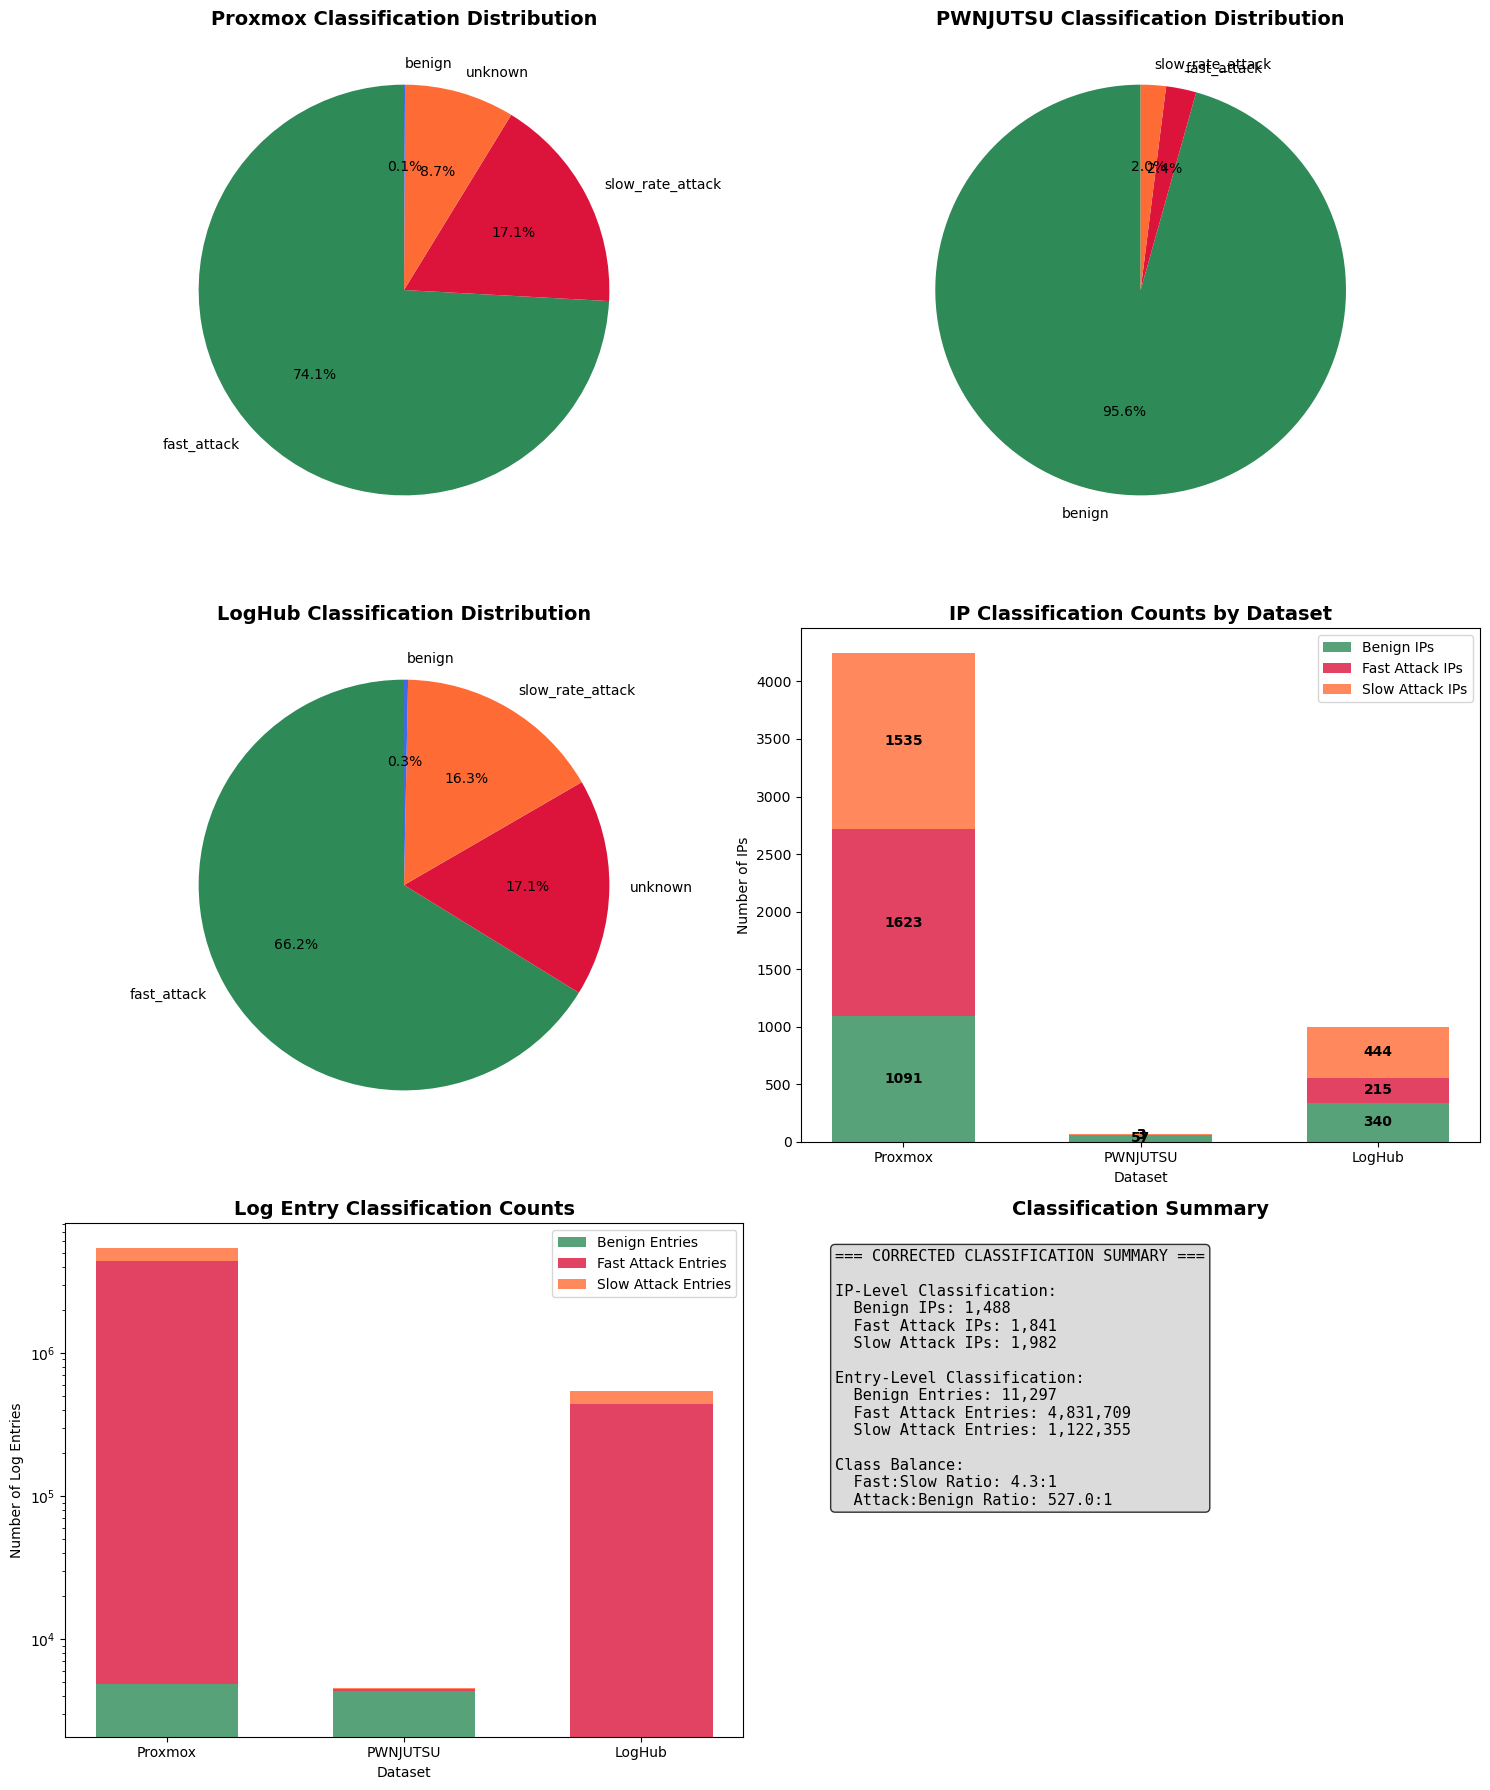

=== DETAILED CORRECTED CLASSIFICATION STATISTICS ===

Proxmox Dataset:
  Benign IPs: 1,091
  Fast Attack IPs: 1,623
  Slow Attack IPs: 1,535
  Benign Entries: 4,874
  Fast Attack Entries: 4,397,808
  Slow Attack Entries: 1,015,276

PWNJUTSU Dataset:
  Benign IPs: 57
  Fast Attack IPs: 3
  Slow Attack IPs: 3
  Benign Entries: 4,344
  Fast Attack Entries: 108
  Slow Attack Entries: 90

LogHub Dataset:
  Benign IPs: 340
  Fast Attack IPs: 215
  Slow Attack IPs: 444
  Benign Entries: 2,079
  Fast Attack Entries: 433,793
  Slow Attack Entries: 106,989

Overall Totals:
  Total IPs: 5,311
  Total Entries: 5,965,361
  Fast:Slow IP Ratio: 0.9:1
  Fast:Slow Entry Ratio: 4.3:1


In [8]:
# === CORRECTED CLASSIFICATION VISUALIZATION ===
import matplotlib.pyplot as plt

plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

classification_colors = ['#2E8B57', '#DC143C', '#FF6B35', '#4169E1']  # benign, fast, slow, unknown

# -----------------------------
# 1. Proxmox Classification Distribution
if 'proxmox_labeled' in globals() and proxmox_labeled is not None:
    proxmox_counts = proxmox_labeled['traffic_label'].value_counts()
    axes[0, 0].pie(proxmox_counts.values, labels=proxmox_counts.index, 
                   autopct='%1.1f%%', colors=classification_colors, startangle=90)
    axes[0, 0].set_title('Proxmox Classification Distribution', fontsize=14, fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'No Proxmox\nData', ha='center', va='center', fontsize=16)

# 2. PWNJUTSU Classification Distribution  
if 'pwnjutsu_labeled' in globals() and pwnjutsu_labeled is not None and len(pwnjutsu_labeled) > 0:
    pwnjutsu_counts = pwnjutsu_labeled['traffic_label'].value_counts()
    axes[0, 1].pie(pwnjutsu_counts.values, labels=pwnjutsu_counts.index,
                   autopct='%1.1f%%', colors=classification_colors, startangle=90)
    axes[0, 1].set_title('PWNJUTSU Classification Distribution', fontsize=14, fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'No PWNJUTSU\nData', ha='center', va='center', fontsize=16)

# 3. LogHub Classification Distribution
if 'loghub_labeled' in globals() and loghub_labeled is not None and len(loghub_labeled) > 0:
    loghub_counts = loghub_labeled['traffic_label'].value_counts()
    axes[1, 0].pie(loghub_counts.values, labels=loghub_counts.index,
                   autopct='%1.1f%%', colors=classification_colors, startangle=90)
    axes[1, 0].set_title('LogHub Classification Distribution', fontsize=14, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'No LogHub\nData', ha='center', va='center', fontsize=16)

# 4. Combined IP Classification Counts
datasets = ['Proxmox', 'PWNJUTSU', 'LogHub']
benign_counts = []
fast_counts = []
slow_counts = []

# Proxmox IP counts
if 'proxmox_benign_ips' in globals():
    benign_counts.append(len(proxmox_benign_ips))
    fast_counts.append(len(proxmox_fast_ips))
    slow_counts.append(len(proxmox_slow_ips))
else:
    benign_counts.append(0)
    fast_counts.append(0)
    slow_counts.append(0)

# PWNJUTSU IP counts
if 'pwnjutsu_benign_ips' in globals():
    benign_counts.append(len(pwnjutsu_benign_ips))
    fast_counts.append(len(pwnjutsu_fast_ips))
    slow_counts.append(len(pwnjutsu_slow_ips))
else:
    benign_counts.append(0)
    fast_counts.append(0)
    slow_counts.append(0)

# LogHub IP counts
if 'loghub_benign_ips' in globals():
    benign_counts.append(len(loghub_benign_ips))
    fast_counts.append(len(loghub_fast_ips))
    slow_counts.append(len(loghub_slow_ips))
else:
    benign_counts.append(0)
    fast_counts.append(0)
    slow_counts.append(0)

# Stacked bar chart
width = 0.6
x = range(len(datasets))
axes[1, 1].bar(x, benign_counts, width, label='Benign IPs', color='#2E8B57', alpha=0.8)
axes[1, 1].bar(x, fast_counts, width, bottom=benign_counts, label='Fast Attack IPs', color='#DC143C', alpha=0.8)
bottom_vals = [b + f for b, f in zip(benign_counts, fast_counts)]
axes[1, 1].bar(x, slow_counts, width, bottom=bottom_vals, label='Slow Attack IPs', color='#FF6B35', alpha=0.8)

axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_ylabel('Number of IPs')
axes[1, 1].set_title('IP Classification Counts by Dataset', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(datasets)
axes[1, 1].legend()

# Add count labels on bars
for i, (b, f, s) in enumerate(zip(benign_counts, fast_counts, slow_counts)):
    if b > 0:
        axes[1, 1].text(i, b/2, str(b), ha='center', va='center', fontweight='bold')
    if f > 0:
        axes[1, 1].text(i, b + f/2, str(f), ha='center', va='center', fontweight='bold')
    if s > 0:
        axes[1, 1].text(i, b + f + s/2, str(s), ha='center', va='center', fontweight='bold')

# 5. Combined Entry Counts Comparison
entry_datasets = []
entry_benign = []
entry_fast = []
entry_slow = []

if 'proxmox_labeled' in globals() and proxmox_labeled is not None:
    entry_datasets.append('Proxmox')
    entry_benign.append(len(proxmox_labeled[proxmox_labeled['traffic_label'] == 'benign']))
    entry_fast.append(len(proxmox_labeled[proxmox_labeled['traffic_label'] == 'fast_attack']))
    entry_slow.append(len(proxmox_labeled[proxmox_labeled['traffic_label'] == 'slow_rate_attack']))

if 'pwnjutsu_labeled' in globals() and pwnjutsu_labeled is not None and len(pwnjutsu_labeled) > 0:
    entry_datasets.append('PWNJUTSU')
    entry_benign.append(len(pwnjutsu_labeled[pwnjutsu_labeled['traffic_label'] == 'benign']))
    entry_fast.append(len(pwnjutsu_labeled[pwnjutsu_labeled['traffic_label'] == 'fast_attack']))
    entry_slow.append(len(pwnjutsu_labeled[pwnjutsu_labeled['traffic_label'] == 'slow_rate_attack']))

if 'loghub_labeled' in globals() and loghub_labeled is not None and len(loghub_labeled) > 0:
    entry_datasets.append('LogHub')
    entry_benign.append(len(loghub_labeled[loghub_labeled['traffic_label'] == 'benign']))
    entry_fast.append(len(loghub_labeled[loghub_labeled['traffic_label'] == 'fast_attack']))
    entry_slow.append(len(loghub_labeled[loghub_labeled['traffic_label'] == 'slow_rate_attack']))

if entry_datasets:
    x_entries = range(len(entry_datasets))
    axes[2, 0].bar(x_entries, entry_benign, width, label='Benign Entries', color='#2E8B57', alpha=0.8)
    axes[2, 0].bar(x_entries, entry_fast, width, bottom=entry_benign, label='Fast Attack Entries', color='#DC143C', alpha=0.8)
    bottom_entries = [b + f for b, f in zip(entry_benign, entry_fast)]
    axes[2, 0].bar(x_entries, entry_slow, width, bottom=bottom_entries, label='Slow Attack Entries', color='#FF6B35', alpha=0.8)
    
    axes[2, 0].set_xlabel('Dataset')
    axes[2, 0].set_ylabel('Number of Log Entries')
    axes[2, 0].set_title('Log Entry Classification Counts', fontsize=14, fontweight='bold')
    axes[2, 0].set_xticks(x_entries)
    axes[2, 0].set_xticklabels(entry_datasets)
    axes[2, 0].legend()
    axes[2, 0].set_yscale('log')  # Log scale due to large differences

# 6. Summary Statistics Text
summary_text = "=== CORRECTED CLASSIFICATION SUMMARY ===\n\n"

# Calculate totals
total_benign_ips = sum(benign_counts)
total_fast_ips = sum(fast_counts) 
total_slow_ips = sum(slow_counts)
total_benign_entries = sum(entry_benign) if entry_benign else 0
total_fast_entries = sum(entry_fast) if entry_fast else 0
total_slow_entries = sum(entry_slow) if entry_slow else 0

summary_text += f"IP-Level Classification:\n"
summary_text += f"  Benign IPs: {total_benign_ips:,}\n"
summary_text += f"  Fast Attack IPs: {total_fast_ips:,}\n"
summary_text += f"  Slow Attack IPs: {total_slow_ips:,}\n\n"

summary_text += f"Entry-Level Classification:\n"
summary_text += f"  Benign Entries: {total_benign_entries:,}\n"
summary_text += f"  Fast Attack Entries: {total_fast_entries:,}\n"
summary_text += f"  Slow Attack Entries: {total_slow_entries:,}\n\n"

if total_fast_entries > 0 and total_slow_entries > 0:
    summary_text += f"Class Balance:\n"
    summary_text += f"  Fast:Slow Ratio: {total_fast_entries/total_slow_entries:.1f}:1\n"
    summary_text += f"  Attack:Benign Ratio: {(total_fast_entries+total_slow_entries)/max(total_benign_entries,1):.1f}:1"

axes[2, 1].text(0.05, 0.95, summary_text, transform=axes[2, 1].transAxes, 
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
axes[2, 1].set_xlim(0, 1)
axes[2, 1].set_ylim(0, 1)
axes[2, 1].axis('off')
axes[2, 1].set_title('Classification Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== DETAILED CORRECTED CLASSIFICATION STATISTICS ===")

for i, dataset in enumerate(['Proxmox', 'PWNJUTSU', 'LogHub']):
    if i < len(benign_counts) and (benign_counts[i] > 0 or fast_counts[i] > 0 or slow_counts[i] > 0):
        print(f"\n{dataset} Dataset:")
        print(f"  Benign IPs: {benign_counts[i]:,}")
        print(f"  Fast Attack IPs: {fast_counts[i]:,}")  
        print(f"  Slow Attack IPs: {slow_counts[i]:,}")
        
        if i < len(entry_benign):
            print(f"  Benign Entries: {entry_benign[i]:,}")
            print(f"  Fast Attack Entries: {entry_fast[i]:,}")
            print(f"  Slow Attack Entries: {entry_slow[i]:,}")

print(f"\nOverall Totals:")
print(f"  Total IPs: {total_benign_ips + total_fast_ips + total_slow_ips:,}")
print(f"  Total Entries: {total_benign_entries + total_fast_entries + total_slow_entries:,}")
print(f"  Fast:Slow IP Ratio: {total_fast_ips/max(total_slow_ips,1):.1f}:1")
print(f"  Fast:Slow Entry Ratio: {total_fast_entries/max(total_slow_entries,1):.1f}:1")

## 5 Time Window Creation

In [9]:
# --- Shannon entropy helper ---
from collections import Counter
import math

def shannon_entropy(counts):
    total = sum(counts)
    if total == 0:
        return 0.0
    probs = [c / total for c in counts if c > 0]
    return -sum(p * math.log2(p) for p in probs)


# --- Single-window-size function ---
def create_best_time_windows_gpu(df, dataset_name,
                                 window_size_minutes,
                                 step_size_minutes=15,
                                 majority_threshold=0.6,
                                 min_events=5):
    """
    Create time windows for a given dataset, with majority class label and
    extra temporal/behavioral features.
    """

    if df is None or len(df) == 0:
        print(f"[WARN] Empty dataframe for {dataset_name}")
        return pd.DataFrame()

    # === Timestamp normalization per dataset ===
    if 'datetime' not in df.columns:
        if dataset_name == 'proxmox':
            df['datetime'] = pd.to_datetime('2025 ' + df['timestamp'],
                                            format='%Y %b %d %H:%M:%S',
                                            errors='coerce')
        elif dataset_name == 'pwnjutsu':
            df['datetime'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
        elif dataset_name == 'loghub':
            # LogHub Linux logs usually have a generic time column
            time_col = next((c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()), None)
            if time_col:
                df['datetime'] = pd.to_datetime(df[time_col], errors='coerce')
            else:
                raise ValueError("No timestamp column found for LogHub dataset")

    df = df.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True)
    if df.empty:
        print(f"[WARN] No valid datetime entries for {dataset_name}")
        return pd.DataFrame()

    start_time, end_time = df['datetime'].min(), df['datetime'].max()

    timestamps_np = df['datetime'].values.astype('datetime64[s]').astype(np.int64)
    timestamps_gpu = cp.array(timestamps_np)

    # Masks (only Proxmox has detailed log_type masks)
    if dataset_name == 'proxmox':
        log_type_masks_gpu = {
            'failed_auth': cp.array((df['log_type'] == 'failed_auth').values),
            'successful_auth': cp.array((df['log_type'] == 'successful_auth').values),
            'connection_closed': cp.array((df['log_type'] == 'connection_closed').values),
            'invalid_user': cp.array((df['log_type'] == 'invalid_user').values),
            'auth_failure': cp.array((df['log_type'] == 'auth_failure').values),
            'unknown': cp.array((df['log_type'] == 'unknown').values)
        }
    else:
        log_type_masks_gpu = {}

    classes = ['slow_rate_attack', 'fast_attack', 'benign']
    label_masks_gpu = {c: cp.array((df['traffic_label'] == c).values) for c in classes}

    total_minutes = int((end_time - start_time).total_seconds() / 60)
    num_windows = max(1, (total_minutes - window_size_minutes) // step_size_minutes + 1)

    print(f"\n=== {dataset_name.upper()} | {window_size_minutes} min windows, {step_size_minutes} min step ===")
    print(f"Creating {num_windows} windows…")

    window_starts = [start_time + timedelta(minutes=i * step_size_minutes) for i in range(num_windows)]
    time_windows = []

    for current_time in window_starts:
        window_end = current_time + timedelta(minutes=window_size_minutes)
        ws = np.datetime64(current_time).astype('datetime64[s]').astype(np.int64)
        we = np.datetime64(window_end).astype('datetime64[s]').astype(np.int64)

        window_mask = (timestamps_gpu >= ws) & (timestamps_gpu < we)
        total_events = int(cp.sum(window_mask))
        if total_events < min_events:
            continue

        wf = {'window_start': current_time,
              'window_end': window_end,
              'total_events': total_events,
              'dataset': dataset_name,
              'window_size_minutes': window_size_minutes}

        src_col = next((c for c in ['source_ip', 'id.orig_h'] if c in df.columns), None)
        wf['unique_source_ips'] = len(df.loc[cp.asnumpy(window_mask), src_col].unique()) if src_col else 0

        for lt, mask in log_type_masks_gpu.items():
            wf[f'{lt}_count'] = int(cp.sum(window_mask & mask))

        # class counts & majority
        class_counts = {c: int(cp.sum(window_mask & label_masks_gpu[c])) for c in classes}
        maj_label = max(class_counts, key=class_counts.get)
        maj_ratio = class_counts[maj_label] / total_events if total_events > 0 else 0
        wf['majority_ratio'] = maj_ratio
        wf['window_label'] = maj_label if maj_ratio >= majority_threshold else maj_label

        # extra features - WITH NaN HANDLING
        ew = df.loc[cp.asnumpy(window_mask)]
        if len(ew) > 1:
            inter = ew['datetime'].diff().dt.total_seconds().dropna()
            if not inter.empty and inter.mean() > 0:
                wf['avg_interarrival_time'] = float(inter.mean())
                # FIXED: Safe burstiness calculation
                std_val = inter.std()
                mean_val = inter.mean()
                wf['burstiness'] = float(std_val / mean_val) if mean_val > 0 and not np.isnan(std_val) else 0.0
            else:
                wf['avg_interarrival_time'] = 0.0
                wf['burstiness'] = 0.0
        else:
            wf['avg_interarrival_time'] = 0.0
            wf['burstiness'] = 0.0

        # FIXED: Safe failed_success_ratio calculation
        if dataset_name == 'proxmox':
            f = int(cp.sum(window_mask & log_type_masks_gpu['failed_auth']))
            s = int(cp.sum(window_mask & log_type_masks_gpu['successful_auth']))
            wf['failed_success_ratio'] = float(f / s) if s > 0 else float(f)
        else:
            wf['failed_success_ratio'] = 0.0

        # FIXED: Safe entropy calculation
        try:
            label_counts = ew['traffic_label'].value_counts().values
            wf['event_entropy'] = shannon_entropy(label_counts) if len(label_counts) > 0 else 0.0
        except:
            wf['event_entropy'] = 0.0

        # DATA VALIDATION: Check for NaN/inf values and replace
        for key, value in wf.items():
            if isinstance(value, (int, float)) and (np.isnan(value) or np.isinf(value)):
                wf[key] = 0.0
                print(f"[WARN] {dataset_name}: Replaced NaN/inf in {key}")

        time_windows.append(wf)

    results = pd.DataFrame(time_windows)
    if not results.empty:
        # ADDITIONAL DATA CLEANING: Remove any remaining NaN values
        numeric_cols = results.select_dtypes(include=[np.number]).columns
        results[numeric_cols] = results[numeric_cols].fillna(0.0)
        
        # Replace any inf values
        results = results.replace([np.inf, -np.inf], 0.0)
        
        counts = results['window_label'].value_counts()
        print("Label distribution:")
        for lbl, cnt in counts.items():
            print(f"  {lbl}: {cnt} ({cnt/len(results)*100:.1f}%)")
        print(f"Avg events/window: {results['total_events'].mean():.1f}")
        
        # DATA QUALITY CHECK
        nan_count = results.isnull().sum().sum()
        if nan_count > 0:
            print(f"[WARN] {dataset_name}: {nan_count} NaN values found and cleaned")

    return results

proxmox_best_windows = create_best_time_windows_gpu(
    proxmox_labeled, 'proxmox', 
    window_size_minutes=15,      # Reduced from 60 to 15 minutes
    step_size_minutes=5,         # Reduced from 15 to 5 minutes (more overlap)
    majority_threshold=0.4,      # Reduced from 0.6 to 0.4 (less strict)
    min_events=2                 # Reduced from 5 to 2 (capture more windows)
)

pwnjutsu_best_windows = create_best_time_windows_gpu(
    pwnjutsu_labeled, 'pwnjutsu', 
    window_size_minutes=10,      # Reduced from 30 to 10 minutes
    step_size_minutes=3,         # Reduced from 15 to 3 minutes (heavy overlap)
    majority_threshold=0.4,      # Reduced from 0.6 to 0.4
    min_events=1                 # Reduced from 5 to 1 (capture almost all)
)

if 'loghub_labeled' in globals() and loghub_labeled is not None and len(loghub_labeled) > 0:
    loghub_best_windows = create_best_time_windows_gpu(
        loghub_labeled, 'loghub', 
        window_size_minutes=10,  # Reduced from 30 to 10 minutes
        step_size_minutes=3,     # Reduced from 15 to 3 minutes
        majority_threshold=0.4,  # Reduced from 0.6 to 0.4
        min_events=2             # Reduced from 5 to 2
    )
else:
    loghub_best_windows = pd.DataFrame()

print(f"\n=== WINDOWING RESULTS SUMMARY ===")
print(f"Proxmox windows: {len(proxmox_best_windows):,}")
print(f"PWNJUTSU windows: {len(pwnjutsu_best_windows):,}")
print(f"LogHub windows: {len(loghub_best_windows):,}")
print(f"Total windows: {len(proxmox_best_windows) + len(pwnjutsu_best_windows) + len(loghub_best_windows):,}")


=== PROXMOX | 15 min windows, 5 min step ===
Creating 25206 windows…
Label distribution:
  fast_attack: 14424 (61.6%)
  slow_rate_attack: 8782 (37.5%)
  benign: 217 (0.9%)
Avg events/window: 759.7

=== PWNJUTSU | 10 min windows, 3 min step ===
Creating 20267 windows…
Label distribution:
  benign: 1420 (94.4%)
  fast_attack: 47 (3.1%)
  slow_rate_attack: 37 (2.5%)
Avg events/window: 10.1

=== LOGHUB | 10 min windows, 3 min step ===
Creating 13646 windows…
Label distribution:
  slow_rate_attack: 4759 (54.7%)
  fast_attack: 3477 (40.0%)
  benign: 458 (5.3%)
Avg events/window: 251.3

=== WINDOWING RESULTS SUMMARY ===
Proxmox windows: 23,423
PWNJUTSU windows: 1,504
LogHub windows: 8,694
Total windows: 33,621


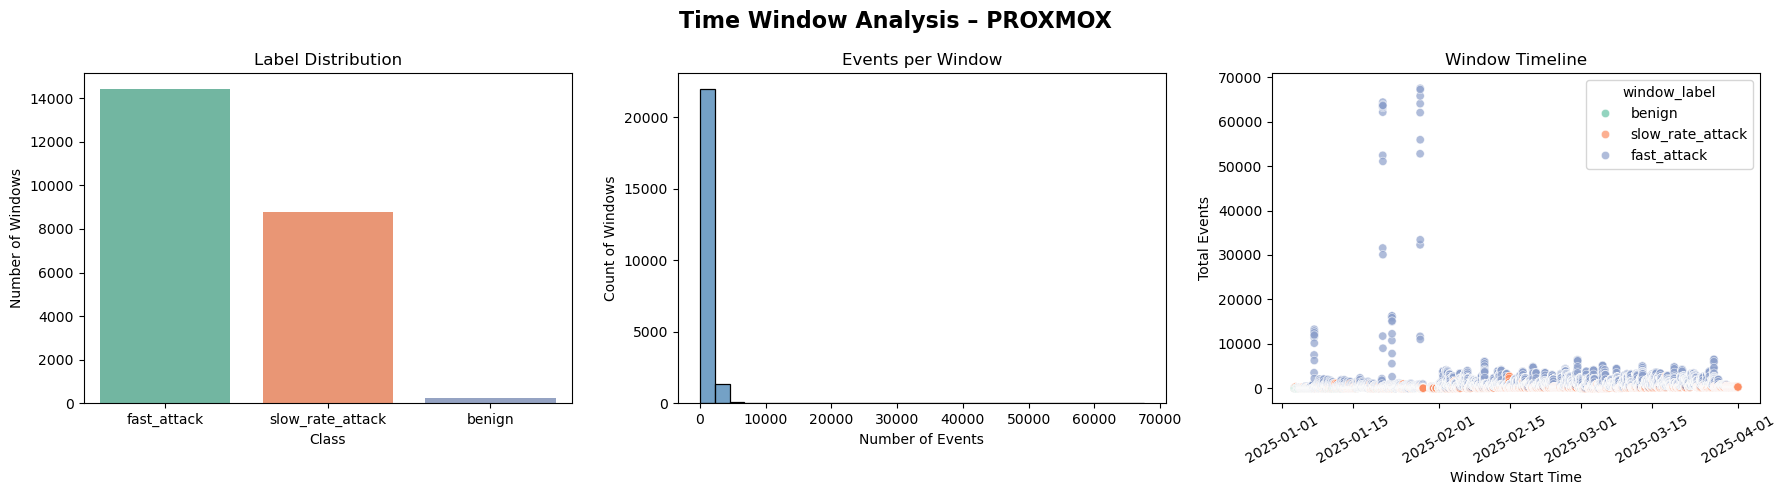

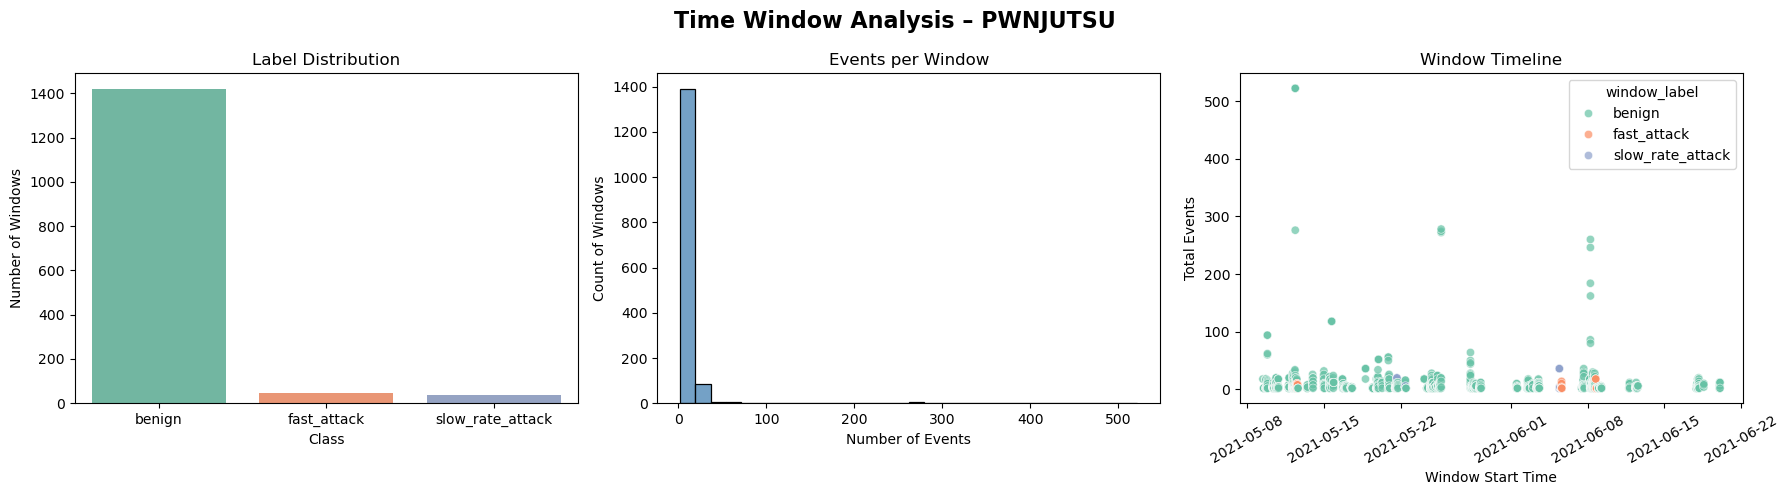

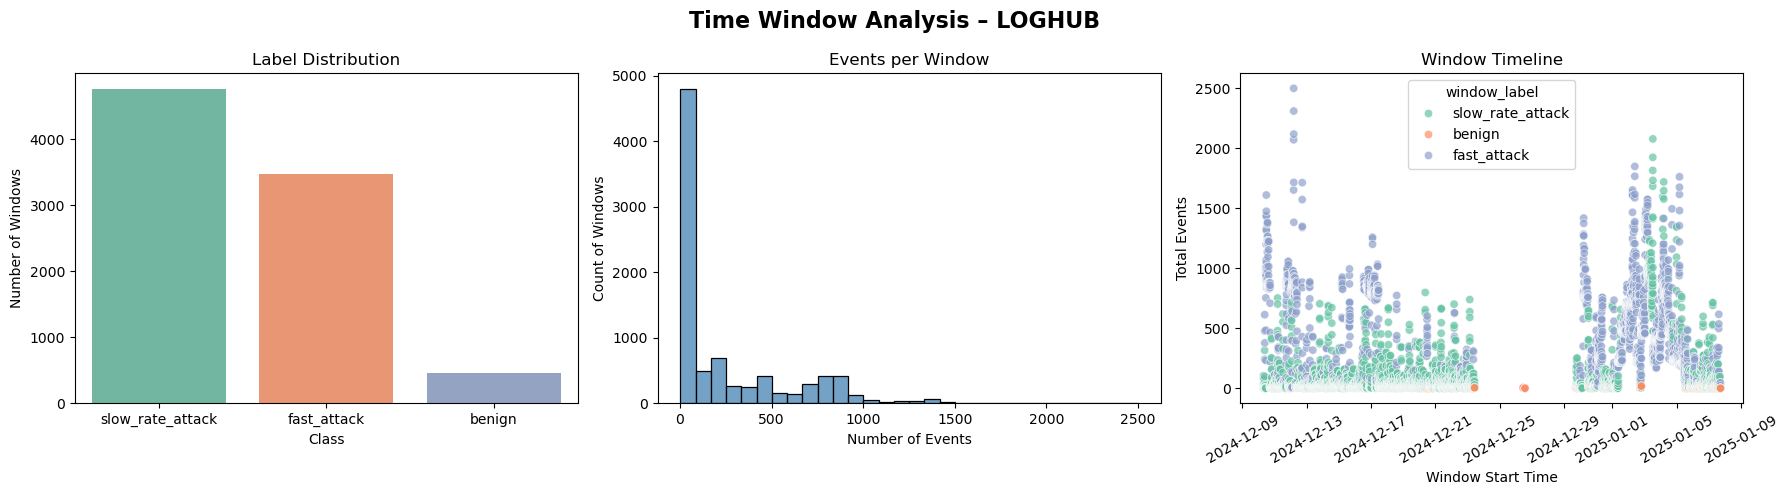

In [10]:
def visualize_time_windows(window_df, dataset_name):
    """Visualize the time-window dataset for one source."""
    if window_df is None or window_df.empty:
        print(f"No data for {dataset_name}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Time Window Analysis – {dataset_name.upper()}", fontsize=16, fontweight="bold")

    # 1. Label distribution
    sns.countplot(
        data=window_df,
        x="window_label",
        order=window_df['window_label'].value_counts().index,
        ax=axes[0],
        palette="Set2"
    )
    axes[0].set_title("Label Distribution")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Number of Windows")

    # 2. Events per window
    sns.histplot(window_df["total_events"], bins=30, kde=False, ax=axes[1], color="steelblue")
    axes[1].set_title("Events per Window")
    axes[1].set_xlabel("Number of Events")
    axes[1].set_ylabel("Count of Windows")

    # 3. Timeline scatter
    sns.scatterplot(
        data=window_df,
        x="window_start",
        y="total_events",
        hue="window_label",
        palette="Set2",
        ax=axes[2],
        alpha=0.7
    )
    axes[2].set_title("Window Timeline")
    axes[2].set_xlabel("Window Start Time")
    axes[2].set_ylabel("Total Events")
    axes[2].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()


# Visualize all available datasets
visualize_time_windows(proxmox_best_windows, "Proxmox")
visualize_time_windows(pwnjutsu_best_windows, "PWNJUTSU")
if 'loghub_best_windows' in globals() and not loghub_best_windows.empty:
    visualize_time_windows(loghub_best_windows, "LogHub")


## 6 Balance Check & Mitigation

In [11]:
from sklearn.utils.class_weight import compute_class_weight

def balance_summary(df, name):
    """Print class distribution for a time-window dataframe and return class weights (dict)."""
    if df is None or len(df) == 0:
        print(f"{name}: no windows available")
        return {}

    counts = df['window_label'].value_counts()
    total = counts.sum()
    print(f"\n=== {name.upper()} CLASS DISTRIBUTION ===")
    for lbl, cnt in counts.items():
        perc = (cnt / total) * 100
        print(f"  {lbl}: {cnt} ({perc:.1f}%)")
    print(f"  Total windows: {total}")

    # Compute class weights (name->weight)
    y = df['window_label'].values
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    weight_dict = {cls: float(w) for cls, w in zip(classes, weights)}
    print(f"  Suggested class weights: {weight_dict}")
    return weight_dict

# Run balance checks for available datasets
prox_class_weights = balance_summary(proxmox_best_windows, "Proxmox (60min)") if 'proxmox_best_windows' in globals() else {}
pwn_class_weights  = balance_summary(pwnjutsu_best_windows, "PWNJUTSU (30min)") if 'pwnjutsu_best_windows' in globals() else {}
loghub_class_weights = balance_summary(loghub_best_windows, "LogHub (60min)") if 'loghub_best_windows' in globals() else {}


=== PROXMOX (60MIN) CLASS DISTRIBUTION ===
  fast_attack: 14424 (61.6%)
  slow_rate_attack: 8782 (37.5%)
  benign: 217 (0.9%)
  Total windows: 23423
  Suggested class weights: {'benign': 35.98003072196621, 'fast_attack': 0.5412969125531522, 'slow_rate_attack': 0.8890533667349882}

=== PWNJUTSU (30MIN) CLASS DISTRIBUTION ===
  benign: 1420 (94.4%)
  fast_attack: 47 (3.1%)
  slow_rate_attack: 37 (2.5%)
  Total windows: 1504
  Suggested class weights: {'benign': 0.3530516431924883, 'fast_attack': 10.666666666666666, 'slow_rate_attack': 13.54954954954955}

=== LOGHUB (60MIN) CLASS DISTRIBUTION ===
  slow_rate_attack: 4759 (54.7%)
  fast_attack: 3477 (40.0%)
  benign: 458 (5.3%)
  Total windows: 8694
  Suggested class weights: {'benign': 6.327510917030568, 'fast_attack': 0.8334771354616048, 'slow_rate_attack': 0.6089514603908384}


In [12]:
frames = []

def _ensure_required_cols(df, name):
    """Ensure required columns exist. Raise if missing key timeline/label fields."""
    req = ['window_start', 'window_end', 'window_label']
    missing = [c for c in req if c not in df.columns]
    if missing:
        raise ValueError(f"{name} is missing required columns: {missing}")
    return df

if 'proxmox_best_windows' in globals() and len(proxmox_best_windows) > 0:
    px = _ensure_required_cols(proxmox_best_windows.copy(), 'proxmox_best_windows')
    px['dataset'] = 'proxmox'
    frames.append(px)

if 'pwnjutsu_best_windows' in globals() and len(pwnjutsu_best_windows) > 0:
    pw = _ensure_required_cols(pwnjutsu_best_windows.copy(), 'pwnjutsu_best_windows')
    pw['dataset'] = 'pwnjutsu'
    frames.append(pw)

if 'loghub_best_windows' in globals() and len(loghub_best_windows) > 0:
    lg = _ensure_required_cols(loghub_best_windows.copy(), 'loghub_best_windows')
    lg['dataset'] = 'loghub'
    frames.append(lg)

# Concatenate (may be empty)
combined_windows = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

# Common features across all datasets (matches Cell 19 _select_feature_columns)
canonical_feats = [
    'total_events', 'unique_source_ips', 'majority_ratio',
    'avg_interarrival_time', 'burstiness', 'event_entropy'
]

for col in canonical_feats:
    if col not in combined_windows.columns:
        combined_windows[col] = 0.0

for col in canonical_feats:
    combined_windows[col] = pd.to_numeric(combined_windows[col], errors='coerce').fillna(0)

if 'window_start' in combined_windows.columns:
    combined_windows = combined_windows.sort_values('window_start').reset_index(drop=True)

print("=== COMBINED WINDOWS SUMMARY ===")
print(f"Total windows: {len(combined_windows)}")
if len(combined_windows) > 0:
    print("Datasets:", dict(combined_windows['dataset'].value_counts()))
    print("Labels  :", dict(combined_windows['window_label'].value_counts()))
    missing_feats = [c for c in canonical_feats if c not in combined_windows.columns]
    if missing_feats:
        print("Note: missing feature columns:", missing_feats)
else:
    print("combined_windows is EMPTY. Ensure best-window creation cells ran successfully.")

if len(combined_windows) > 0:
    print("\n=== COMBINED CLASS WEIGHTS (from combined_windows) ===")
    _y = combined_windows['window_label'].values
    _classes = np.unique(_y)
    _w = compute_class_weight(class_weight='balanced', classes=_classes, y=_y)
    combined_class_weights = {cls: float(w) for cls, w in zip(_classes, _w)}
    print(combined_class_weights)
else:
    combined_class_weights = {}

=== COMBINED WINDOWS SUMMARY ===
Total windows: 33621
Datasets: {'proxmox': np.int64(23423), 'loghub': np.int64(8694), 'pwnjutsu': np.int64(1504)}
Labels  : {'fast_attack': np.int64(17948), 'slow_rate_attack': np.int64(13578), 'benign': np.int64(2095)}

=== COMBINED CLASS WEIGHTS (from combined_windows) ===
{'benign': 5.349403341288783, 'fast_attack': 0.624414976599064, 'slow_rate_attack': 0.8253792900279865}


## 7 LSTM Sequence Preparation

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import cupy as cp

def _select_feature_columns(windows_df):
    """Select only features common to all datasets (Proxmox, PWNJUTSU, LogHub)."""
    # Features that exist in all datasets with identical meaning
    common_features = [
        'total_events',           # Activity level
        'unique_source_ips',      # IP diversity  
        'majority_ratio',         # Label confidence
        'avg_interarrival_time',  # Timing pattern
        'burstiness',            # Timing regularity
        'event_entropy'          # Pattern diversity
    ]
    
    # Keep only features that exist in the dataframe
    available_features = [f for f in common_features if f in windows_df.columns]
    print(f"[FeatureSelect] Using {len(available_features)} common features: {available_features}")
    
    # Warn about missing features
    missing_features = [f for f in common_features if f not in windows_df.columns]
    if missing_features:
        print(f"[FeatureSelect] WARNING: Missing common features: {missing_features}")
    
    return available_features

def _clean_feature_data(X, feature_names=None):
    """Clean feature data: handle NaN, inf, and extreme values."""
    if len(X) == 0:
        return X
    
    X = np.asarray(X, dtype=np.float32)
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
    
    if nan_count > 0 or inf_count > 0:
        print(f"[DataClean] Found {nan_count} NaN and {inf_count} inf values - cleaning...")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        
        for i in range(X.shape[-1]):
            if X.ndim == 3:
                feat_data = X[:, :, i].flatten()
            else:
                feat_data = X[:, i]
            
            if len(feat_data) > 0:
                p99 = np.percentile(feat_data[np.isfinite(feat_data)], 99.9)
                if p99 > 0:
                    X[..., i] = np.clip(X[..., i], -p99, p99)
    
    return X

def _validate_classes(labels, min_samples_per_class=10):
    """Validate that we have sufficient samples for each class."""
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"[ClassValidation] Found classes: {dict(zip(unique_labels, counts))}")
    
    insufficient = [(label, count) for label, count in zip(unique_labels, counts) 
                   if count < min_samples_per_class]
    
    if insufficient:
        print(f"[ClassValidation] WARNING: Classes with <{min_samples_per_class} samples: {insufficient}")
    
    return unique_labels, counts

def _make_sequences(df, feature_cols, seq_len=12, step_size=None):
    """Create sequences per dataset (chronological)."""
    if step_size is None:
        step_size = max(1, seq_len // 4)

    sequences, labels, seq_ds = [], [], []
    
    missing_cols = [col for col in feature_cols if col not in df.columns]
    if missing_cols:
        print(f"[SeqPrep] WARNING: Missing feature columns: {missing_cols}")
        for col in missing_cols:
            df[col] = 0.0
    
    for ds in df['dataset'].unique():
        sub = df[df['dataset'] == ds].sort_values('window_start')
        if len(sub) < seq_len:
            if len(sub) >= 3:
                for short_len in range(3, min(seq_len, len(sub) + 1)):
                    if len(sub) >= short_len:
                        X_sub = sub[feature_cols].values.astype(np.float32)
                        X_sub = _clean_feature_data(X_sub, feature_cols)
                        y_sub = sub['window_label'].values
                        
                        X_padded = np.zeros((seq_len, len(feature_cols)), dtype=np.float32)
                        X_padded[:short_len] = X_sub[:short_len]
                        X_padded[short_len:] = X_sub[-1]
                        sequences.append(X_padded)
                        u, c = np.unique(y_sub[:short_len], return_counts=True)
                        labels.append(u[np.argmax(c)])
                        seq_ds.append(ds)
            continue
            
        X_sub = sub[feature_cols].values.astype(np.float32)
        X_sub = _clean_feature_data(X_sub, feature_cols)
        y_sub = sub['window_label'].values
        
        for i in range(0, len(sub) - seq_len + 1, step_size):
            sl = slice(i, i + seq_len)
            seq_data = X_sub[sl, :]
            
            if np.all(seq_data == 0):
                continue
                
            sequences.append(seq_data)
            u, c = np.unique(y_sub[sl], return_counts=True)
            labels.append(u[np.argmax(c)])
            seq_ds.append(ds)

    if len(sequences) == 0:
        return np.empty((0, seq_len, len(feature_cols))), np.array([]), np.array([])
    
    sequences = np.stack(sequences)
    sequences = _clean_feature_data(sequences, feature_cols)
    labels = np.array(labels)
    seq_ds = np.array(seq_ds)
    
    _validate_classes(labels)
    
    return sequences, labels, seq_ds

def _make_mixed_sequences(df, feature_cols, seq_len=12, step_size=None):
    """Create mixed dataset sequences with domain indicators."""
    if step_size is None:
        step_size = max(1, seq_len // 4)

    sequences, labels, seq_ds, domain_features = [], [], [], []
    dataset_map = {'proxmox': 0, 'pwnjutsu': 1, 'loghub': 2}
    
    missing_cols = [col for col in feature_cols if col not in df.columns]
    if missing_cols:
        print(f"[MixedSeq] WARNING: Missing feature columns: {missing_cols}")
        for col in missing_cols:
            df[col] = 0.0
    
    for ds in df['dataset'].unique():
        sub = df[df['dataset'] == ds].sort_values('window_start')
        if len(sub) < seq_len:
            if len(sub) >= 3:
                for short_len in range(3, min(seq_len, len(sub) + 1)):
                    if len(sub) >= short_len:
                        X_sub = sub[feature_cols].values.astype(np.float32)
                        X_sub = _clean_feature_data(X_sub, feature_cols)
                        y_sub = sub['window_label'].values
                        
                        X_padded = np.zeros((seq_len, len(feature_cols)), dtype=np.float32)
                        X_padded[:short_len] = X_sub[:short_len]
                        X_padded[short_len:] = X_sub[-1]
                        
                        sequences.append(X_padded)
                        u, c = np.unique(y_sub[:short_len], return_counts=True)
                        labels.append(u[np.argmax(c)])
                        seq_ds.append(ds)
                        
                        domain_vec = np.zeros(3, dtype=np.float32)
                        domain_vec[dataset_map[ds]] = 1.0
                        domain_features.append(domain_vec)
            continue
            
        X_sub = sub[feature_cols].values.astype(np.float32)
        X_sub = _clean_feature_data(X_sub, feature_cols)
        y_sub = sub['window_label'].values
        
        for i in range(0, len(sub) - seq_len + 1, step_size):
            sl = slice(i, i + seq_len)
            seq_data = X_sub[sl, :]
            
            if np.all(seq_data == 0):
                continue
                
            sequences.append(seq_data)
            u, c = np.unique(y_sub[sl], return_counts=True)
            labels.append(u[np.argmax(c)])
            seq_ds.append(ds)
            
            domain_vec = np.zeros(3, dtype=np.float32)
            domain_vec[dataset_map[ds]] = 1.0
            domain_features.append(domain_vec)

    if len(sequences) == 0:
        return np.empty((0, seq_len, len(feature_cols))), np.array([]), np.array([]), np.empty((0, 3))
    
    sequences = np.stack(sequences)
    sequences = _clean_feature_data(sequences, feature_cols)
    labels = np.array(labels)
    seq_ds = np.array(seq_ds)
    domain_features = np.stack(domain_features)
    
    _validate_classes(labels)
    
    return sequences, labels, seq_ds, domain_features

def _normalize_on_train(X_train_seq):
    """Compute mean/std on train sequences only."""
    if len(X_train_seq) == 0:
        return np.zeros((X_train_seq.shape[-1],), dtype=np.float32), np.ones((X_train_seq.shape[-1],), dtype=np.float32)
    
    X_train_seq = _clean_feature_data(X_train_seq)
    
    Xg = cp.array(X_train_seq)
    feat = Xg.reshape(-1, Xg.shape[-1])
    mean = cp.mean(feat, axis=0)
    std  = cp.std(feat,  axis=0)
    std  = cp.where(std == 0, 1, std)
    return cp.asnumpy(mean).astype(np.float32), cp.asnumpy(std).astype(np.float32)

def _apply_norm(X_seq, mean, std):
    """Apply normalization to sequences using given mean/std."""
    if len(X_seq) == 0:
        return X_seq
    
    X_seq = _clean_feature_data(X_seq)
    
    Xg = cp.array(X_seq)
    Xn = (Xg - cp.array(mean)) / cp.array(std)
    return cp.asnumpy(Xn)

def _stratified_split_train_val_test(sequences, labels, seq_ds, train_ratio=0.7, val_ratio=0.15):
    """Stratified split ensuring each split contains samples from all classes."""
    indices = np.arange(len(sequences))
    
    # Create stratification labels combining class and dataset
    stratify_labels = [f"{label}_{ds}" for label, ds in zip(labels, seq_ds)]
    
    try:
        # First split: train vs (val + test)
        train_idx, temp_idx = train_test_split(
            indices, test_size=(1-train_ratio), 
            stratify=stratify_labels, random_state=42
        )
        
        # Second split: val vs test from remaining data
        temp_labels = [stratify_labels[i] for i in temp_idx]
        val_ratio_adjusted = val_ratio / (val_ratio + (1-train_ratio-val_ratio))
        val_idx, test_idx = train_test_split(
            temp_idx, test_size=(1-val_ratio_adjusted),
            stratify=temp_labels, random_state=42
        )
        
        print("[StratifiedSplit] Stratified split successful")
        
    except ValueError as e:
        print(f"[StratifiedSplit] Stratified split failed ({e}), using chronological fallback")
        # Fallback to chronological split if stratified fails
        N = len(sequences)
        split1 = int(N * train_ratio)
        split2 = int(N * (train_ratio + val_ratio))
        train_idx = np.arange(split1)
        val_idx = np.arange(split1, split2)
        test_idx = np.arange(split2, N)
    
    # Extract splits using indices
    X_train, y_train, ds_train = sequences[train_idx], labels[train_idx], seq_ds[train_idx]
    X_val, y_val, ds_val = sequences[val_idx], labels[val_idx], seq_ds[val_idx]
    X_test, y_test, ds_test = sequences[test_idx], labels[test_idx], seq_ds[test_idx]
    
    return X_train, y_train, ds_train, X_val, y_val, ds_val, X_test, y_test, ds_test

def _stratified_mixed_split(sequences, labels, seq_ds, domain_features, train_ratio=0.7, val_ratio=0.15):
    """Stratified split ensuring each split contains samples from all datasets."""
    indices = np.arange(len(sequences))
    stratify_labels = [f"{label}_{ds}" for label, ds in zip(labels, seq_ds)]
    
    train_idx, temp_idx = train_test_split(
        indices, test_size=(1-train_ratio), 
        stratify=stratify_labels, random_state=42
    )
    
    temp_labels = [stratify_labels[i] for i in temp_idx]
    val_ratio_adjusted = val_ratio / (val_ratio + (1-train_ratio-val_ratio))
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=(1-val_ratio_adjusted),
        stratify=temp_labels, random_state=42
    )
    
    X_train, y_train, ds_train, dom_train = sequences[train_idx], labels[train_idx], seq_ds[train_idx], domain_features[train_idx]
    X_val, y_val, ds_val, dom_val = sequences[val_idx], labels[val_idx], seq_ds[val_idx], domain_features[val_idx]
    X_test, y_test, ds_test, dom_test = sequences[test_idx], labels[test_idx], seq_ds[test_idx], domain_features[test_idx]
    
    return X_train, y_train, ds_train, dom_train, X_val, y_val, ds_val, dom_val, X_test, y_test, ds_test, dom_test

def _encode_with_train_encoder(y_train, *ys):
    """Fit LabelEncoder on y_train, then transform all splits."""
    enc = LabelEncoder()
    enc.fit(y_train)
    
    print(f"[LabelEncoder] Classes found: {list(enc.classes_)}")
    
    out = [enc.transform(y_train)]
    for y in ys:
        known = np.isin(y, enc.classes_)
        if not known.all():
            print(f"[LabelEncoder] WARNING: {(~known).sum()} unknown labels found and filtered")
        out.append(enc.transform(y[known]) if known.any() else np.array([], dtype=int))
    return (enc, *out)

# Build configurations A, B, C with common features only
assert 'combined_windows' in globals(), "combined_windows not found."
feature_columns = _select_feature_columns(combined_windows)

print(f"[SeqPrep] Combined windows shape: {combined_windows.shape}")

# Config A - Proxmox+PWNJUTSU only (NOW WITH STRATIFIED SPLIT)
non_lg_mask = combined_windows['dataset'].isin(['proxmox', 'pwnjutsu'])
df_A = combined_windows[non_lg_mask].copy().sort_values(['dataset', 'window_start'])

seq_len = 12
step_sz = 3

XA, yA, dsA = _make_sequences(df_A, feature_columns, seq_len=seq_len, step_size=step_sz)

if len(XA) == 0:
    print("[Config-A] No sequences created.")
else:
    print(f"[Config-A] Sequences: {XA.shape}")
    # CHANGED: Now using stratified split instead of chronological
    XA_tr, yA_tr, ds_tr, XA_va, yA_va, ds_va, XA_te, yA_te, ds_te = _stratified_split_train_val_test(XA, yA, dsA)
    
    _validate_classes(yA_tr, min_samples_per_class=5)
    _validate_classes(yA_va, min_samples_per_class=1)  # Check validation has all classes
    _validate_classes(yA_te, min_samples_per_class=1)  # Check test has all classes
    
    label_enc_A, yA_tr_enc, yA_va_enc, yA_te_enc = _encode_with_train_encoder(yA_tr, yA_va, yA_te)

    mean_A, std_A = _normalize_on_train(XA_tr)
    XA_tr_n = _apply_norm(XA_tr, mean_A, std_A)
    XA_va_n = _apply_norm(XA_va, mean_A, std_A)
    XA_te_n = _apply_norm(XA_te, mean_A, std_A)

    print(f"[Config-A] Train/Val/Test sizes: {len(XA_tr_n)}, {len(XA_va_n)}, {len(XA_te_n)}")

    sequences_A = {
        "X_train": XA_tr_n, "y_train": yA_tr_enc, "ds_train": ds_tr,
        "X_val":   XA_va_n, "y_val":   yA_va_enc, "ds_val":   ds_va,
        "X_test":  XA_te_n, "y_test":  yA_te_enc, "ds_test":  ds_te,
        "label_encoder": label_enc_A,
        "normalization": {"feature_columns": feature_columns, "mean": mean_A, "std": std_A},
        "seq_params": {"sequence_length": seq_len, "step_size": step_sz}
    }

# Config B - External test on LogHub (TRAIN/VAL NOW STRATIFIED)
sequences_B = None
if 'loghub_best_windows' in globals() and len(loghub_best_windows) > 0 and len(XA) > 0:
    df_Btest = loghub_best_windows.copy()
    for col in feature_columns:
        if col not in df_Btest.columns:
            df_Btest[col] = 0.0

    XB, yB, dsB = _make_sequences(df_Btest, feature_columns, seq_len=seq_len, step_size=step_sz)
    print(f"[Config-B] External LogHub sequences: {XB.shape}")

    known_mask = np.isin(yB, sequences_A["label_encoder"].classes_)
    if not known_mask.all():
        print(f"[Config-B] Filtering {(~known_mask).sum()} sequences with unknown labels")
    XB, yB, dsB = XB[known_mask], yB[known_mask], dsB[known_mask]
    
    if len(yB) > 0:
        yB_enc = sequences_A["label_encoder"].transform(yB)
        XB_n = _apply_norm(XB, sequences_A["normalization"]["mean"], sequences_A["normalization"]["std"])

        # CHANGED: Config B now uses stratified train/val from Config A
        sequences_B = {
            "X_train": sequences_A["X_train"], "y_train": sequences_A["y_train"], "ds_train": sequences_A["ds_train"],
            "X_val":   sequences_A["X_val"],   "y_val":   sequences_A["y_val"],   "ds_val":   sequences_A["ds_val"],
            "X_test":  XB_n, "y_test": yB_enc, "ds_test": dsB,
            "label_encoder": sequences_A["label_encoder"],
            "normalization": sequences_A["normalization"],
            "seq_params": sequences_A["seq_params"]
        }

# Config C - Mixed dataset training (ALREADY STRATIFIED)
sequences_C = None
print("\n[Config-C] Creating mixed dataset sequences...")

df_C = combined_windows.copy().sort_values(['dataset', 'window_start'])
print(f"[Config-C] Available datasets: {df_C['dataset'].unique()}")

XC, yC, dsC, domC = _make_mixed_sequences(df_C, feature_columns, seq_len=seq_len, step_size=step_sz)

if len(XC) == 0:
    print("[Config-C] No mixed sequences created.")
else:
    print(f"[Config-C] Mixed sequences: {XC.shape}")
    
    try:
        XC_tr, yC_tr, dsC_tr, domC_tr, XC_va, yC_va, dsC_va, domC_va, XC_te, yC_te, dsC_te, domC_te = _stratified_mixed_split(
            XC, yC, dsC, domC, train_ratio=0.7, val_ratio=0.15
        )
        
        print("[Config-C] Stratified split successful")
        
        label_enc_C, yC_tr_enc, yC_va_enc, yC_te_enc = _encode_with_train_encoder(yC_tr, yC_va, yC_te)
        
        mean_C, std_C = _normalize_on_train(XC_tr)
        XC_tr_n = _apply_norm(XC_tr, mean_C, std_C)
        XC_va_n = _apply_norm(XC_va, mean_C, std_C)
        XC_te_n = _apply_norm(XC_te, mean_C, std_C)
        
        print(f"[Config-C] Train/Val/Test sizes: {len(XC_tr_n)}, {len(XC_va_n)}, {len(XC_te_n)}")
        
        sequences_C = {
            "X_train": XC_tr_n, "y_train": yC_tr_enc, "ds_train": dsC_tr, "domain_train": domC_tr,
            "X_val": XC_va_n, "y_val": yC_va_enc, "ds_val": dsC_va, "domain_val": domC_va,
            "X_test": XC_te_n, "y_test": yC_te_enc, "ds_test": dsC_te, "domain_test": domC_te,
            "label_encoder": label_enc_C,
            "normalization": {"feature_columns": feature_columns, "mean": mean_C, "std": std_C},
            "seq_params": {"sequence_length": seq_len, "step_size": step_sz}
        }
        
    except Exception as e:
        print(f"[Config-C] Stratified split failed: {e}")
        XC_tr, yC_tr, dsC_tr, XC_va, yC_va, dsC_va, XC_te, yC_te, dsC_te = _stratified_split_train_val_test(XC, yC, dsC)
        
        N = len(XC)
        split1, split2 = int(N * 0.7), int(N * 0.85)
        domC_tr, domC_va, domC_te = domC[:split1], domC[split1:split2], domC[split2:]
        
        label_enc_C, yC_tr_enc, yC_va_enc, yC_te_enc = _encode_with_train_encoder(yC_tr, yC_va, yC_te)
        
        mean_C, std_C = _normalize_on_train(XC_tr)
        XC_tr_n = _apply_norm(XC_tr, mean_C, std_C)
        XC_va_n = _apply_norm(XC_va, mean_C, std_C)
        XC_te_n = _apply_norm(XC_te, mean_C, std_C)
        
        sequences_C = {
            "X_train": XC_tr_n, "y_train": yC_tr_enc, "ds_train": dsC_tr, "domain_train": domC_tr,
            "X_val": XC_va_n, "y_val": yC_va_enc, "ds_val": dsC_va, "domain_val": domC_va,
            "X_test": XC_te_n, "y_test": yC_te_enc, "ds_test": dsC_te, "domain_test": domC_te,
            "label_encoder": label_enc_C,
            "normalization": {"feature_columns": feature_columns, "mean": mean_C, "std": std_C},
            "seq_params": {"sequence_length": seq_len, "step_size": step_sz}
        }

# Backward compatibility
if 'sequences_A' in locals():
    X_train = sequences_A["X_train"]
    X_val   = sequences_A["X_val"]
    X_test  = sequences_A["X_test"]
    y_train = sequences_A["y_train"]
    y_val   = sequences_A["y_val"]
    y_test  = sequences_A["y_test"]
    label_enc = sequences_A["label_encoder"]
    norm_params = sequences_A["normalization"]
    print(f"\n[SeqPrep] Default globals bound to Config-A.")

print(f"\n[SeqPrep] Available configurations:")
if 'sequences_A' in locals(): print("  - sequences_A: Proxmox+PWNJUTSU splits (STRATIFIED)")
if 'sequences_B' in locals() and sequences_B: print("  - sequences_B: Train Px+PWNJ (STRATIFIED), Test LogHub")
if 'sequences_C' in locals() and sequences_C: print("  - sequences_C: Mixed dataset training (common features only)")

[FeatureSelect] Using 6 common features: ['total_events', 'unique_source_ips', 'majority_ratio', 'avg_interarrival_time', 'burstiness', 'event_entropy']
[SeqPrep] Combined windows shape: (33621, 18)
[ClassValidation] Found classes: {np.str_('benign'): np.int64(520), np.str_('fast_attack'): np.int64(4975), np.str_('slow_rate_attack'): np.int64(2807)}
[Config-A] Sequences: (8302, 12, 6)
[StratifiedSplit] Stratified split successful
[ClassValidation] Found classes: {np.str_('benign'): np.int64(364), np.str_('fast_attack'): np.int64(3483), np.str_('slow_rate_attack'): np.int64(1964)}
[ClassValidation] Found classes: {np.str_('benign'): np.int64(78), np.str_('fast_attack'): np.int64(746), np.str_('slow_rate_attack'): np.int64(421)}
[ClassValidation] Found classes: {np.str_('benign'): np.int64(78), np.str_('fast_attack'): np.int64(746), np.str_('slow_rate_attack'): np.int64(422)}
[LabelEncoder] Classes found: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
[Config-A]

In [ ]:
## Extract Normalization Parameters for Production Deployment

print("=== EXTRACTING NORMALIZATION PARAMETERS FOR CONFIG A ===")

# Ensure we have the sequences_A data
if 'sequences_A' not in globals():
    print("ERROR: sequences_A not found. Please run Cell 20 (Sequence Preparation) first.")
else:
    # Extract normalization parameters from Config A
    norm_params = sequences_A["normalization"]
    feature_columns = norm_params["feature_columns"]
    mean_values = norm_params["mean"]
    std_values = norm_params["std"]
    
    print(f"Feature columns ({len(feature_columns)}):")
    for i, feat in enumerate(feature_columns):
        print(f"  {i}: {feat}")
    
    print(f"\nFEATURE_MEAN = np.array([")
    for i, (feat, mean_val) in enumerate(zip(feature_columns, mean_values)):
        print(f"    {mean_val:.8f},  # {feat}")
    print(f"], dtype=np.float32)")
    
    print(f"\nFEATURE_STD = np.array([")
    for i, (feat, std_val) in enumerate(zip(feature_columns, std_values)):
        print(f"    {std_val:.8f},  # {feat}")
    print(f"], dtype=np.float32)")
    
    print(f"\n=== VERIFICATION ===")
    print(f"Input shape expected by model: (batch_size, 12, {len(feature_columns)})")
    print(f"Feature order: {feature_columns}")
    
    # Also save to a simple text file for easy copying
    import os
    output_dir = "runs/20251012-225654"
    if os.path.exists(output_dir):
        with open(f"{output_dir}/normalization_params.txt", "w") as f:
            f.write("# Normalization parameters for Config A (Production Deployment)\n\n")
            f.write("FEATURE_MEAN = np.array([\n")
            for i, (feat, mean_val) in enumerate(zip(feature_columns, mean_values)):
                f.write(f"    {mean_val:.8f},  # {feat}\n")
            f.write("], dtype=np.float32)\n\n")
            f.write("FEATURE_STD = np.array([\n")
            for i, (feat, std_val) in enumerate(zip(feature_columns, std_values)):
                f.write(f"    {std_val:.8f},  # {feat}\n")
            f.write("], dtype=np.float32)\n\n")
            f.write(f"# Feature order: {feature_columns}\n")
            f.write(f"# Input shape: (batch_size, 12, {len(feature_columns)})\n")
        print(f"\nNormalization parameters saved to: {output_dir}/normalization_params.txt")

## 8 Class Balancing with SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import cupy as cp

# SMOTE DISABLED - Using original class distributions
print("=== SMOTE BALANCING DISABLED ===")
print("Using original class distributions without synthetic oversampling")
print("This should improve precision and reduce overfitting artifacts")

smote_applied = False
print("[SMOTE] Skipped - using natural class distributions for better generalization")

=== SMOTE BALANCING DISABLED ===
Using original class distributions without synthetic oversampling
This should improve precision and reduce overfitting artifacts
[SMOTE] Skipped - using natural class distributions for better generalization


In [15]:
# # === Visualize class distribution before/after SMOTE (uses current globals) ===
# if len(X_train_original) > 0 and 'label_enc' in globals() and label_enc is not None:
#     fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#     # BEFORE
#     u0, c0 = np.unique(y_train_original, return_counts=True)
#     try:
#         names0 = label_enc.inverse_transform(u0)
#     except Exception:
#         # if encoder doesn’t know all labels (shouldn’t happen), fallback to string
#         names0 = [str(u) for u in u0]

#     col0 = plt.cm.Set3(np.linspace(0, 1, len(u0)))
#     axes[0].bar(range(len(u0)), c0, color=col0)
#     axes[0].set_title('Before SMOTE')
#     axes[0].set_xticks(range(len(u0)))
#     axes[0].set_xticklabels(names0, rotation=45, ha='right')
#     for i, v in enumerate(c0):
#         axes[0].text(i, v, str(v), ha='center', va='bottom')

#     # AFTER
#     u1, c1 = np.unique(y_train, return_counts=True)
#     try:
#         names1 = label_enc.inverse_transform(u1)
#     except Exception:
#         names1 = [str(u) for u in u1]
#     col1 = plt.cm.Set2(np.linspace(0, 1, len(u1)))
#     axes[1].bar(range(len(u1)), c1, color=col1)
#     axes[1].set_title('After SMOTE' if smote_applied else 'After (no SMOTE applied)')
#     axes[1].set_xticks(range(len(u1)))
#     axes[1].set_xticklabels(names1, rotation=45, ha='right')
#     for i, v in enumerate(c1):
#         axes[1].text(i, v, str(v), ha='center', va='bottom')

#     plt.tight_layout()
#     plt.show()

#     # Summaries
#     ori_ratio = (max(c0) / min(c0)) if len(c0) > 1 else 1.0
#     new_ratio = (max(c1) / min(c1)) if len(c1) > 1 else 1.0
#     print(f"Original samples : {len(X_train_original):,}")
#     print(f"Balanced samples : {len(X_train):,}")
#     print(f"Synthetic samples: {len(X_train) - len(X_train_original):,}")
#     if smote_applied:
#         print(f"Imbalance: {ori_ratio:.1f}:1 → {new_ratio:.1f}:1")
#     else:
#         print(f"Imbalance unchanged: {new_ratio:.1f}:1 (SMOTE skipped)")
# else:
#     print("No data to visualize (run the SMOTE cell first).")

## 9 Export in Memory

In [16]:
# === Export Bundle ===
import datetime
import json
import os
import numpy as np

# ===== Timestamp for this run =====
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# ===== Configuration metadata =====
config_metadata = {
    'timestamp': timestamp,
    'detection_method': 'behavioral_analysis_gpu',
    'classification_approach': 'rate_based_corrected',
    'datasets_used': ['proxmox', 'pwnjutsu', 'loghub'],
    'feature_selection': 'common_features_only',
    'smote_enabled': False,
    'sequence_length': 12,
    'overlap_ratio': 0.5,
    'normalization': 'standard_scaler',
    'label_encoding': 'ordinal',
    'class_mapping': {
        'benign': 0,
        'fast_attack': 1, 
        'slow_rate_attack': 2
    }
}

# ===== Window creation statistics =====
window_statistics = {
    'proxmox_windows': int(len(proxmox_windows)) if 'proxmox_windows' in globals() else 0,
    'pwnjutsu_windows': int(len(pwnjutsu_windows)) if 'pwnjutsu_windows' in globals() else 0,
    'loghub_windows': int(len(loghub_windows)) if 'loghub_windows' in globals() else 0,
    'combined_windows': int(len(combined_windows)) if 'combined_windows' in globals() else 0,
    'window_size_minutes': 60,
    'overlap_minutes': 30,
    'features_per_window': 6,
    'feature_names': [
        'total_events', 'unique_source_ips', 'majority_ratio',
        'avg_interarrival_time', 'burstiness', 'event_entropy'
    ],
    'majority_class_threshold': 0.6,
    'argmax_for_non_majority': True
}

# ===== Data summary from labeled raw (safe even if absent) =====
data_summary = {
    'proxmox': {
        'total_log_entries': int(len(proxmox_labeled)) if 'proxmox_labeled' in globals() else 0,
        'unique_source_ips': int(proxmox_labeled['source_ip'].dropna().nunique()) if 'proxmox_labeled' in globals() and len(proxmox_labeled) > 0 else 0,
        'attack_ips_detected': (
            int(len(proxmox_fast_ips) + len(proxmox_slow_ips)) 
            if ('proxmox_fast_ips' in globals() and 'proxmox_slow_ips' in globals()) else 0
        ),
        'attack_detection_rate': (
            float(len(proxmox_fast_ips) + len(proxmox_slow_ips)) / float(proxmox_labeled['source_ip'].dropna().nunique()) * 100.0
            if ('proxmox_labeled' in globals() and 'proxmox_fast_ips' in globals() and 'proxmox_slow_ips' in globals() 
                and len(proxmox_labeled) > 0 and proxmox_labeled['source_ip'].dropna().nunique() > 0) else 0.0
        )
    },
    'pwnjutsu': {
        'total_log_entries': int(len(pwnjutsu_labeled)) if 'pwnjutsu_labeled' in globals() else 0,
        'unique_source_ips': int(pwnjutsu_labeled['source_ip'].dropna().nunique()) if 'pwnjutsu_labeled' in globals() and len(pwnjutsu_labeled) > 0 else 0,
        'attack_ips_detected': (
            int(len(pwnjutsu_fast_ips) + len(pwnjutsu_slow_ips)) 
            if ('pwnjutsu_fast_ips' in globals() and 'pwnjutsu_slow_ips' in globals()) else 0
        ),
        'attack_detection_rate': (
            float(len(pwnjutsu_fast_ips) + len(pwnjutsu_slow_ips)) / float(pwnjutsu_labeled['source_ip'].dropna().nunique()) * 100.0
            if ('pwnjutsu_labeled' in globals() and 'pwnjutsu_fast_ips' in globals() and 'pwnjutsu_slow_ips' in globals() 
                and len(pwnjutsu_labeled) > 0 and pwnjutsu_labeled['source_ip'].dropna().nunique() > 0) else 0.0
        )
    },
    'loghub': {
        'total_log_entries': int(len(loghub_labeled)) if 'loghub_labeled' in globals() else 0,
        'unique_source_ips': int(loghub_labeled['source_ip'].dropna().nunique()) if 'loghub_labeled' in globals() and len(loghub_labeled) > 0 else 0,
        'attack_ips_detected': (
            int(len(loghub_fast_ips) + len(loghub_slow_ips)) 
            if ('loghub_fast_ips' in globals() and 'loghub_slow_ips' in globals()) else 0
        ),
        'attack_detection_rate': (
            float(len(loghub_fast_ips) + len(loghub_slow_ips)) / float(loghub_labeled['source_ip'].dropna().nunique()) * 100.0
            if ('loghub_labeled' in globals() and 'loghub_fast_ips' in globals() and 'loghub_slow_ips' in globals() 
                and len(loghub_labeled) > 0 and loghub_labeled['source_ip'].dropna().nunique() > 0) else 0.0
        )
    }
}

# ===== Helper: build bundle from a sequences dict =====
def build_export_bundle_from_sequences(sequences_dict, tag="A"):
    """Build export bundle from sequences dictionary."""
    if not sequences_dict:
        return None
    
    bundle = {
        'config': config_metadata.copy(),
        'data_summary': data_summary.copy(),
        'window_statistics': window_statistics.copy(),
        'tag': tag,
        'sequences': sequences_dict.copy()
    }
    
    # Add tag-specific metadata
    bundle['config']['configuration_tag'] = tag
    
    return bundle

# ===== Create export bundles =====
export_bundle_A = None
export_bundle_B = None
export_bundle_C = None

# Check for sequences and create bundles
if 'sequences_A' in globals() and sequences_A:
    export_bundle_A = build_export_bundle_from_sequences(sequences_A, "A")
    print(f"[Bundle-A] Created export bundle with {len(sequences_A.get('X_train', []))} training sequences")

if 'sequences_B' in globals() and sequences_B:
    export_bundle_B = build_export_bundle_from_sequences(sequences_B, "B")
    print(f"[Bundle-B] Created export bundle with {len(sequences_B.get('X_train', []))} training sequences")

if 'sequences_C' in globals() and sequences_C:
    export_bundle_C = build_export_bundle_from_sequences(sequences_C, "C")
    print(f"[Bundle-C] Created export bundle with {len(sequences_C.get('X_train', []))} training sequences")

# ===== Validation =====
bundle_A = globals().get("export_bundle_A", None)
bundle_B = globals().get("export_bundle_B", None)
bundle_C = globals().get("export_bundle_C", None)

if bundle_A is None and bundle_B is None and bundle_C is None:
    raise RuntimeError("No bundles found. Run Section 7 (Sequence Preparation) for A/B/C.")

# -------------------------- Make timestamped run root --------------------------
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_root = f"runs/{ts}"
os.makedirs(run_root, exist_ok=True)

print(f"\n{'='*60}")
print(f"EXPORT BUNDLE SUMMARY")
print(f"{'='*60}")
print(f"Timestamp: {ts}")
print(f"Run directory: {run_root}")

# Export each available bundle
for bundle_name, bundle in [("bundle_A", bundle_A), ("bundle_B", bundle_B), ("bundle_C", bundle_C)]:
    if bundle is not None:
        config_tag = bundle['config']['configuration_tag']
        config_dir = os.path.join(run_root, f"config_{config_tag}")
        os.makedirs(config_dir, exist_ok=True)
        
        # Save configuration
        config_path = os.path.join(config_dir, "config.json")
        with open(config_path, 'w') as f:
            json.dump(bundle['config'], f, indent=2, default=str)
        
        print(f"\n{bundle_name.upper()} (Config {config_tag}):")
        print(f"  Directory: {config_dir}")
        print(f"  Training sequences: {len(bundle['sequences'].get('X_train', []))}")
        print(f"  Validation sequences: {len(bundle['sequences'].get('X_val', []))}")
        print(f"  Test sequences: {len(bundle['sequences'].get('X_test', []))}")
        
        # Print data summary
        for dataset, stats in bundle['data_summary'].items():
            if stats['total_log_entries'] > 0:
                print(f"  {dataset.capitalize()}: {stats['total_log_entries']:,} entries, "
                      f"{stats['unique_source_ips']:,} IPs, "
                      f"{stats['attack_ips_detected']:,} attacks ({stats['attack_detection_rate']:.1f}%)")

print(f"\n{'='*60}")
print(f"Export bundles ready for training!")
print(f"{'='*60}")

[Bundle-A] Created export bundle with 5811 training sequences
[Bundle-B] Created export bundle with 5811 training sequences
[Bundle-C] Created export bundle with 7837 training sequences

EXPORT BUNDLE SUMMARY
Timestamp: 20251012-225640
Run directory: runs/20251012-225640

BUNDLE_A (Config A):
  Directory: runs/20251012-225640\config_A
  Training sequences: 5811
  Validation sequences: 1245
  Test sequences: 1246
  Proxmox: 5,931,512 entries, 5,012 IPs, 3,158 attacks (63.0%)
  Pwnjutsu: 4,542 entries, 66 IPs, 6 attacks (9.1%)
  Loghub: 655,147 entries, 1,241 IPs, 659 attacks (53.1%)

BUNDLE_B (Config B):
  Directory: runs/20251012-225640\config_B
  Training sequences: 5811
  Validation sequences: 1245
  Test sequences: 2895
  Proxmox: 5,931,512 entries, 5,012 IPs, 3,158 attacks (63.0%)
  Pwnjutsu: 4,542 entries, 66 IPs, 6 attacks (9.1%)
  Loghub: 655,147 entries, 1,241 IPs, 659 attacks (53.1%)

BUNDLE_C (Config C):
  Directory: runs/20251012-225640\config_C
  Training sequences: 7837
  

## 10 Diagnostic Cells

=== DIAGNOSTIC 1: Sequence Class Counts ===

=== [Diag1/A] Per-class counts ===
Train : {np.str_('benign'): np.int64(364), np.str_('fast_attack'): np.int64(3483), np.str_('slow_rate_attack'): np.int64(1964)}
Val   : {np.str_('benign'): np.int64(78), np.str_('fast_attack'): np.int64(746), np.str_('slow_rate_attack'): np.int64(421)}
Test  : {np.str_('benign'): np.int64(78), np.str_('fast_attack'): np.int64(746), np.str_('slow_rate_attack'): np.int64(422)}


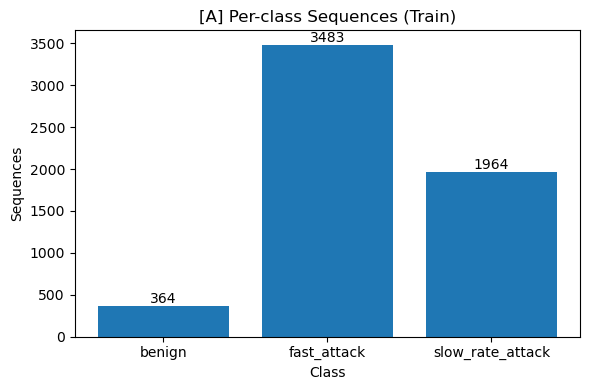

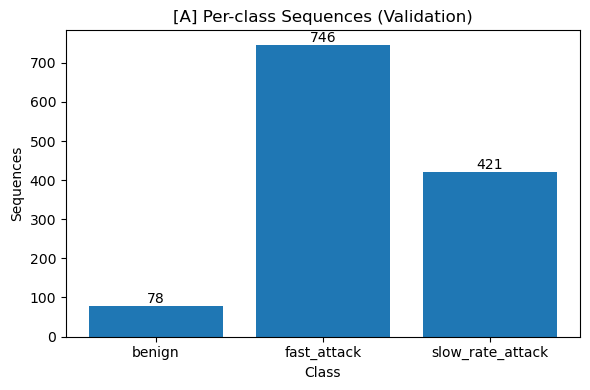

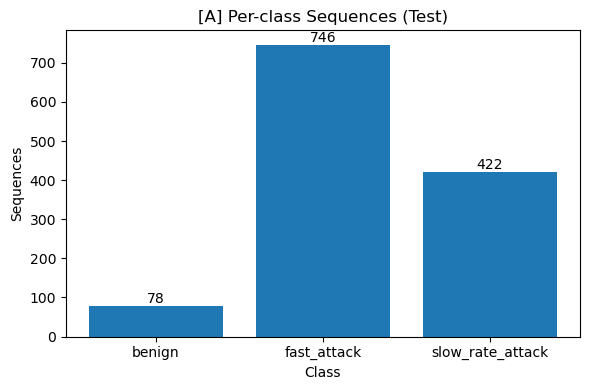


=== [Diag1/B] Per-class counts ===
Train : {np.str_('benign'): np.int64(364), np.str_('fast_attack'): np.int64(3483), np.str_('slow_rate_attack'): np.int64(1964)}
Val   : {np.str_('benign'): np.int64(78), np.str_('fast_attack'): np.int64(746), np.str_('slow_rate_attack'): np.int64(421)}
Test  : {np.str_('benign'): np.int64(68), np.str_('fast_attack'): np.int64(1105), np.str_('slow_rate_attack'): np.int64(1722)}


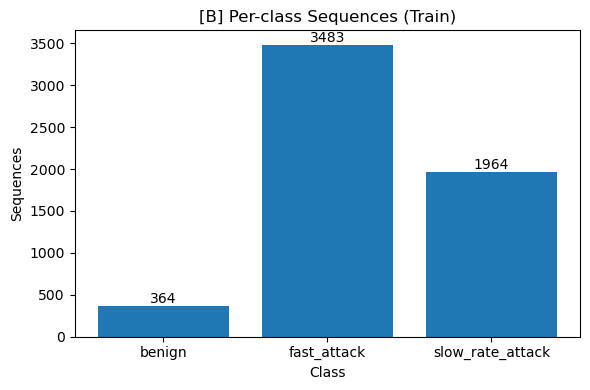

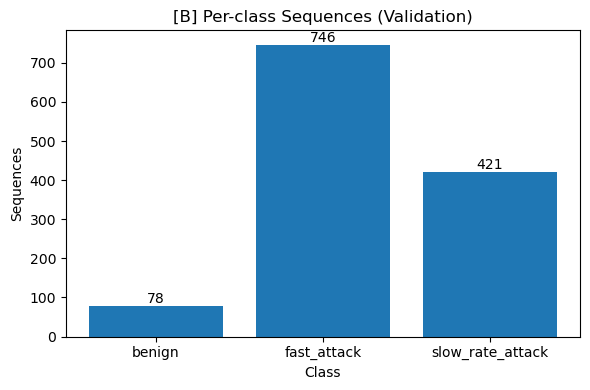

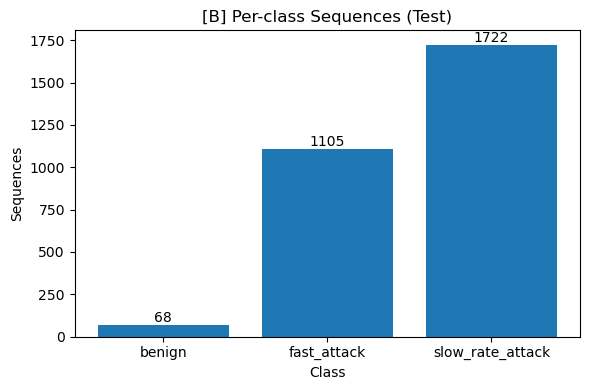


=== [Diag1/C] Per-class counts ===
Train : {np.str_('benign'): np.int64(412), np.str_('fast_attack'): np.int64(4256), np.str_('slow_rate_attack'): np.int64(3169)}
Val   : {np.str_('benign'): np.int64(88), np.str_('fast_attack'): np.int64(912), np.str_('slow_rate_attack'): np.int64(679)}
Test  : {np.str_('benign'): np.int64(88), np.str_('fast_attack'): np.int64(912), np.str_('slow_rate_attack'): np.int64(681)}


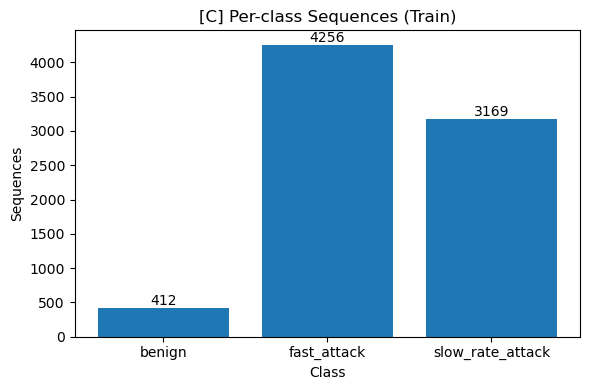

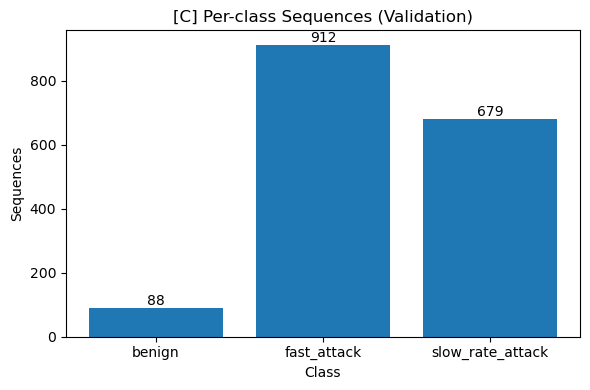

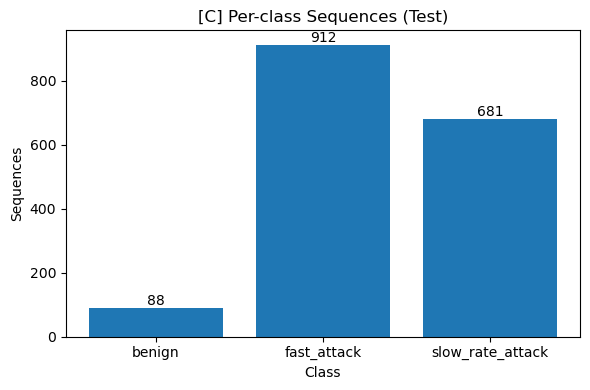

In [17]:
# === DIAGNOSTIC 1: Per-class sequence counts across splits (supports Config-A, B, C) ===
import numpy as np
import matplotlib.pyplot as plt

def _class_counts_human(y, enc):
    if y is None or len(y) == 0 or enc is None:
        return {}
    u, c = np.unique(y, return_counts=True)
    try:
        names = enc.inverse_transform(u)
        return dict(zip(names, c))
    except:
        return dict(zip([f"class_{i}" for i in u], c))

def _plot_split_counts(counts_dict, title):
    if not counts_dict:
        print(f"No data for {title}")
        return
    labels = list(counts_dict.keys())
    values = [counts_dict[k] for k in labels]
    plt.figure(figsize=(6,4))
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Sequences")
    for i, v in enumerate(values):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def _diag_counts_for_sequences(sequences_dict, tag="A"):
    if sequences_dict is None or not isinstance(sequences_dict, dict):
        print(f"[Diag1/{tag}] No sequences dict found; skipping.")
        return
        
    X_train = sequences_dict.get('X_train', np.array([]))
    y_train = sequences_dict.get('y_train', np.array([]))
    X_val   = sequences_dict.get('X_val',   np.array([]))
    y_val   = sequences_dict.get('y_val',   np.array([]))
    X_test  = sequences_dict.get('X_test',  np.array([]))
    y_test  = sequences_dict.get('y_test',  np.array([]))
    enc     = sequences_dict.get('label_encoder', None)

    print(f"\n=== [Diag1/{tag}] Per-class counts ===")
    train_counts = _class_counts_human(y_train, enc)
    val_counts   = _class_counts_human(y_val,   enc)
    test_counts  = _class_counts_human(y_test,  enc)

    print("Train :", train_counts)
    print("Val   :", val_counts)
    print("Test  :", test_counts)

    _plot_split_counts(train_counts, f"[{tag}] Per-class Sequences (Train)")
    _plot_split_counts(val_counts,   f"[{tag}] Per-class Sequences (Validation)")
    _plot_split_counts(test_counts,  f"[{tag}] Per-class Sequences (Test)")

# Try to find sequences in multiple ways
print("=== DIAGNOSTIC 1: Sequence Class Counts ===")

# Method 1: Direct sequences variables
sequences_A = globals().get("sequences_A", None)
sequences_B = globals().get("sequences_B", None) 
sequences_C = globals().get("sequences_C", None)

# Method 2: Export bundles
bundle_A = globals().get("export_bundle_A", None)
bundle_B = globals().get("export_bundle_B", None)
bundle_C = globals().get("export_bundle_C", None)

# Process sequences_A
if sequences_A is not None:
    _diag_counts_for_sequences(sequences_A, tag="A")
elif bundle_A is not None and 'sequences' in bundle_A:
    _diag_counts_for_sequences(bundle_A['sequences'], tag="A")
else:
    print("[Diag1/A] No sequences_A or bundle_A found")

# Process sequences_B  
if sequences_B is not None:
    _diag_counts_for_sequences(sequences_B, tag="B")
elif bundle_B is not None and 'sequences' in bundle_B:
    _diag_counts_for_sequences(bundle_B['sequences'], tag="B")
else:
    print("[Diag1/B] No sequences_B or bundle_B found")

# Process sequences_C
if sequences_C is not None:
    _diag_counts_for_sequences(sequences_C, tag="C")
elif bundle_C is not None and 'sequences' in bundle_C:
    _diag_counts_for_sequences(bundle_C['sequences'], tag="C")
else:
    print("[Diag1/C] No sequences_C or bundle_C found")

# Fallback to globals if nothing found
if (sequences_A is None and sequences_B is None and sequences_C is None and 
    bundle_A is None and bundle_B is None and bundle_C is None and 
    'X_train' in globals()):
    print("[Diag1] Using globals fallback")
    fallback_sequences = {
        "X_train": globals().get('X_train', np.array([])), 
        "y_train": globals().get('y_train', np.array([])),
        "X_val": globals().get('X_val', np.array([])), 
        "y_val": globals().get('y_val', np.array([])),
        "X_test": globals().get('X_test', np.array([])), 
        "y_test": globals().get('y_test', np.array([])),
        "label_encoder": globals().get('label_enc', None)
    }
    _diag_counts_for_sequences(fallback_sequences, tag="GLOBAL")

In [18]:
# === Full Metrics Visualization: Accuracy/Precision/Recall/AUC/ErrorRates/Thresholds (A, B, C, and Comparisons) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, accuracy_score,
    roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
)

# ------------ Helpers ------------
def _to_2col_binary_probs(p1):
    p1 = np.asarray(p1).reshape(-1)
    p1 = np.clip(p1, 0.0, 1.0)
    return np.column_stack([1.0 - p1, p1])

def _fix_probs_shape(probs, n_classes):
    probs = np.asarray(probs)
    if probs.ndim == 1:
        probs = probs.reshape(-1, 1)
    if n_classes == 2 and probs.shape[1] == 1:
        probs = _to_2col_binary_probs(probs[:, 0])
    return probs

def _one_hot(y, n_classes):
    y = np.asarray(y, dtype=int)
    N = y.shape[0]
    Y = np.zeros((N, n_classes), dtype=int)
    valid = (y >= 0) & (y < n_classes)
    idx = np.where(valid)[0]
    if idx.size:
        Y[idx, y[idx]] = 1
    return Y

def _per_class_rates(cm, classes):
    rows=[]
    for k in range(len(classes)):
        TP=cm[k,k]; FN=cm[k,:].sum()-TP; FP=cm[:,k].sum()-TP; TN=cm.sum()-TP-FN-FP
        FPR=FP/(FP+TN) if FP+TN>0 else 0.0
        FNR=FN/(TP+FN) if TP+FN>0 else 0.0
        TPR=TP/(TP+FN) if TP+FN>0 else 0.0
        rows.append({"Class":classes[k],"TPR":TPR,"FPR":FPR,"FNR":FNR})
    return pd.DataFrame(rows)

def _pick_focus_class(classes):
    return "slow_rate_attack" if "slow_rate_attack" in classes else classes[-1]

def _macro_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1

def evaluate_config_full(results, bundle, title=""):
    """Compute & plot full metrics suite for a single configuration."""
    assert results and bundle
    y_test = bundle['y_test']; label_enc = bundle['label_encoder']
    classes = list(label_enc.classes_); num_classes = len(classes)
    model_names = list(results.keys())
    y_test_bin = _one_hot(y_test, num_classes)
    focus_class = _pick_focus_class(classes)
    focus_idx = classes.index(focus_class)

    # --- Macro metrics table ---
    macro_rows=[]
    for m in model_names:
        y_pred=np.asarray(results[m]["test_pred"])
        acc, mprec, mrec, mf1 = _macro_metrics(y_test, y_pred)
        macro_rows.append({"Model":m,"Accuracy":acc,"Macro Precision":mprec,"Macro Recall":mrec,"Macro F1":mf1})
    macro_df = pd.DataFrame(macro_rows).sort_values("Macro F1", ascending=False)
    print(f"\n===== {title} — Macro Metrics (Test) =====")
    display(macro_df)

    # --- Confusion matrices + per-class metrics ---
    per_class_rows=[]
    n_cols = min(3, len(model_names))
    n_rows = int(np.ceil(len(model_names)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.6*n_cols, 4.2*n_rows))
    if n_rows*n_cols == 1: axes = np.array([[axes]])
    elif n_rows == 1: axes = np.array([axes])
    axes = axes.flatten()
    for idx, m in enumerate(model_names):
        y_pred = np.asarray(results[m]["test_pred"])
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
        ax = axes[idx]
        im = ax.imshow(cm, interpolation="nearest", aspect="auto")
        ax.set_title(m)
        ax.set_xticks(range(num_classes)); ax.set_xticklabels(classes, rotation=45, ha="right")
        ax.set_yticks(range(num_classes)); ax.set_yticklabels(classes)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        for r in range(num_classes):
            for c in range(num_classes):
                ax.text(c, r, cm[r, c], ha="center", va="center", fontsize=8)
        prec, rec, f1, sup = precision_recall_fscore_support(
            y_test, y_pred, labels=np.arange(num_classes), zero_division=0
        )
        for k,cls in enumerate(classes):
            per_class_rows.append({"Model":m,"Class":cls,"Precision":prec[k],"Recall":rec[k],"F1":f1[k],"Support":sup[k]})
    for k in range(len(model_names), len(axes)): axes[k].axis("off")
    fig.suptitle(f"{title} — Confusion Matrices", y=1.02); plt.tight_layout(); plt.show()

    percls_df = pd.DataFrame(per_class_rows).sort_values(["Class","F1"], ascending=[True, False])
    print(f"=== {title} — Per-class metrics (Test) ===")
    display(percls_df)

    # --- Per-class F1 grouped bars ---
    piv = percls_df.pivot(index="Class", columns="Model", values="F1").reindex(classes)
    x=np.arange(len(classes)); w=0.8/max(1,len(piv.columns))
    plt.figure(figsize=(10,5))
    for j,m in enumerate(piv.columns):
        plt.bar(x+j*w-(len(piv.columns)-1)*w/2, piv[m], w, label=m)
    plt.xticks(x, classes); plt.ylabel("F1 (Test)")
    plt.title(f"{title} — Per-Class F1 by Model"); plt.legend(); plt.tight_layout(); plt.show()

    # --- PR & ROC curves for focus class ---
    # PR
    plotted_pr=False
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        # skip if focus class absent in y_test
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        pr, rc, _ = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        ap = average_precision_score(y_test_bin[:,focus_idx], probs[:,focus_idx])
        if not plotted_pr:
            plt.figure(figsize=(7,5)); plotted_pr=True
        plt.plot(rc, pr, label=f"{m} (AP={ap:.3f})")
    if plotted_pr:
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"{title} — PR (Test), class: {focus_class}"); plt.legend(); plt.tight_layout(); plt.show()

    # ROC
    plotted_roc=False
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        fpr, tpr, _ = roc_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        ra = auc(fpr, tpr)
        if not plotted_roc:
            plt.figure(figsize=(7,5)); plotted_roc=True
        plt.plot(fpr, tpr, label=f"{m} (AUC={ra:.3f})")
    if plotted_roc:
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"{title} — ROC (Test), class: {focus_class}")
        plt.legend(); plt.tight_layout(); plt.show()

    # --- PR-AUC & ROC-AUC tables (macro + per-class) ---
    auc_rows=[]
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None:
            auc_rows.append({"Model":m,"Macro PR-AUC":np.nan,"Macro ROC-AUC":np.nan}); continue
        probs = _fix_probs_shape(probs, num_classes)
        pr_aucs, roc_aucs = {}, {}
        for i,cls in enumerate(classes):
            if y_test_bin[:,i].max()==y_test_bin[:,i].min():
                pr_aucs[cls]=np.nan; roc_aucs[cls]=np.nan; continue
            pr_aucs[cls]=average_precision_score(y_test_bin[:,i], probs[:,i])
            roc_aucs[cls]=roc_auc_score(y_test_bin[:,i], probs[:,i])
        auc_rows.append({
            "Model": m,
            "Macro PR-AUC": np.nanmean(list(pr_aucs.values())),
            "Macro ROC-AUC": np.nanmean(list(roc_aucs.values())),
            **{f"PR-AUC/{k}":v for k,v in pr_aucs.items()},
            **{f"ROC-AUC/{k}":v for k,v in roc_aucs.items()}
        })
    auc_df = pd.DataFrame(auc_rows).sort_values("Macro PR-AUC", ascending=False)
    print(f"=== {title} — AUC Summary ===")
    display(auc_df)

    # --- Error rates (FPR/FNR/TPR) ---
    err_rows=[]
    for m in model_names:
        y_pred = np.asarray(results[m]["test_pred"])
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
        df = _per_class_rates(cm, classes)
        df["Model"]=m
        err_rows.append(df)
    err_df = pd.concat(err_rows, ignore_index=True)
    print(f"=== {title} — Per-class Error Rates (Test) ===")
    display(err_df)

    # --- Threshold sweeps (focus class) + best thresholds by max-F1 ---
    best_rows=[]
    for ylabel in ["Precision","Recall"]:
        plt.figure(figsize=(7,5)); plotted=False
        for m in model_names:
            probs = results[m].get("test_probs", None)
            if probs is None: continue
            probs = _fix_probs_shape(probs, num_classes)
            if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
            pr, rc, th = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
            if ylabel=="Precision":
                plt.plot(th, pr[:-1], label=f"{m} — Prec"); plotted=True
            else:
                plt.plot(th, rc[:-1], label=f"{m} — Recall"); plotted=True
        if plotted:
            plt.xlabel("Threshold"); plt.ylabel(ylabel)
            plt.title(f"{title} — Threshold→{ylabel} ({focus_class})")
            plt.legend(); plt.tight_layout(); plt.show()

    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        pr, rc, th = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        denom = np.clip(pr[:-1] + rc[:-1], 1e-9, None)
        f1 = 2 * pr[:-1] * rc[:-1] / denom
        j = int(np.argmax(f1))
        best_rows.append({"Model":m,"BestThresh(F1)":float(th[j]),"BestF1":float(f1[j]),"Prec@best":float(pr[j]),"Rec@best":float(rc[j])})
    best_df = pd.DataFrame(best_rows).sort_values("BestF1", ascending=False) if best_rows else pd.DataFrame()
    print(f"=== {title} — Best Threshold by Max F1 ({focus_class}) ===")
    display(best_df if not best_df.empty else pd.DataFrame({"Info":["No eligible models for threshold sweep."]}))

    return {
        "macro": macro_df,
        "perclass": percls_df,
        "auc": auc_df,
        "err": err_df,
        "best_thresh": best_df,
        "classes": classes,
        "focus_class": focus_class
    }

# ========== Run for Config A, B, and C ==========
resA = resB = resC = None

if 'results_A' in globals() and results_A:
    bundleA = globals().get("sequences_A", globals().get("export_bundle_A", globals().get("export_bundle")))
    if bundleA:
        resA = evaluate_config_full(results_A, bundleA, title="Config A (Px + PWNJUTSU)")

if 'results_B' in globals() and results_B:
    bundleB = globals().get("sequences_B", globals().get("export_bundle_B"))
    if bundleB:
        resB = evaluate_config_full(results_B, bundleB, title="Config B (Px + PWNJUTSU → LogHub)")

if 'results_C' in globals() and results_C:
    bundleC = globals().get("sequences_C")
    if bundleC:
        resC = evaluate_config_full(results_C, bundleC, title="Config C (Mixed Dataset Training)")

# ========== Multi-Config Comparisons ==========
configs = []
if resA is not None: configs.append(("A", resA))
if resB is not None: configs.append(("B", resB))
if resC is not None: configs.append(("C", resC))

if len(configs) >= 2:
    print(f"\n===== Multi-Config Comparison ({len(configs)} configs) =====")
    
    # Macro metrics comparison
    macro_dfs = []
    for name, res in configs:
        df = res["macro"].copy()
        df["Config"] = name
        macro_dfs.append(df)
    
    combined_macro = pd.concat(macro_dfs, ignore_index=True)
    macro_pivot = combined_macro.pivot(index="Model", columns="Config", values="Macro F1")
    
    print("\n=== Macro F1 Comparison Across Configs ===")
    display(macro_pivot.sort_values(macro_pivot.columns[-1], ascending=False))
    
    # AUC comparison
    auc_dfs = []
    for name, res in configs:
        df = res["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]].copy()
        df["Config"] = name
        auc_dfs.append(df)
    
    combined_auc = pd.concat(auc_dfs, ignore_index=True)
    
    print("\n=== AUC Comparison Across Configs ===")
    for metric in ["Macro PR-AUC", "Macro ROC-AUC"]:
        auc_pivot = combined_auc.pivot(index="Model", columns="Config", values=metric)
        print(f"\n{metric}:")
        display(auc_pivot.sort_values(auc_pivot.columns[-1], ascending=False))

# ========== Pairwise Comparisons (A vs B, A vs C, B vs C) ==========
def compare_configs(res1, res2, name1, name2):
    """Compare two configurations side by side."""
    print(f"\n===== {name1} vs {name2}: Macro Metrics (Δ = {name2} − {name1}) =====")
    
    comp_macro = pd.merge(res1["macro"], res2["macro"], on="Model", suffixes=(f"_{name1}", f"_{name2}"))
    for k in ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]:
        comp_macro[f"Δ {k}"] = comp_macro[f"{k}_{name2}"] - comp_macro[f"{k}_{name1}"]
    display(comp_macro.sort_values("Δ Macro F1", ascending=False))
    
    # AUC comparison
    comp_auc = pd.merge(res1["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]],
                        res2["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]],
                        on="Model", suffixes=(f"_{name1}", f"_{name2}"))
    comp_auc["Δ PR-AUC"] = comp_auc[f"Macro PR-AUC_{name2}"] - comp_auc[f"Macro PR-AUC_{name1}"]
    comp_auc["Δ ROC-AUC"] = comp_auc[f"Macro ROC-AUC_{name2}"] - comp_auc[f"Macro ROC-AUC_{name1}"]
    print(f"\n===== {name1} vs {name2}: Macro AUCs (Δ = {name2} − {name1}) =====")
    display(comp_auc.sort_values("Δ PR-AUC", ascending=False))

# Run pairwise comparisons
if resA is not None and resB is not None:
    compare_configs(resA, resB, "A", "B")

if resA is not None and resC is not None:
    compare_configs(resA, resC, "A", "C")

if resB is not None and resC is not None:
    compare_configs(resB, resC, "B", "C")

# ========== Best Model Overlay (Focus Class) ==========
if len(configs) >= 2:
    # Check if all configs have same focus class
    focus_classes = [res["focus_class"] for _, res in configs]
    if len(set(focus_classes)) == 1:
        focus = focus_classes[0]
        print(f"\n===== Best Model Overlay ({focus}) =====")
        
        # Get best models from each config
        best_models = []
        for name, res in configs:
            best_model = res["macro"].sort_values("Macro F1", ascending=False)["Model"].iloc[0]
            best_models.append((name, best_model, res))
        
        # PR curves overlay
        plt.figure(figsize=(10, 6))
        for name, model, res in best_models:
            if f'results_{name}' in globals():
                results = globals()[f'results_{name}']
                if model in results:
                    probs = results[model].get("test_probs")
                    if probs is not None:
                        bundle = globals().get(f"sequences_{name}")
                        if bundle:
                            y_test = bundle['y_test']
                            classes = list(bundle['label_encoder'].classes_)
                            focus_idx = classes.index(focus)
                            y_test_bin = _one_hot(y_test, len(classes))
                            probs = _fix_probs_shape(probs, len(classes))
                            
                            if y_test_bin[:, focus_idx].max() != y_test_bin[:, focus_idx].min():
                                pr, rc, _ = precision_recall_curve(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                ap = average_precision_score(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                plt.plot(rc, pr, label=f"{name}:{model} (AP={ap:.3f})", linewidth=2)
        
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"Best Models PR Comparison — {focus}")
        plt.legend(); plt.tight_layout(); plt.show()
        
        # ROC curves overlay
        plt.figure(figsize=(10, 6))
        for name, model, res in best_models:
            if f'results_{name}' in globals():
                results = globals()[f'results_{name}']
                if model in results:
                    probs = results[model].get("test_probs")
                    if probs is not None:
                        bundle = globals().get(f"sequences_{name}")
                        if bundle:
                            y_test = bundle['y_test']
                            classes = list(bundle['label_encoder'].classes_)
                            focus_idx = classes.index(focus)
                            y_test_bin = _one_hot(y_test, len(classes))
                            probs = _fix_probs_shape(probs, len(classes))
                            
                            if y_test_bin[:, focus_idx].max() != y_test_bin[:, focus_idx].min():
                                fpr, tpr, _ = roc_curve(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                ra = auc(fpr, tpr)
                                plt.plot(fpr, tpr, label=f"{name}:{model} (AUC={ra:.3f})", linewidth=2)
        
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"Best Models ROC Comparison — {focus}")
        plt.legend(); plt.tight_layout(); plt.show()
    else:
        print(f"[INFO] Focus classes differ across configs: {dict(zip([name for name, _ in configs], focus_classes))}; skipping overlay curves.")

print(f"\n=== Evaluation Complete ===")
print(f"Configurations evaluated: {[name for name, _ in configs]}")
if not configs:
    print("No configurations found. Run training pipeline first.")


=== Evaluation Complete ===
Configurations evaluated: []
No configurations found. Run training pipeline first.


=== DIAGNOSTIC 2: Domain Shift Analysis ===
[Diag2/A] Train: 5811 sequences from proxmox
[Diag2/A] Val: 1245 sequences from proxmox
[Diag2/A] Test: 1246 sequences from proxmox
[Diag2/A] Total sequences: (8302, 12, 6)
[Diag2/A] Datasets present: ['proxmox']
[Diag2/A] Only one dataset type. Showing feature distributions.


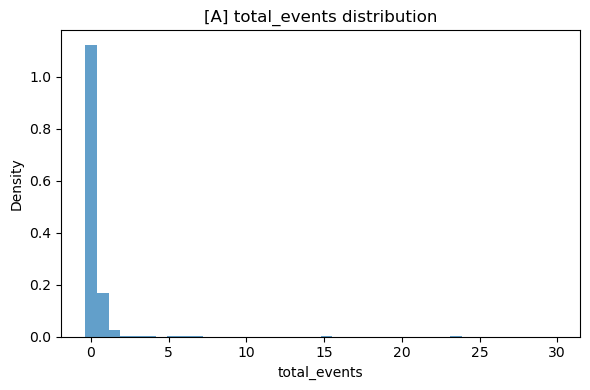

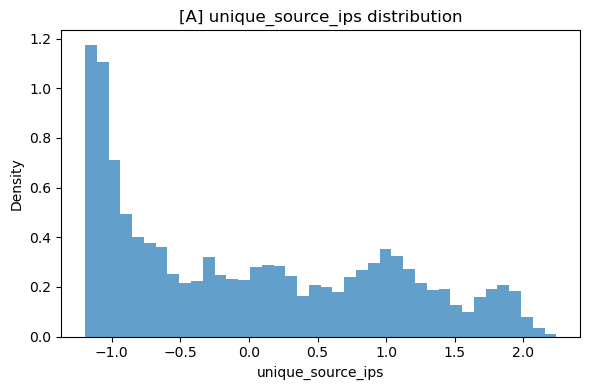

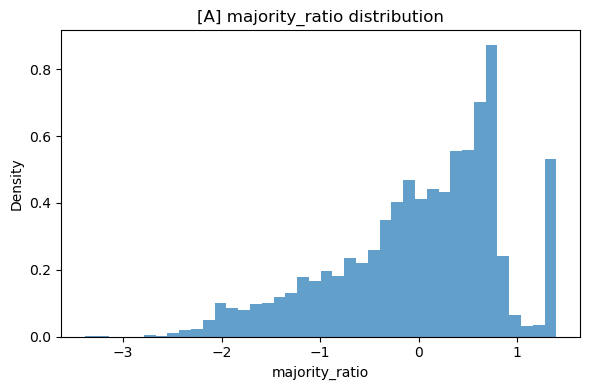

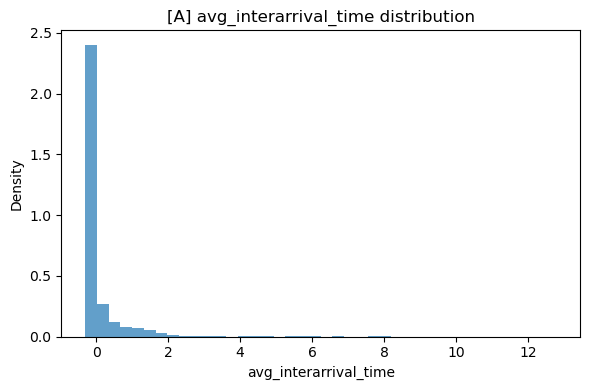

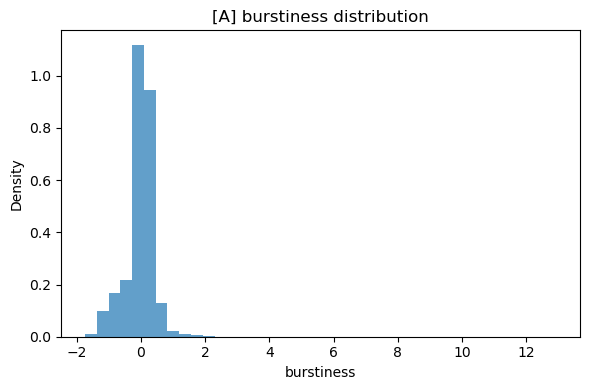

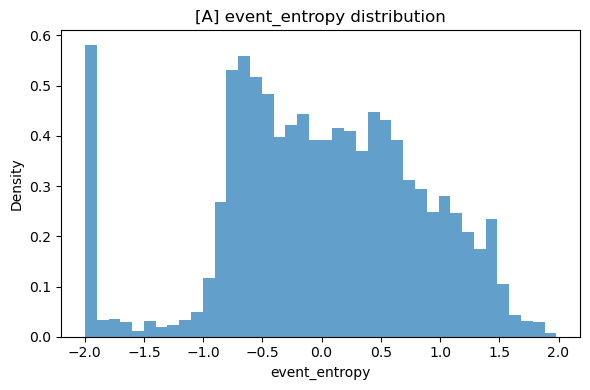

[Diag2/B] Train: 5811 sequences from proxmox
[Diag2/B] Val: 1245 sequences from proxmox
[Diag2/B] Test: 2895 sequences from loghub
[Diag2/B] Total sequences: (9951, 12, 6)
[Diag2/B] Datasets present: ['loghub' 'proxmox']

[Diag2/B] Comparing: loghub (n=2895) vs proxmox (n=7056)
Feature                loghub μ   loghub σ  proxmox μ  proxmox σ       KS    p-val
total_events             -0.249      0.175      0.004      0.873    0.357 2.6e-233
unique_source_ips        -1.089      0.044      0.005      0.983    0.749        0
majority_ratio           -1.039      0.909      0.005      0.837    0.591 3.3e-321
avg_interarrival_tim     -0.050      0.326     -0.001      0.652    0.126  1.2e-28
burstiness                0.086      0.653     -0.000      0.597    0.198  1.5e-70
event_entropy             0.389      0.771     -0.005      0.857    0.337 2.9e-207

Top 3 most different features:
  unique_source_ips: KS=0.749, p=0


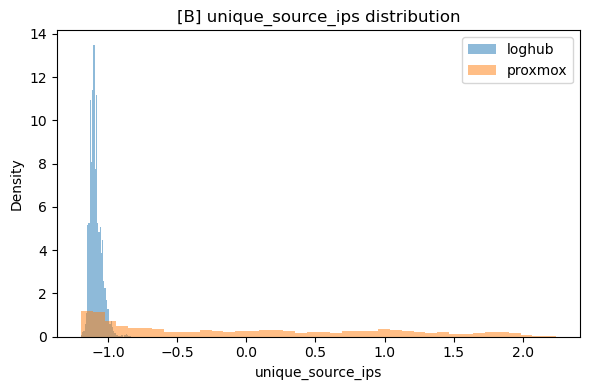

  majority_ratio: KS=0.591, p=3.3e-321


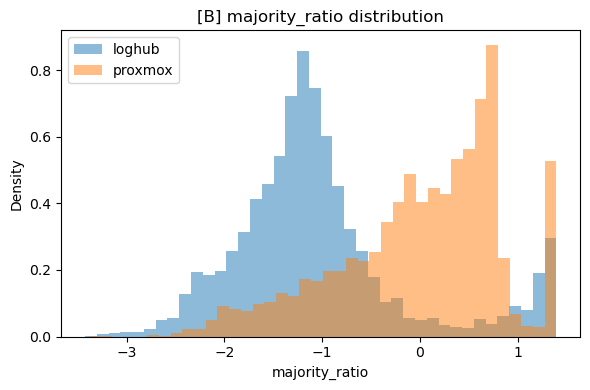

  total_events: KS=0.357, p=2.6e-233


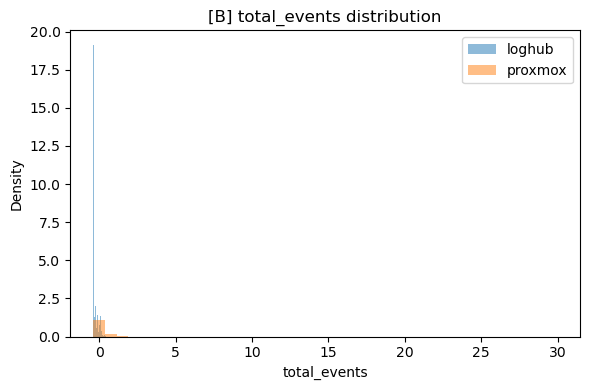

[Diag2/C] Train: 7837 sequences from mixed
[Diag2/C] Val: 1679 sequences from mixed
[Diag2/C] Test: 1681 sequences from mixed
[Diag2/C] Total sequences: (11197, 12, 6)
[Diag2/C] Datasets present: ['mixed']
[Diag2/C] Only one dataset type. Showing feature distributions.


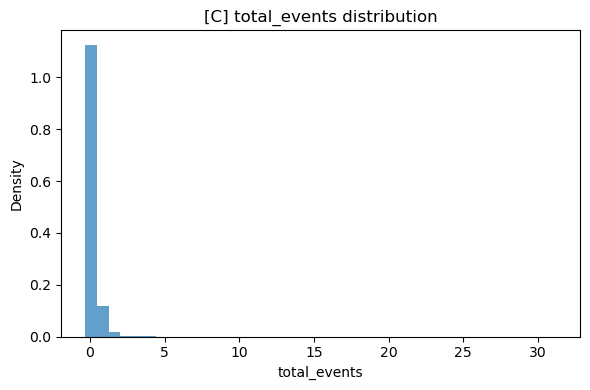

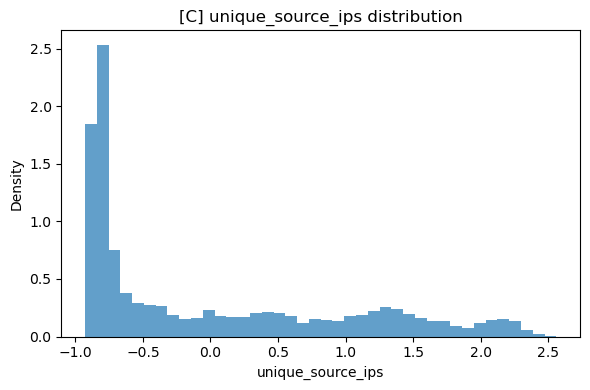

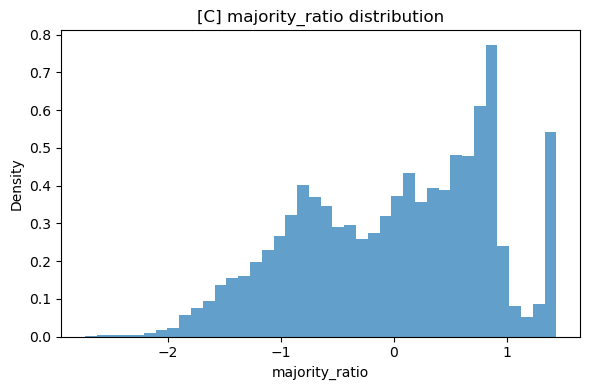

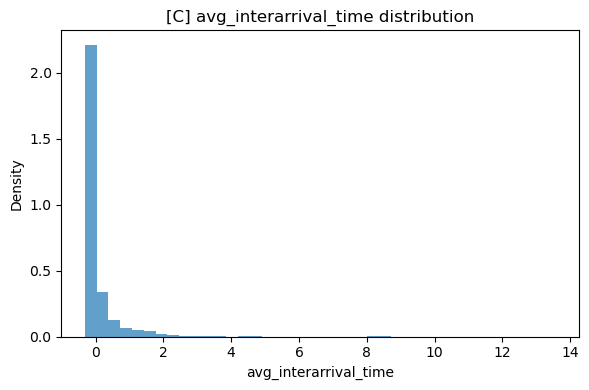

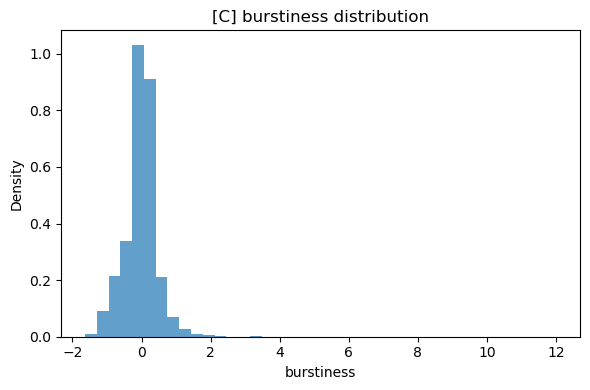

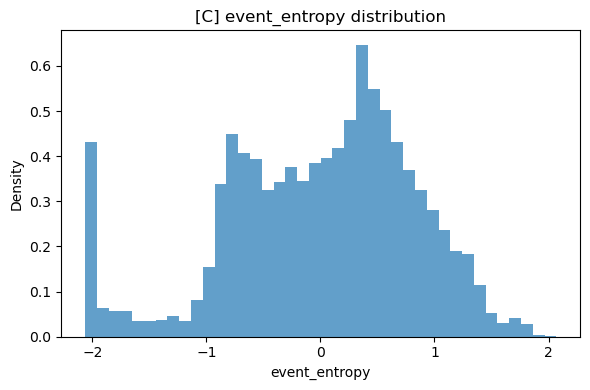

In [19]:
# === DIAGNOSTIC 2: Domain shift between datasets (supports Config-A, B, C) ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

def _infer_dataset_array(length, default_name):
    """Return array([default_name]*length)."""
    return np.array([default_name] * int(length))

def _domain_shift_for_sequences(sequences_dict, tag="A"):
    if sequences_dict is None or not isinstance(sequences_dict, dict):
        print(f"[Diag2/{tag}] No sequences dict; skip.")
        return
        
    X_train = sequences_dict.get('X_train', np.array([]))
    X_val   = sequences_dict.get('X_val',   np.array([]))
    X_test  = sequences_dict.get('X_test',  np.array([]))
    
    # Use common features
    feat_cols = [
        'total_events', 'unique_source_ips', 'majority_ratio',
        'avg_interarrival_time', 'burstiness', 'event_entropy'
    ]

    # Build X_all and ds_all with dataset inference
    all_X = []
    all_ds = []

    # TRAIN
    if isinstance(X_train, np.ndarray) and X_train.size > 0:
        if tag == "C":
            ds_tr = _infer_dataset_array(len(X_train), "mixed")
        else:
            ds_tr = _infer_dataset_array(len(X_train), "proxmox")
        all_X.append(X_train)
        all_ds.append(ds_tr)
        print(f"[Diag2/{tag}] Train: {len(X_train)} sequences from {ds_tr[0]}")

    # VAL
    if isinstance(X_val, np.ndarray) and X_val.size > 0:
        if tag == "C":
            ds_va = _infer_dataset_array(len(X_val), "mixed")
        else:
            ds_va = _infer_dataset_array(len(X_val), "proxmox")
        all_X.append(X_val)
        all_ds.append(ds_va)
        print(f"[Diag2/{tag}] Val: {len(X_val)} sequences from {ds_va[0]}")

    # TEST
    if isinstance(X_test, np.ndarray) and X_test.size > 0:
        if tag == "B":
            ds_te = _infer_dataset_array(len(X_test), "loghub")
        elif tag == "C":
            ds_te = _infer_dataset_array(len(X_test), "mixed")
        else:
            ds_te = _infer_dataset_array(len(X_test), "proxmox")
        all_X.append(X_test)
        all_ds.append(ds_te)
        print(f"[Diag2/{tag}] Test: {len(X_test)} sequences from {ds_te[0]}")

    if not all_X:
        print(f"[Diag2/{tag}] No sequences available.")
        return

    X_all = np.concatenate(all_X, axis=0)
    ds_all = np.concatenate(all_ds, axis=0)

    print(f"[Diag2/{tag}] Total sequences: {X_all.shape}")

    # seq_feats: mean over time, shape (N,F)
    seq_feats = X_all.mean(axis=1)

    datasets_present = np.unique(ds_all)
    print(f"[Diag2/{tag}] Datasets present: {datasets_present}")
    
    if len(datasets_present) < 2:
        print(f"[Diag2/{tag}] Only one dataset type. Showing feature distributions.")
        
        # Show feature distributions for single dataset
        for i, fname in enumerate(feat_cols[:min(6, seq_feats.shape[1])]):
            plt.figure(figsize=(6,4))
            plt.hist(seq_feats[:, i], bins=40, alpha=0.7, density=True)
            plt.title(f"[{tag}] {fname} distribution")
            plt.xlabel(fname)
            plt.ylabel("Density")
            plt.tight_layout()
            plt.show()
        return

    # Compare datasets if multiple present
    pairs = []
    for i in range(len(datasets_present)):
        for j in range(i+1, len(datasets_present)):
            pairs.append((datasets_present[i], datasets_present[j]))

    for a_name, b_name in pairs:
        a_mask = (ds_all == a_name)
        b_mask = (ds_all == b_name)
        A = seq_feats[a_mask]
        B = seq_feats[b_mask]
        
        print(f"\n[Diag2/{tag}] Comparing: {a_name} (n={len(A)}) vs {b_name} (n={len(B)})")
        
        # Feature comparison table
        print("{:<20} {:>10} {:>10} {:>10} {:>10} {:>8} {:>8}".format(
            "Feature", f"{a_name[:8]} μ", f"{a_name[:8]} σ", f"{b_name[:8]} μ", f"{b_name[:8]} σ", "KS", "p-val"
        ))
        
        rows = []
        for j, fname in enumerate(feat_cols[:min(len(feat_cols), seq_feats.shape[1])]):
            if j < seq_feats.shape[1]:
                a_vals = A[:, j]
                b_vals = B[:, j]
                a_mean, a_std = float(np.mean(a_vals)), float(np.std(a_vals))
                b_mean, b_std = float(np.mean(b_vals)), float(np.std(b_vals))
                ks_stat, p_val = ks_2samp(a_vals, b_vals)
                rows.append((fname, a_mean, a_std, b_mean, b_std, ks_stat, p_val))
                print("{:<20} {:>10.3f} {:>10.3f} {:>10.3f} {:>10.3f} {:>8.3f} {:>8.2g}".format(
                    fname[:20], a_mean, a_std, b_mean, b_std, ks_stat, p_val
                ))

        # Plot top 3 most different features
        if rows:
            rows_sorted = sorted(rows, key=lambda r: r[5], reverse=True)
            print(f"\nTop 3 most different features:")
            for fname, a_mean, a_std, b_mean, b_std, ks_stat, p_val in rows_sorted[:3]:
                print(f"  {fname}: KS={ks_stat:.3f}, p={p_val:.2g}")
                
                # Plot this feature
                j = feat_cols.index(fname) if fname in feat_cols else -1
                if j >= 0 and j < seq_feats.shape[1]:
                    plt.figure(figsize=(6,4))
                    bins = 40
                    plt.hist(A[:, j], bins=bins, alpha=0.5, density=True, label=str(a_name))
                    plt.hist(B[:, j], bins=bins, alpha=0.5, density=True, label=str(b_name))
                    plt.title(f"[{tag}] {fname} distribution")
                    plt.xlabel(fname)
                    plt.ylabel("Density")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

# Run diagnostics for all available sequences
print("=== DIAGNOSTIC 2: Domain Shift Analysis ===")

# Try to find sequences in multiple ways
sequences_A = globals().get("sequences_A", None)
sequences_B = globals().get("sequences_B", None) 
sequences_C = globals().get("sequences_C", None)

bundle_A = globals().get("export_bundle_A", None)
bundle_B = globals().get("export_bundle_B", None)
bundle_C = globals().get("export_bundle_C", None)

# Process each config
configs_to_process = [
    ("A", sequences_A, bundle_A),
    ("B", sequences_B, bundle_B), 
    ("C", sequences_C, bundle_C)
]

processed_any = False
for tag, sequences, bundle in configs_to_process:
    if sequences is not None:
        _domain_shift_for_sequences(sequences, tag=tag)
        processed_any = True
    elif bundle is not None and 'sequences' in bundle:
        _domain_shift_for_sequences(bundle['sequences'], tag=tag)
        processed_any = True
    else:
        print(f"[Diag2/{tag}] No sequences or bundle found")

if not processed_any and 'X_train' in globals():
    print("[Diag2] Using globals fallback")
    fallback_sequences = {
        "X_train": globals().get('X_train', np.array([])), 
        "X_val": globals().get('X_val', np.array([])), 
        "X_test": globals().get('X_test', np.array([]))
    }
    _domain_shift_for_sequences(fallback_sequences, tag="GLOBAL")

=== DIAGNOSTIC 3: PCA Analysis ===
[Diag3/A] Combined shape: (8302, 12, 6)
[Diag3/A] Sequence features shape: (8302, 6)
[Diag3/A] PCA explained variance: [0.35879797 0.2697557 ]


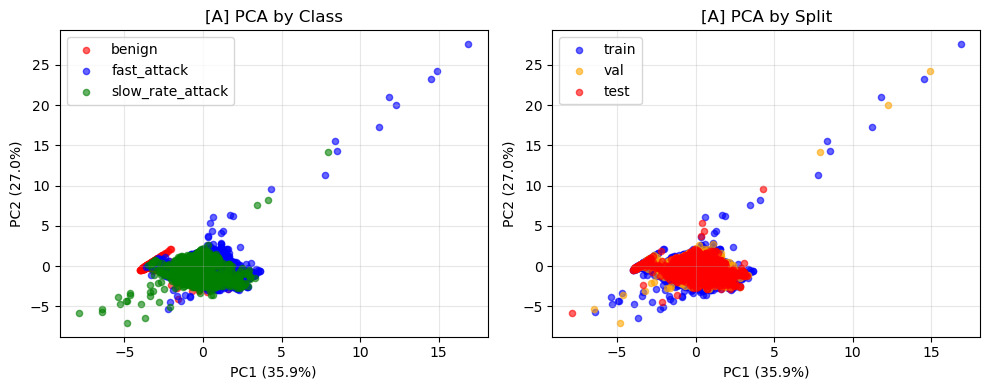


[Diag3/A] Summary:
  Total sequences: 8302
  Classes: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
  Splits: train=5811, val=1245, test=1246
[Diag3/B] Combined shape: (9951, 12, 6)
[Diag3/B] Sequence features shape: (9951, 6)
[Diag3/B] PCA explained variance: [0.3281789  0.27124727]


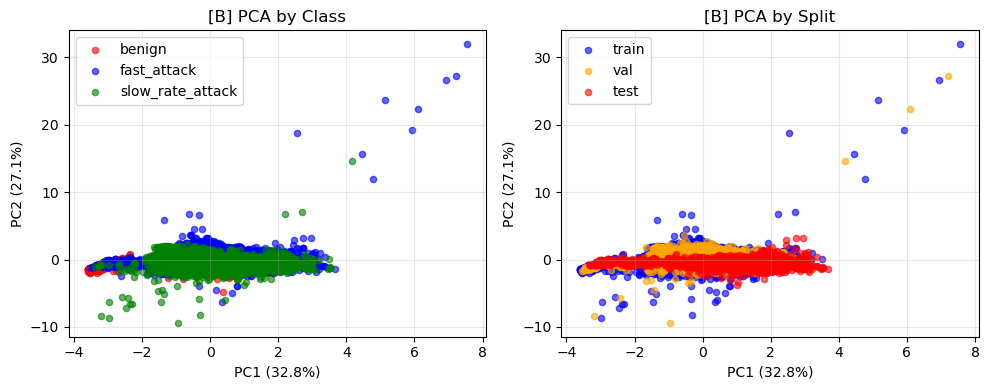


[Diag3/B] Summary:
  Total sequences: 9951
  Classes: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
  Splits: train=5811, val=1245, test=2895
[Diag3/C] Combined shape: (11197, 12, 6)
[Diag3/C] Sequence features shape: (11197, 6)
[Diag3/C] PCA explained variance: [0.32884386 0.27192706]


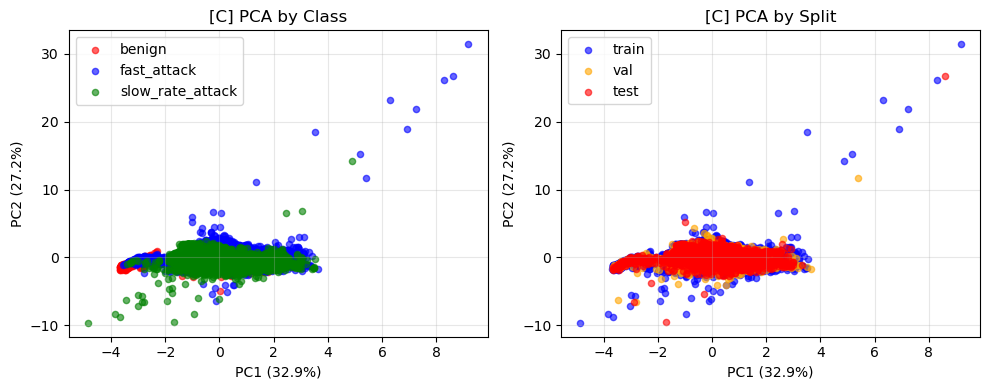


[Diag3/C] Summary:
  Total sequences: 11197
  Classes: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
  Splits: train=7837, val=1679, test=1681


In [20]:
# === DIAGNOSTIC 3: PCA scatter of sequence-level features (supports Config-A, B, C) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def _pca_diag_for_sequences(sequences_dict, tag="A"):
    if sequences_dict is None or not isinstance(sequences_dict, dict):
        print(f"[Diag3/{tag}] No sequences dict; skip.")
        return
        
    X_train = sequences_dict.get('X_train', np.array([]))
    y_train = sequences_dict.get('y_train', np.array([]))
    X_val   = sequences_dict.get('X_val',   np.array([]))
    y_val   = sequences_dict.get('y_val',   np.array([]))
    X_test  = sequences_dict.get('X_test',  np.array([]))
    y_test  = sequences_dict.get('y_test',  np.array([]))
    enc     = sequences_dict.get('label_encoder', None)

    # Combine all data
    all_X = []
    all_y = []
    all_split = []

    if isinstance(X_train, np.ndarray) and X_train.size > 0:
        all_X.append(X_train)
        all_y.append(y_train)
        all_split.extend(['train'] * len(X_train))

    if isinstance(X_val, np.ndarray) and X_val.size > 0:
        all_X.append(X_val)
        all_y.append(y_val)
        all_split.extend(['val'] * len(X_val))

    if isinstance(X_test, np.ndarray) and X_test.size > 0:
        all_X.append(X_test)
        all_y.append(y_test)
        all_split.extend(['test'] * len(X_test))

    if not all_X:
        print(f"[Diag3/{tag}] No data available.")
        return

    X_all = np.concatenate(all_X, axis=0)
    y_all = np.concatenate(all_y, axis=0)
    split_all = np.array(all_split)

    print(f"[Diag3/{tag}] Combined shape: {X_all.shape}")

    # Convert to sequence-level features (mean over time)
    seq_feats = X_all.mean(axis=1)
    print(f"[Diag3/{tag}] Sequence features shape: {seq_feats.shape}")

    if seq_feats.shape[1] < 2:
        print(f"[Diag3/{tag}] Need at least 2 features for PCA. Got {seq_feats.shape[1]}")
        return

    # Standardize features
    try:
        scaler = StandardScaler()
        seq_feats_scaled = scaler.fit_transform(seq_feats)
    except Exception as e:
        print(f"[Diag3/{tag}] Scaling failed: {e}")
        seq_feats_scaled = seq_feats

    # Apply PCA
    try:
        pca = PCA(n_components=min(2, seq_feats_scaled.shape[1]))
        X_pca = pca.fit_transform(seq_feats_scaled)
        print(f"[Diag3/{tag}] PCA explained variance: {pca.explained_variance_ratio_}")
    except Exception as e:
        print(f"[Diag3/{tag}] PCA failed: {e}")
        return

    # Get class names
    try:
        if enc is not None:
            unique_y = np.unique(y_all)
            class_names = enc.inverse_transform(unique_y)
            class_map = dict(zip(unique_y, class_names))
        else:
            unique_y = np.unique(y_all)
            class_map = {i: f"class_{i}" for i in unique_y}
    except Exception as e:
        print(f"[Diag3/{tag}] Class name mapping failed: {e}")
        unique_y = np.unique(y_all)
        class_map = {i: f"class_{i}" for i in unique_y}

    # Plot by class
    plt.figure(figsize=(10, 4))
    
    # Subplot 1: Color by class
    plt.subplot(1, 2, 1)
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, class_id in enumerate(unique_y):
        mask = (y_all == class_id)
        if np.any(mask):
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=colors[i % len(colors)], 
                       label=class_map[class_id], 
                       alpha=0.6, s=20)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title(f'[{tag}] PCA by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Color by split
    plt.subplot(1, 2, 2)
    split_colors = {'train': 'blue', 'val': 'orange', 'test': 'red'}
    for split_name in ['train', 'val', 'test']:
        mask = (split_all == split_name)
        if np.any(mask):
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=split_colors[split_name], 
                       label=split_name, 
                       alpha=0.6, s=20)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title(f'[{tag}] PCA by Split')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n[Diag3/{tag}] Summary:")
    print(f"  Total sequences: {len(X_all)}")
    print(f"  Classes: {list(class_map.values())}")
    print(f"  Splits: train={np.sum(split_all=='train')}, val={np.sum(split_all=='val')}, test={np.sum(split_all=='test')}")

# Run PCA diagnostics for all available sequences
print("=== DIAGNOSTIC 3: PCA Analysis ===")

# Try to find sequences in multiple ways
sequences_A = globals().get("sequences_A", None)
sequences_B = globals().get("sequences_B", None) 
sequences_C = globals().get("sequences_C", None)

bundle_A = globals().get("export_bundle_A", None)
bundle_B = globals().get("export_bundle_B", None)
bundle_C = globals().get("export_bundle_C", None)

# Process each config
configs_to_process = [
    ("A", sequences_A, bundle_A),
    ("B", sequences_B, bundle_B), 
    ("C", sequences_C, bundle_C)
]

processed_any = False
for tag, sequences, bundle in configs_to_process:
    if sequences is not None:
        _pca_diag_for_sequences(sequences, tag=tag)
        processed_any = True
    elif bundle is not None and 'sequences' in bundle:
        _pca_diag_for_sequences(bundle['sequences'], tag=tag)
        processed_any = True
    else:
        print(f"[Diag3/{tag}] No sequences or bundle found")

if not processed_any and 'X_train' in globals():
    print("[Diag3] Using globals fallback")
    fallback_sequences = {
        "X_train": globals().get('X_train', np.array([])), 
        "y_train": globals().get('y_train', np.array([])),
        "X_val": globals().get('X_val', np.array([])), 
        "y_val": globals().get('y_val', np.array([])),
        "X_test": globals().get('X_test', np.array([])), 
        "y_test": globals().get('y_test', np.array([])),
        "label_encoder": globals().get('label_enc', None)
    }
    _pca_diag_for_sequences(fallback_sequences, tag="GLOBAL")

## 11 Training LSTM

### Stacked LSTM

In [21]:
def build_lstm_baseline(input_shape=(12, 9), num_classes=3):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=input_shape, 
             dropout=0.4, recurrent_dropout=0.3,
             kernel_regularizer=l2(0.001)),  # Added L2 regularization
        LSTM(16, dropout=0.3, recurrent_dropout=0.2,
             kernel_regularizer=l2(0.001)),  # Smaller units, more regularization
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)),  # Smaller dense layer
        Dropout(0.4),  # Increased dropout
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

### Bi-LSTM

In [22]:
def build_bilstm(input_shape=(12, 9), num_classes=3):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Bidirectional(LSTM(24, return_sequences=True, dropout=0.4,
                          kernel_regularizer=l2(0.001)), input_shape=input_shape),
        Bidirectional(LSTM(12, dropout=0.3, 
                          kernel_regularizer=l2(0.001))),  # Smaller units
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),  # Smaller dense
        Dropout(0.4),  # Increased dropout
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

### LSTM + Additive Attention

In [23]:
def build_lstm_attention(input_shape, num_classes):
    import tensorflow as tf
    from tensorflow.keras import layers
    from tensorflow.keras.regularizers import l2

    inp = tf.keras.Input(shape=input_shape)              # (B, T, F)

    # encoder - smaller and more regularized
    x = layers.LSTM(32, return_sequences=True, dropout=0.4,
                   kernel_regularizer=l2(0.001))(inp)    # (B, T, 32) - reduced from 64
    x = layers.Dropout(0.3)(x)

    # additive attention over time (axis=1)
    e = layers.Dense(16, activation='tanh', 
                    kernel_regularizer=l2(0.001))(x)     # (B, T, 16) - reduced from 32
    e = layers.Dense(1, kernel_regularizer=l2(0.001))(e) # (B, T, 1)  -> scores
    alpha = layers.Softmax(axis=1)(e)                    # (B, T, 1)  -> weights across T

    context = layers.Multiply()([x, alpha])              # (B, T, 32)
    x_att = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(context)  # (B, 32)

    x_att = layers.Dense(8, activation='relu', 
                        kernel_regularizer=l2(0.001))(x_att)  # Smaller dense layer
    x_att = layers.Dropout(0.4)(x_att)  # Added dropout
    out = layers.Dense(num_classes, activation='softmax')(x_att)

    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### GRU Stack

In [24]:
def build_gru(input_shape=(12, 9), num_classes=3):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import GRU, Dropout, Dense
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        GRU(32, return_sequences=True, dropout=0.4, recurrent_dropout=0.3,
            kernel_regularizer=l2(0.001), input_shape=input_shape),  # Reduced from 64
        GRU(16, dropout=0.3, recurrent_dropout=0.2,
            kernel_regularizer=l2(0.001)),  # Reduced from 32
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)),  # Smaller dense
        Dropout(0.4),  # Increased dropout
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

### CNN-LSTM Hybrid

In [25]:
def build_cnn_lstm(input_shape=(12, 9), num_classes=3):
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Flatten
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Conv1D(16, 3, activation='relu', input_shape=input_shape,
               kernel_regularizer=l2(0.001)),  # Reduced filters from 32 to 16
        Dropout(0.3),  # Added dropout after conv
        MaxPooling1D(2),
        LSTM(16, dropout=0.4, recurrent_dropout=0.3,
             kernel_regularizer=l2(0.001)),  # Much smaller LSTM
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)),  # Smaller dense
        Dropout(0.4),  # Increased dropout
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

### Main Pipeline

In [26]:
# === LSTM Training Pipeline — Config A, B & C (timestamped runs, saved artifacts) ===
import os, json, datetime, numpy as np, pandas as pd, tensorflow as tf
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# -------------------------- Helpers --------------------------
def _fix_probs_shape(probs, num_classes):
    """Ensure probs is (N, num_classes). If (N,1) with num_classes==2 -> expand to 2 cols."""
    probs = np.asarray(probs)
    if probs.ndim == 1:
        probs = probs.reshape(-1, 1)
    if probs.shape[1] == 1 and num_classes == 2:
        p = np.clip(probs[:, 0], 0.0, 1.0)
        probs = np.column_stack([1.0 - p, p])
    return probs

def force_softmax_head(model, num_classes, lr=1e-3):
    """Force last layer = Dense(num_classes, softmax) and compile with sparse CE."""
    # If never called (Sequential not built), build with a dummy input to obtain graph
    try:
        out_shape = model.output_shape
    except Exception:
        # try build with known input shape if present as attribute
        # if not available, compilation will fail here; fallback:
        pass

    # Try to inspect last layer units (best-effort)
    need_new_head = True
    try:
        last = model.layers[-1]
        if hasattr(last, "units") and getattr(last, "activation", None) is not None:
            act_name = getattr(last.activation, "__name__", "")
            if last.units == num_classes and act_name == "softmax":
                need_new_head = False
    except Exception:
        pass

    if need_new_head:
        # Try to get penultimate output tensor
        penout = model.layers[-2].output if len(model.layers) >= 2 else model.layers[-1].output
        logits = tf.keras.layers.Dense(num_classes, activation='softmax', name='forced_softmax_head')(penout)
        model = tf.keras.Model(inputs=model.input, outputs=logits)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def slugify(name: str) -> str:
    return name.lower().replace("+", "plus").replace(" ", "_").replace("/", "_")

def check_bundle(bndl, bname="bundle"):
    """Validate minimum fields exist in an export bundle."""
    req = ['X_train','y_train','X_val','y_val','X_test','y_test','label_encoder']
    missing = [k for k in req if k not in bndl]
    if missing:
        print(f"[SKIP] {bname}: missing keys {missing}")
        return False
    if len(bndl['X_train']) == 0 or len(bndl['X_val']) == 0 or len(bndl['X_test']) == 0:
        print(f"[SKIP] {bname}: one or more splits are empty.")
        return False
    
    # ADDITIONAL VALIDATION: Check for class consistency
    label_enc = bndl['label_encoder']
    y_train = bndl['y_train']
    y_val = bndl['y_val']
    y_test = bndl['y_test']
    
    print(f"[{bname}] Classes available: {list(label_enc.classes_)}")
    print(f"[{bname}] Train classes: {np.unique(y_train)}")
    print(f"[{bname}] Val classes: {np.unique(y_val)}")
    print(f"[{bname}] Test classes: {np.unique(y_test)}")
    
    return True

# -------------------------- Seed for reproducibility --------------------------
SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# -------------------------- Builders (must already be defined) --------------------------
try:
    _ = [build_lstm_baseline, build_bilstm, build_lstm_attention, build_gru, build_cnn_lstm]
except NameError as e:
    raise NameError("Missing one or more builders: build_lstm_baseline, build_bilstm, "
                    "build_lstm_attention, build_gru, build_cnn_lstm.") from e

model_builders = {
    "Stacked LSTM":   build_lstm_baseline,
    "Bi-LSTM":        build_bilstm,
    "LSTM+Attention": build_lstm_attention,
    "GRU":            build_gru,
    "CNN-LSTM":       build_cnn_lstm
}

# -------------------------- Locate bundles A/B/C --------------------------
# Check for sequences from Cell 19
bundle_A = globals().get("sequences_A", None)
bundle_B = globals().get("sequences_B", None)  
bundle_C = globals().get("sequences_C", None)

# Fallback to legacy export bundles if sequences not found
if bundle_A is None:
    bundle_A = globals().get("export_bundle_A", globals().get("export_bundle", None))
if bundle_B is None:
    bundle_B = globals().get("export_bundle_B", None)

if bundle_A is None and bundle_B is None and bundle_C is None:
    raise RuntimeError("No bundles found. Run Section 7 (Sequence Preparation) for A/B/C.")

# -------------------------- Make timestamped run root --------------------------
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
run_root = os.path.join("runs", ts)
os.makedirs(run_root, exist_ok=True)
print(f"Run root: {run_root}")

# -------------------------- Balanced Callbacks for Overfitting Control --------------------------
callbacks = [
    # Balanced early stopping - allow more learning
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10,  # Increased back to 10 for better learning
        restore_best_weights=True,
        verbose=1
    ),
    # Less aggressive learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,  # Back to 0.5 (less aggressive)
        patience=5,  # Increased to 5 for stability
        min_lr=1e-5, # Back to 1e-5
        verbose=1
    )
]

# -------------------------- Core trainer --------------------------
def train_all_models_on_bundle(bndl, config_name: str, base_dir: str):
    """Train all 5 models on a single bundle, save artifacts, return (results, trained_models)."""
    os.makedirs(base_dir, exist_ok=True)
    print(f"\n===== TRAINING: {config_name} =====")
    X_train = bndl['X_train']; y_train = bndl['y_train']
    X_val   = bndl['X_val'];   y_val   = bndl['y_val']
    X_test  = bndl['X_test'];  y_test  = bndl['y_test']
    label_enc = bndl['label_encoder']
    
    # DYNAMIC CLASS DETECTION instead of hardcoded 3
    num_classes = int(len(label_enc.classes_))
    actual_classes = list(label_enc.classes_)
    input_shape = X_train.shape[1:]
    
    print(f"[Training] Input shape: {input_shape}")
    print(f"[Training] Number of classes: {num_classes}")
    print(f"[Training] Class names: {actual_classes}")

    # Class weights
    cw_indexed = bndl.get('class_weights_indexed', {}) or {}
    if not cw_indexed:
        uniq, cnt = np.unique(y_train, return_counts=True)
        total, k = cnt.sum(), len(uniq)
        cw_indexed = {int(u): float(total/(k*c)) for u, c in zip(uniq, cnt)}
    print("Using class weights (indexed):", cw_indexed)

    # Save config JSON
    run_config = {
        "seed": int(SEED),
        "input_shape": list(map(int, input_shape)),
        "num_classes": int(num_classes),
        "class_names": actual_classes,
        "class_weights_indexed": {int(k): float(v) for k, v in cw_indexed.items()},
        "window_statistics": bndl.get("window_statistics", {}),
        "features_used": bndl.get("features_used", []),
        "distributions": bndl.get("distributions", {}),
        "config_name": config_name,
        "modifications": {
            "overfitting_fixes": True,
            "balanced_callbacks": True,
            "increased_patience": True,
            "less_aggressive_lr_reduction": True,
            "removed_conflicting_callbacks": True,
            "domain_adaptation": "mixed_training" if "Mixed" in config_name else False
        }
    }
    with open(os.path.join(base_dir, "config.json"), "w") as f:
        json.dump(run_config, f, indent=2)

    # Train all models
    results = {}
    trained_models = {}
    for name, builder in model_builders.items():
        print(f"\n--- [{config_name}] Training {name} ---")
        
        try:
            model = builder(input_shape=input_shape, num_classes=num_classes)
            model = force_softmax_head(model, num_classes=num_classes, lr=1e-3)

            print(f"Model parameters: {model.count_params():,}")

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=75,  # Increased from 50 to 75 for better learning
                batch_size=32,
                class_weight=cw_indexed,
                callbacks=callbacks,
                verbose=1
            )

            # Predictions
            val_probs  = _fix_probs_shape(model.predict(X_val,  verbose=0), num_classes)
            test_probs = _fix_probs_shape(model.predict(X_test, verbose=0), num_classes)
            val_pred   = np.argmax(val_probs,  axis=1)
            test_pred  = np.argmax(test_probs, axis=1)

            # Scores
            val_f1  = f1_score(y_val,  val_pred,  average='macro')
            test_f1 = f1_score(y_test, test_pred, average='macro')

            # FIXED: Use actual class names for classification report with error handling
            print("\nClassification report (Validation):")
            try:
                print(classification_report(y_val, val_pred, target_names=actual_classes))
            except ValueError as e:
                print(f"Classification report error: {e}")
                print("Using labels parameter instead...")
                unique_labels = np.unique(np.concatenate([y_val, val_pred]))
                available_names = [actual_classes[i] for i in unique_labels if i < len(actual_classes)]
                print(classification_report(y_val, val_pred, labels=unique_labels, target_names=available_names))
            
            print("\nClassification report (Test):")
            try:
                print(classification_report(y_test, test_pred, target_names=actual_classes))
            except ValueError as e:
                print(f"Classification report error: {e}")
                print("Using labels parameter instead...")
                unique_labels = np.unique(np.concatenate([y_test, test_pred]))
                available_names = [actual_classes[i] for i in unique_labels if i < len(actual_classes)]
                print(classification_report(y_test, test_pred, labels=unique_labels, target_names=available_names))

            # Save per-model artifacts
            mslug = slugify(name)
            mdir  = os.path.join(base_dir, mslug)
            os.makedirs(mdir, exist_ok=True)

            # 1) Model
            model.save(os.path.join(mdir, f"{mslug}.keras"))
            # 2) History
            pd.DataFrame(history.history).to_csv(os.path.join(mdir, "history.csv"), index=False)
            # 3) Probabilities & predictions
            np.save(os.path.join(mdir, "val_probs.npy"),  val_probs)
            np.save(os.path.join(mdir, "test_probs.npy"), test_probs)
            np.save(os.path.join(mdir, "val_pred.npy"),   val_pred)
            np.save(os.path.join(mdir, "test_pred.npy"),  test_pred)
            
            # 4) Reports - SAFE SAVING with error handling
            try:
                val_report  = classification_report(y_val,  val_pred,  target_names=actual_classes, output_dict=True)
                test_report = classification_report(y_test, test_pred, target_names=actual_classes, output_dict=True)
            except ValueError:
                # Fallback: use available labels only
                unique_val = np.unique(np.concatenate([y_val, val_pred]))
                unique_test = np.unique(np.concatenate([y_test, test_pred]))
                val_names = [actual_classes[i] for i in unique_val if i < len(actual_classes)]
                test_names = [actual_classes[i] for i in unique_test if i < len(actual_classes)]
                val_report  = classification_report(y_val,  val_pred,  labels=unique_val, target_names=val_names, output_dict=True)
                test_report = classification_report(y_test, test_pred, labels=unique_test, target_names=test_names, output_dict=True)
            
            pd.DataFrame(val_report).T.to_csv(os.path.join(mdir, "val_report.csv"))
            pd.DataFrame(test_report).T.to_csv(os.path.join(mdir, "test_report.csv"))
            
            # 5) Confusion matrices
            np.savetxt(os.path.join(mdir, "val_confusion.csv"),
                       confusion_matrix(y_val,  val_pred,  labels=range(num_classes)), delimiter=",", fmt="%d")
            np.savetxt(os.path.join(mdir, "test_confusion.csv"),
                       confusion_matrix(y_test, test_pred, labels=range(num_classes)), delimiter=",", fmt="%d")

            # Keep memory copies
            results[name] = {
                "val_f1": val_f1, "test_f1": test_f1, "history": history.history,
                "val_pred": val_pred, "test_pred": test_pred,
                "val_probs": val_probs, "test_probs": test_probs,
                "epochs_trained": len(history.history['loss']),
                "model_params": model.count_params()
            }
            trained_models[name] = model
            
        except Exception as e:
            print(f"[ERROR] Failed to train {name}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Run-level summary
    if results:
        results_df = pd.DataFrame(
            [{"Model": name, "Val F1": r["val_f1"], "Test F1": r["test_f1"], 
              "Epochs": r["epochs_trained"], "Params": r["model_params"]} 
             for name, r in results.items()]
        ).sort_values("Val F1", ascending=False)
        results_df.to_csv(os.path.join(base_dir, "results.csv"), index=False)

        print(f"\n=== [{config_name}] Model Comparison (macro-F1) ===")
        display(results_df)
    else:
        print(f"[ERROR] No models trained successfully for {config_name}")
        
    print(f"Artifacts saved under: {base_dir}")
    return results, trained_models

# -------------------------- Execute for Config A, B & C --------------------------
results_A = trained_models_A = results_B = trained_models_B = results_C = trained_models_C = None

if bundle_A is not None and check_bundle(bundle_A, "sequences_A"):
    baseA = os.path.join(run_root, "config_A")
    results_A, trained_models_A = train_all_models_on_bundle(bundle_A, "Config A (Px+PWNJ splits)", baseA)

if bundle_B is not None and check_bundle(bundle_B, "sequences_B"):
    baseB = os.path.join(run_root, "config_B")
    results_B, trained_models_B = train_all_models_on_bundle(bundle_B, "Config B (Train Px+PWNJ, Test LogHub)", baseB)

if bundle_C is not None and check_bundle(bundle_C, "sequences_C"):
    baseC = os.path.join(run_root, "config_C")
    results_C, trained_models_C = train_all_models_on_bundle(bundle_C, "Config C (Mixed Dataset Training)", baseC)

Run root: runs\20251012-225654
[sequences_A] Classes available: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
[sequences_A] Train classes: [0 1 2]
[sequences_A] Val classes: [0 1 2]
[sequences_A] Test classes: [0 1 2]

===== TRAINING: Config A (Px+PWNJ splits) =====
[Training] Input shape: (12, 6)
[Training] Number of classes: 3
[Training] Class names: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
Using class weights (indexed): {0: 5.321428571428571, 1: 0.5561297731840368, 2: 0.9862525458248472}

--- [Config A (Px+PWNJ splits)] Training Stacked LSTM ---
Model parameters: 8,291
Epoch 1/75
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6748 - loss: 0.9354 - val_accuracy: 0.8297 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 2/75
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7513 - loss: 0.6803 - val_accuracy: 0.8530 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 3/75
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc

,Model,Val F1,Test F1,Epochs,Params
0,Stacked LSTM,0.916191,0.894181,46,8291
1,Bi-LSTM,0.808456,0.793380,10,12259
2,LSTM+Attention,0.775398,0.772173,10,5828
4,CNN-LSTM,0.742263,0.735005,10,2579
3,GRU,0.736910,0.746549,10,6403


Artifacts saved under: runs\20251012-225654\config_A
[sequences_B] Classes available: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
[sequences_B] Train classes: [0 1 2]
[sequences_B] Val classes: [0 1 2]
[sequences_B] Test classes: [0 1 2]

===== TRAINING: Config B (Train Px+PWNJ, Test LogHub) =====
[Training] Input shape: (12, 6)
[Training] Number of classes: 3
[Training] Class names: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
Using class weights (indexed): {0: 5.321428571428571, 1: 0.5561297731840368, 2: 0.9862525458248472}

--- [Config B (Train Px+PWNJ, Test LogHub)] Training Stacked LSTM ---
Model parameters: 8,291
Epoch 1/75
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6321 - loss: 0.9455 - val_accuracy: 0.8474 - val_loss: 0.4859 - learning_rate: 0.0010
Epoch 2/75
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7178 - loss: 0.6720 - val_accuracy: 0.8321 - val_loss: 0.4592 - learning_rate: 0.0010
Epoch 3/75


,Model,Val F1,Test F1,Epochs,Params
1,Bi-LSTM,0.802422,0.411936,10,12259
0,Stacked LSTM,0.776875,0.371645,10,8291
2,LSTM+Attention,0.763375,0.271036,10,5828
4,CNN-LSTM,0.713254,0.314617,10,2579
3,GRU,0.607768,0.192639,10,6403


Artifacts saved under: runs\20251012-225654\config_B
[sequences_C] Classes available: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
[sequences_C] Train classes: [0 1 2]
[sequences_C] Val classes: [0 1 2]
[sequences_C] Test classes: [0 1 2]

===== TRAINING: Config C (Mixed Dataset Training) =====
[Training] Input shape: (12, 6)
[Training] Number of classes: 3
[Training] Class names: [np.str_('benign'), np.str_('fast_attack'), np.str_('slow_rate_attack')]
Using class weights (indexed): {0: 6.340614886731392, 1: 0.6138001253132832, 2: 0.824339960029452}

--- [Config C (Mixed Dataset Training)] Training Stacked LSTM ---
Model parameters: 8,291
Epoch 1/75
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5539 - loss: 0.9668 - val_accuracy: 0.8023 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 2/75
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7017 - loss: 0.7504 - val_accuracy: 0.8076 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 3/75
245/245 ━

,Model,Val F1,Test F1,Epochs,Params
1,Bi-LSTM,0.787131,0.804127,10,12259
4,CNN-LSTM,0.757230,0.749491,10,2579
2,LSTM+Attention,0.734803,0.729037,10,5828
0,Stacked LSTM,0.724562,0.722448,10,8291
3,GRU,0.707826,0.708200,10,6403


Artifacts saved under: runs\20251012-225654\config_C


## Model Evaluation Visualization


===== Config A (Px + PWNJUTSU) — Macro Metrics (Test) =====


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1
0,Stacked LSTM,0.906100,0.879945,0.910353,0.894181
1,Bi-LSTM,0.857143,0.759405,0.888058,0.793380
2,LSTM+Attention,0.839486,0.744658,0.863713,0.772173
3,GRU,0.823435,0.725503,0.862034,0.746549
4,CNN-LSTM,0.804173,0.713495,0.841994,0.735005


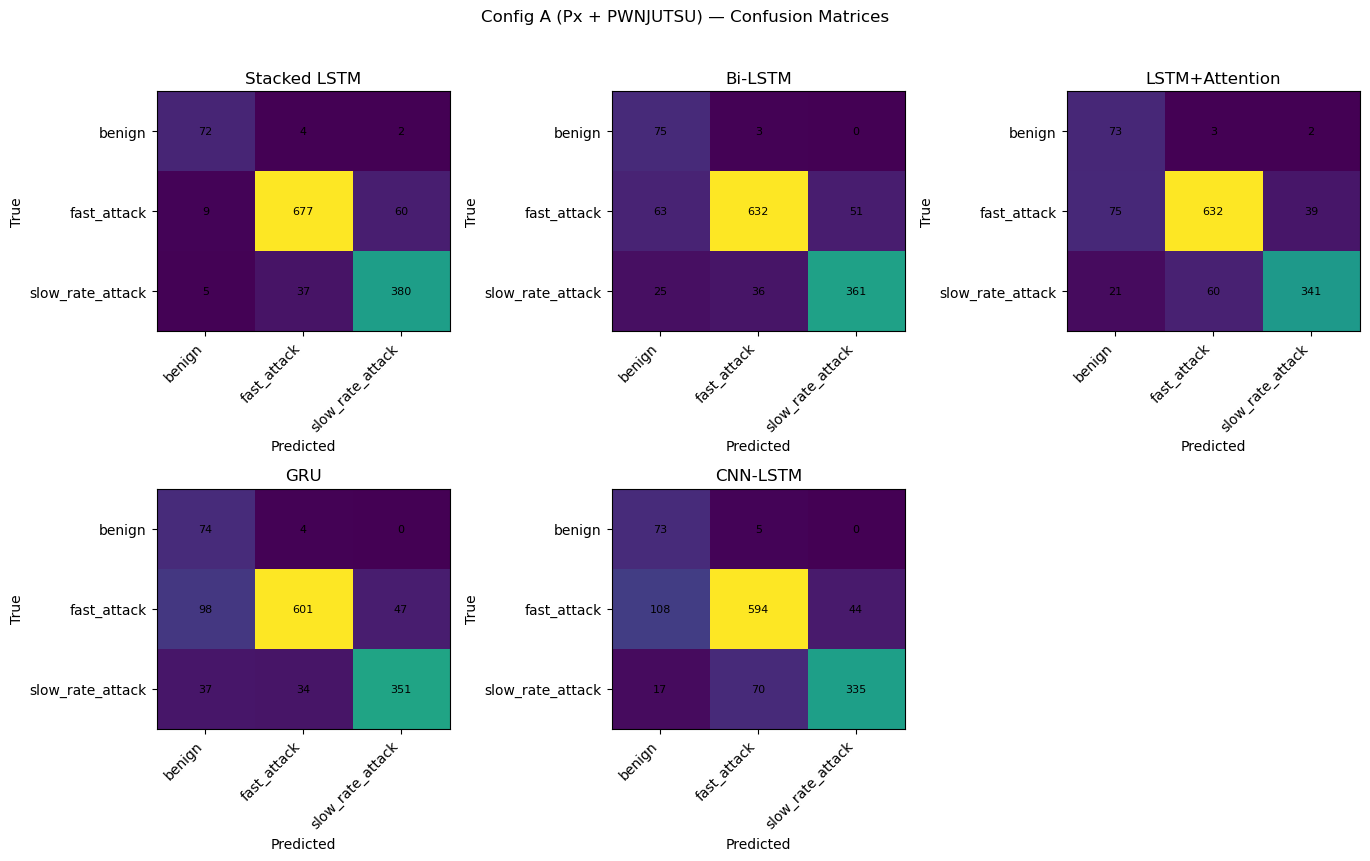

=== Config A (Px + PWNJUTSU) — Per-class metrics (Test) ===


,Model,Class,Precision,Recall,F1,Support
0,Stacked LSTM,benign,0.837209,0.923077,0.878049,78
3,Bi-LSTM,benign,0.460123,0.961538,0.622407,78
6,LSTM+Attention,benign,0.431953,0.935897,0.591093,78
12,CNN-LSTM,benign,0.368687,0.935897,0.528986,78
9,GRU,benign,0.354067,0.948718,0.515679,78
1,Stacked LSTM,fast_attack,0.942897,0.907507,0.924863,746
4,Bi-LSTM,fast_attack,0.941878,0.847185,0.892025,746
7,LSTM+Attention,fast_attack,0.909353,0.847185,0.877169,746
10,GRU,fast_attack,0.940532,0.805630,0.867870,746
13,CNN-LSTM,fast_attack,0.887892,0.796247,0.839576,746


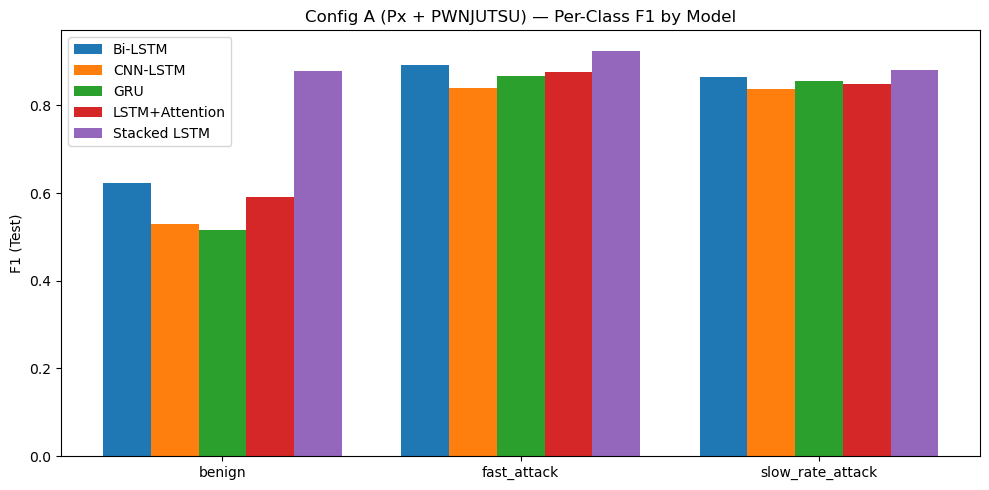

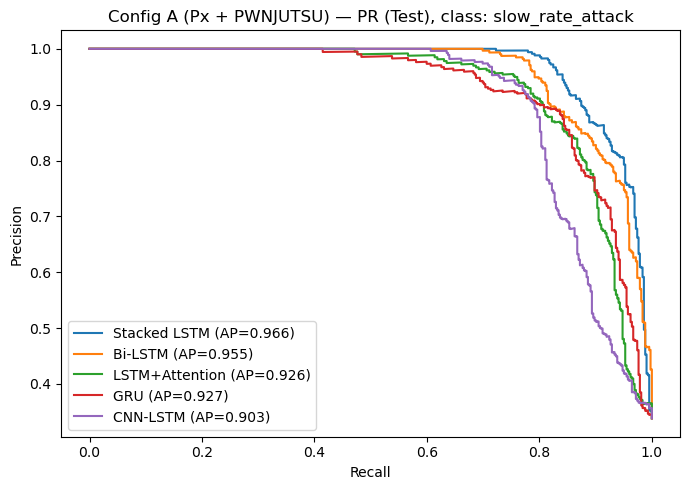

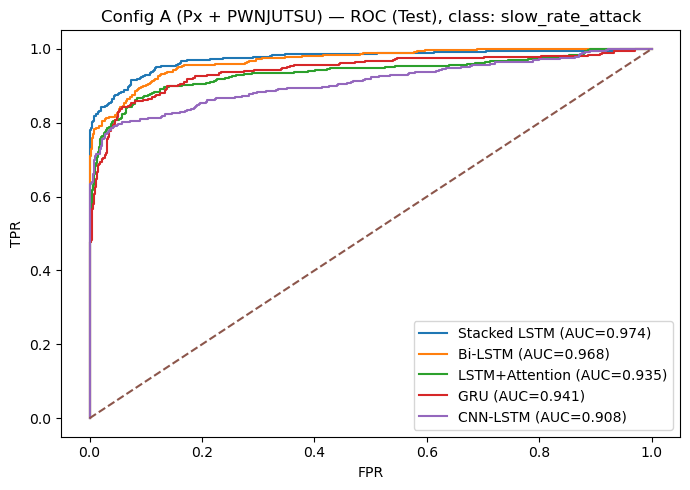

=== Config A (Px + PWNJUTSU) — AUC Summary ===


,Model,Macro PR-AUC,Macro ROC-AUC,PR-AUC/benign,PR-AUC/fast_attack,PR-AUC/slow_rate_attack,ROC-AUC/benign,ROC-AUC/fast_attack,ROC-AUC/slow_rate_attack
0,Stacked LSTM,0.970756,0.982954,0.963775,0.982905,0.965589,0.996641,0.978668,0.973554
1,Bi-LSTM,0.952828,0.973294,0.930194,0.973247,0.955043,0.988178,0.963764,0.967940
3,GRU,0.923606,0.953858,0.896815,0.947500,0.926504,0.980308,0.939866,0.941400
2,LSTM+Attention,0.896902,0.936339,0.869584,0.894924,0.926198,0.971198,0.903290,0.934529
4,CNN-LSTM,0.868084,0.925478,0.792815,0.908060,0.903379,0.977487,0.891016,0.907931


=== Config A (Px + PWNJUTSU) — Per-class Error Rates (Test) ===


,Class,TPR,FPR,FNR,Model
0,benign,0.923077,0.011986,0.076923,Stacked LSTM
1,fast_attack,0.907507,0.082000,0.092493,Stacked LSTM
2,slow_rate_attack,0.900474,0.075243,0.099526,Stacked LSTM
3,benign,0.961538,0.075342,0.038462,Bi-LSTM
4,fast_attack,0.847185,0.078000,0.152815,Bi-LSTM
5,slow_rate_attack,0.855450,0.061893,0.144550,Bi-LSTM
6,benign,0.935897,0.082192,0.064103,LSTM+Attention
7,fast_attack,0.847185,0.126000,0.152815,LSTM+Attention
8,slow_rate_attack,0.808057,0.049757,0.191943,LSTM+Attention
9,benign,0.948718,0.115582,0.051282,GRU


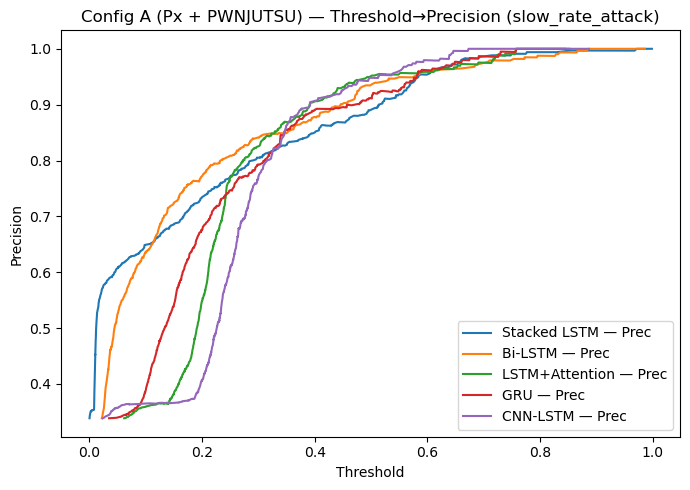

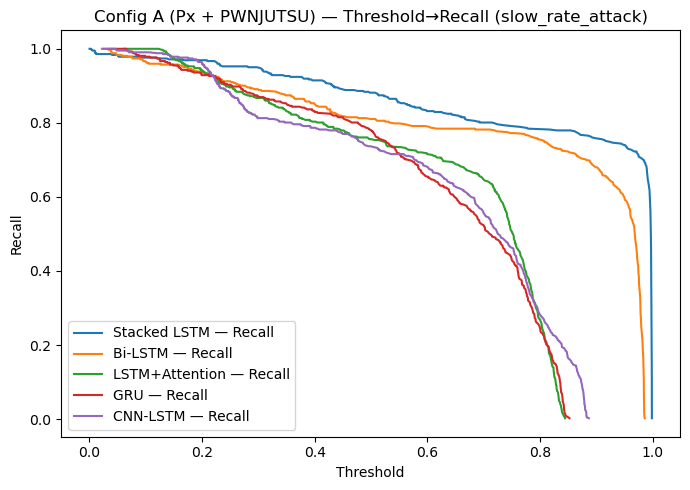

=== Config A (Px + PWNJUTSU) — Best Threshold by Max F1 (slow_rate_attack) ===


,Model,BestThresh(F1),BestF1,Prec@best,Rec@best
0,Stacked LSTM,0.587421,0.894207,0.954301,0.841232
1,Bi-LSTM,0.507491,0.870229,0.939560,0.810427
3,GRU,0.395352,0.862027,0.889169,0.836493
2,LSTM+Attention,0.342894,0.853365,0.865854,0.841232
4,CNN-LSTM,0.459264,0.844156,0.933908,0.770142



===== Config B (Px + PWNJUTSU → LogHub) — Macro Metrics (Test) =====


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1
1,Bi-LSTM,0.567876,0.456600,0.418842,0.411936
0,Stacked LSTM,0.506045,0.442721,0.385057,0.371645
4,CNN-LSTM,0.426943,0.422710,0.345113,0.314617
2,LSTM+Attention,0.381002,0.416466,0.324447,0.271036
3,GRU,0.305354,0.354371,0.277995,0.192639


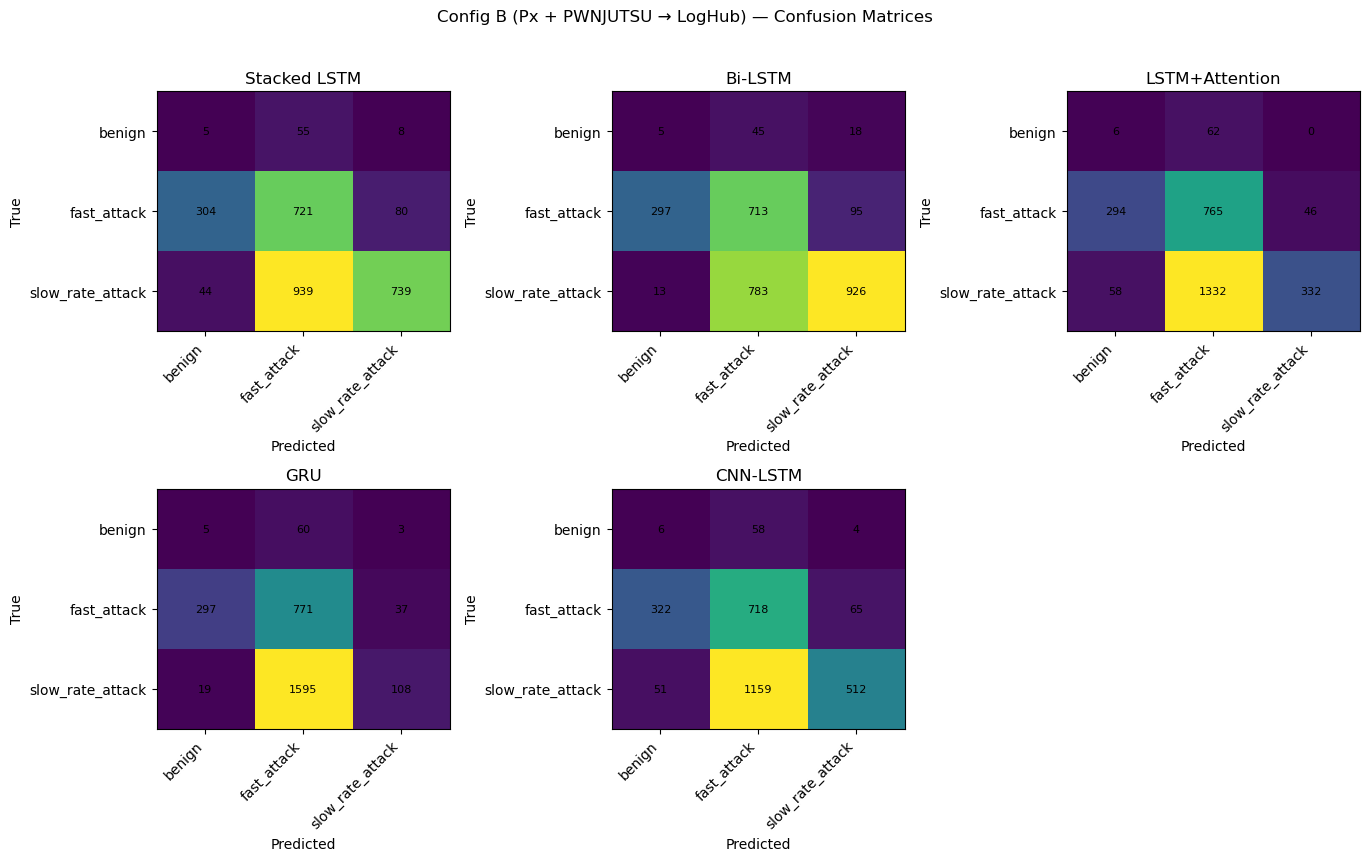

=== Config B (Px + PWNJUTSU → LogHub) — Per-class metrics (Test) ===


,Model,Class,Precision,Recall,F1,Support
6,LSTM+Attention,benign,0.016760,0.088235,0.028169,68
12,CNN-LSTM,benign,0.015831,0.088235,0.026846,68
3,Bi-LSTM,benign,0.015873,0.073529,0.026110,68
9,GRU,benign,0.015576,0.073529,0.025707,68
0,Stacked LSTM,benign,0.014164,0.073529,0.023753,68
4,Bi-LSTM,fast_attack,0.462687,0.645249,0.538927,1105
1,Stacked LSTM,fast_attack,0.420408,0.652489,0.511348,1105
13,CNN-LSTM,fast_attack,0.371059,0.649774,0.472368,1105
7,LSTM+Attention,fast_attack,0.354331,0.692308,0.468750,1105
10,GRU,fast_attack,0.317807,0.697738,0.436703,1105


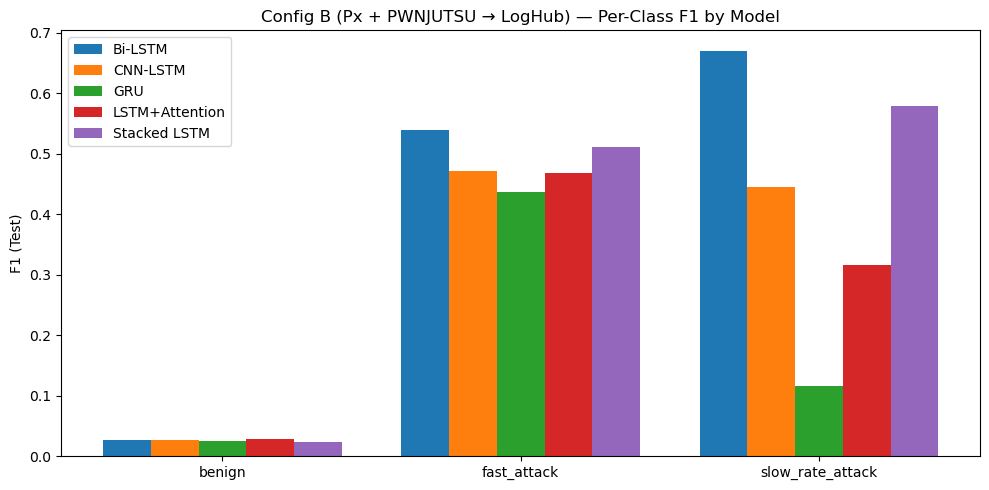

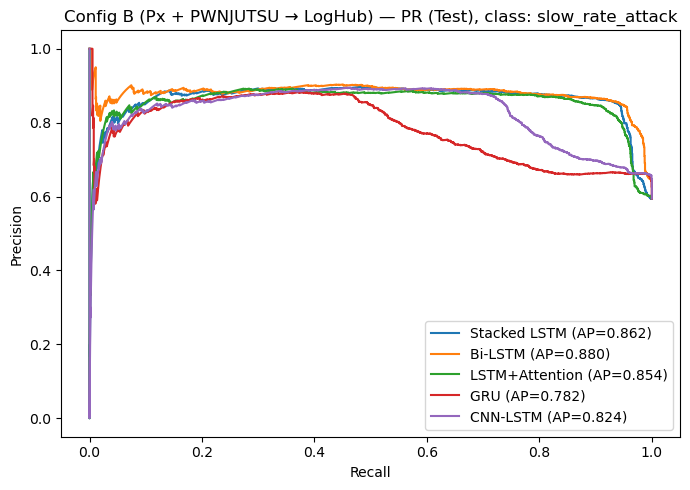

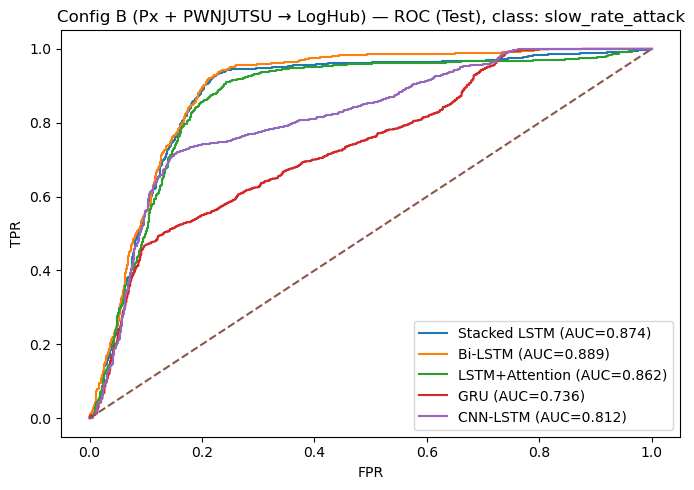

=== Config B (Px + PWNJUTSU → LogHub) — AUC Summary ===


,Model,Macro PR-AUC,Macro ROC-AUC,PR-AUC/benign,PR-AUC/fast_attack,PR-AUC/slow_rate_attack,ROC-AUC/benign,ROC-AUC/fast_attack,ROC-AUC/slow_rate_attack
1,Bi-LSTM,0.532352,0.752843,0.040738,0.676808,0.879510,0.718507,0.650883,0.889138
0,Stacked LSTM,0.519765,0.732253,0.032829,0.664251,0.862214,0.669846,0.652569,0.874344
2,LSTM+Attention,0.510177,0.685431,0.024551,0.651746,0.854233,0.557882,0.636379,0.862033
4,CNN-LSTM,0.445207,0.632365,0.024206,0.487315,0.824100,0.528683,0.556589,0.811821
3,GRU,0.364188,0.522657,0.026966,0.283448,0.782152,0.544690,0.287179,0.736103


=== Config B (Px + PWNJUTSU → LogHub) — Per-class Error Rates (Test) ===


,Class,TPR,FPR,FNR,Model
0,benign,0.073529,0.123099,0.926471,Stacked LSTM
1,fast_attack,0.652489,0.555307,0.347511,Stacked LSTM
2,slow_rate_attack,0.429152,0.075021,0.570848,Stacked LSTM
3,benign,0.073529,0.109657,0.926471,Bi-LSTM
4,fast_attack,0.645249,0.462570,0.354751,Bi-LSTM
5,slow_rate_attack,0.537747,0.096334,0.462253,Bi-LSTM
6,benign,0.088235,0.124514,0.911765,LSTM+Attention
7,fast_attack,0.692308,0.778771,0.307692,LSTM+Attention
8,slow_rate_attack,0.192799,0.039216,0.807201,LSTM+Attention
9,benign,0.073529,0.111779,0.926471,GRU


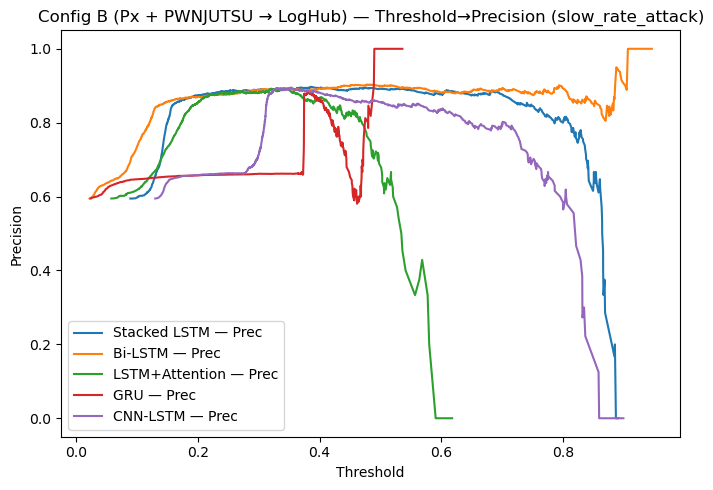

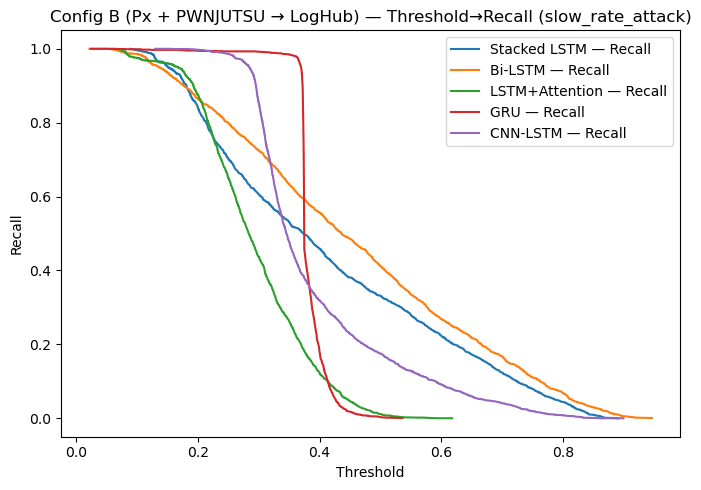

=== Config B (Px + PWNJUTSU → LogHub) — Best Threshold by Max F1 (slow_rate_attack) ===


,Model,BestThresh(F1),BestF1,Prec@best,Rec@best
1,Bi-LSTM,0.138512,0.896022,0.849194,0.948316
0,Stacked LSTM,0.161235,0.893793,0.851287,0.940767
2,LSTM+Attention,0.189963,0.876643,0.845656,0.909988
3,GRU,0.300158,0.794145,0.661890,0.992451
4,CNN-LSTM,0.208878,0.794077,0.660000,0.996516



===== Config C (Mixed Dataset Training) — Macro Metrics (Test) =====


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1
1,Bi-LSTM,0.863772,0.771798,0.863876,0.804127
4,CNN-LSTM,0.831648,0.720718,0.822143,0.749491
2,LSTM+Attention,0.817965,0.704897,0.831021,0.729037
0,Stacked LSTM,0.803688,0.698561,0.821107,0.722448
3,GRU,0.799524,0.690407,0.818748,0.708200


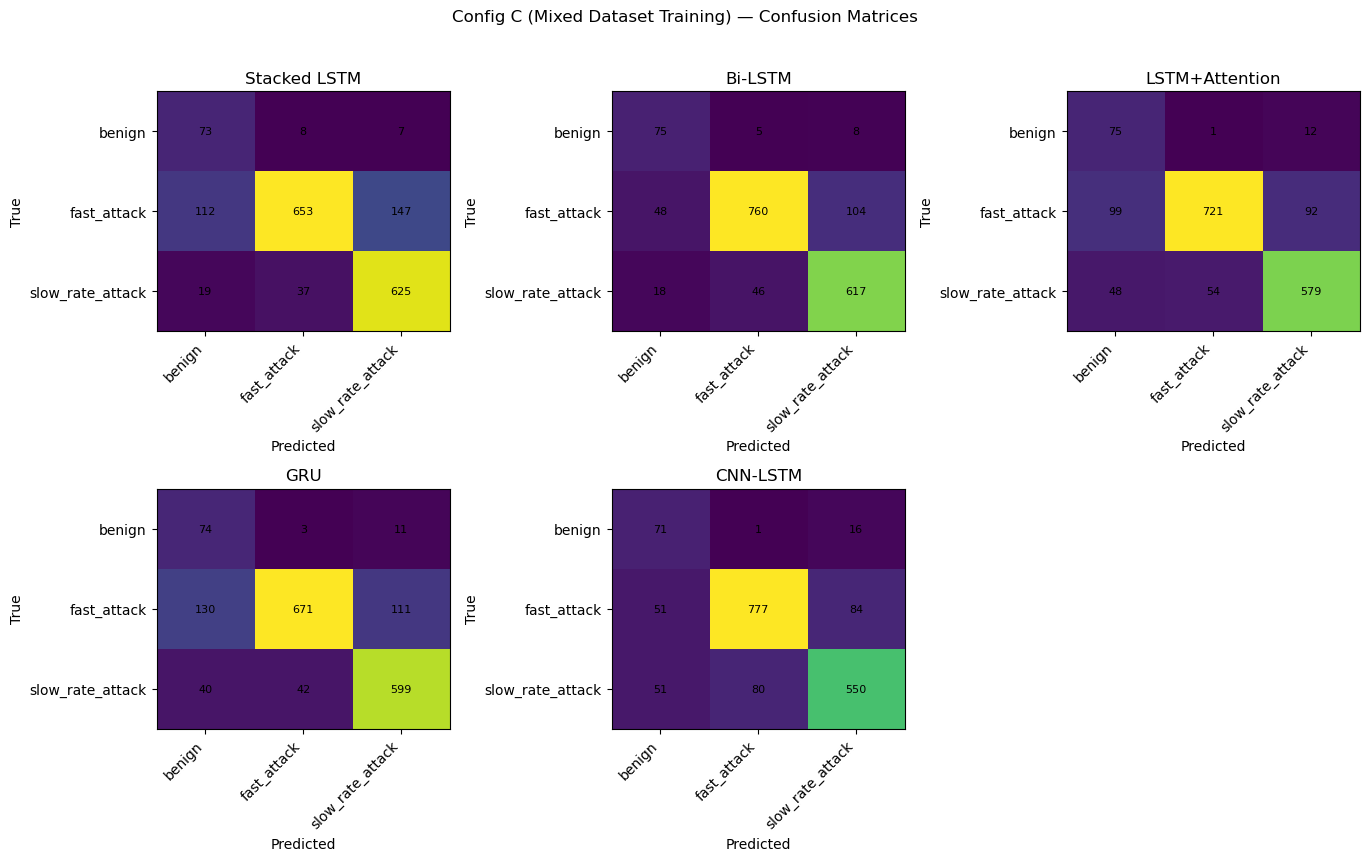

=== Config C (Mixed Dataset Training) — Per-class metrics (Test) ===


,Model,Class,Precision,Recall,F1,Support
3,Bi-LSTM,benign,0.531915,0.852273,0.655022,88
12,CNN-LSTM,benign,0.410405,0.806818,0.544061,88
0,Stacked LSTM,benign,0.357843,0.829545,0.500000,88
6,LSTM+Attention,benign,0.337838,0.852273,0.483871,88
9,GRU,benign,0.303279,0.840909,0.445783,88
4,Bi-LSTM,fast_attack,0.937115,0.833333,0.882182,912
13,CNN-LSTM,fast_attack,0.905594,0.851974,0.877966,912
7,LSTM+Attention,fast_attack,0.929124,0.790570,0.854265,912
10,GRU,fast_attack,0.937151,0.735746,0.824324,912
1,Stacked LSTM,fast_attack,0.935530,0.716009,0.811180,912


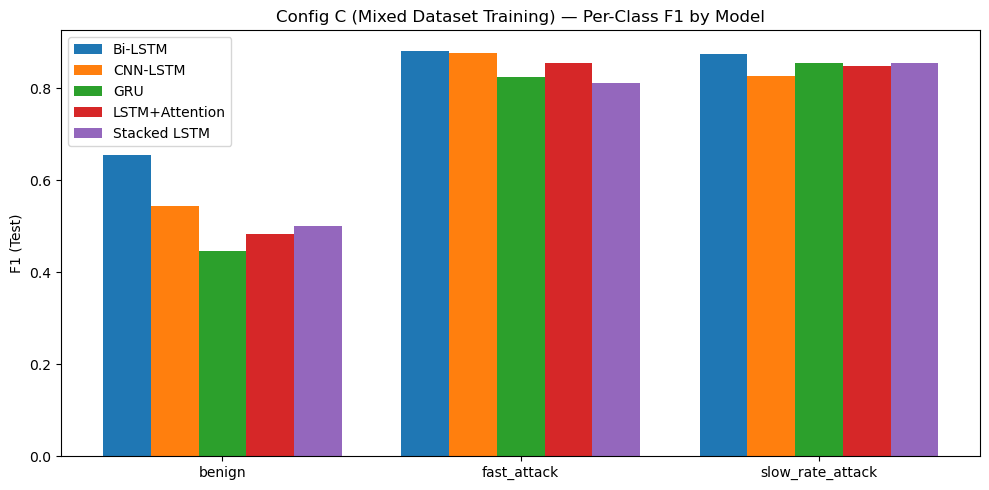

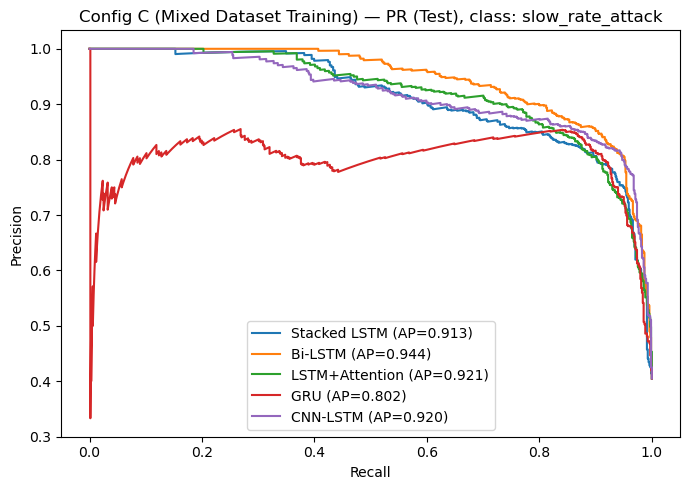

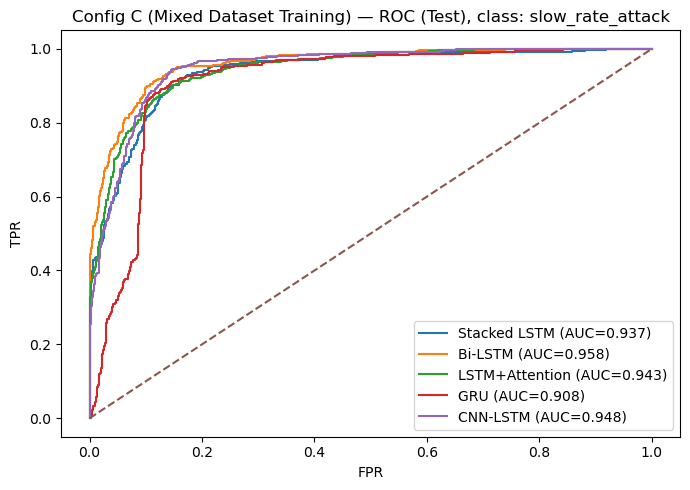

=== Config C (Mixed Dataset Training) — AUC Summary ===


,Model,Macro PR-AUC,Macro ROC-AUC,PR-AUC/benign,PR-AUC/fast_attack,PR-AUC/slow_rate_attack,ROC-AUC/benign,ROC-AUC/fast_attack,ROC-AUC/slow_rate_attack
1,Bi-LSTM,0.918800,0.957823,0.850341,0.962131,0.943927,0.962421,0.953190,0.957859
2,LSTM+Attention,0.903013,0.948689,0.839369,0.948708,0.920961,0.969590,0.933861,0.942617
4,CNN-LSTM,0.884693,0.934400,0.787514,0.947007,0.919557,0.923772,0.931906,0.947521
0,Stacked LSTM,0.878712,0.930176,0.797846,0.925276,0.913012,0.965667,0.887657,0.937203
3,GRU,0.839903,0.900954,0.800472,0.917466,0.801771,0.917466,0.877233,0.908163


=== Config C (Mixed Dataset Training) — Per-class Error Rates (Test) ===


,Class,TPR,FPR,FNR,Model
0,benign,0.829545,0.082235,0.170455,Stacked LSTM
1,fast_attack,0.716009,0.058518,0.283991,Stacked LSTM
2,slow_rate_attack,0.917768,0.154000,0.082232,Stacked LSTM
3,benign,0.852273,0.041431,0.147727,Bi-LSTM
4,fast_attack,0.833333,0.066320,0.166667,Bi-LSTM
5,slow_rate_attack,0.906021,0.112000,0.093979,Bi-LSTM
6,benign,0.852273,0.092279,0.147727,LSTM+Attention
7,fast_attack,0.790570,0.071521,0.209430,LSTM+Attention
8,slow_rate_attack,0.850220,0.104000,0.149780,LSTM+Attention
9,benign,0.840909,0.106717,0.159091,GRU


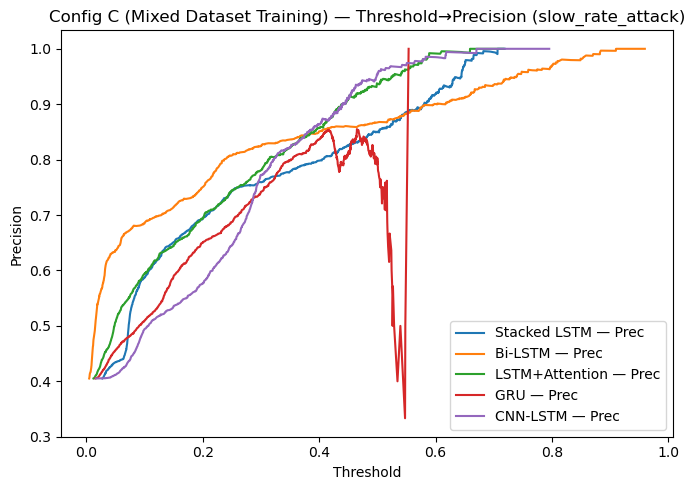

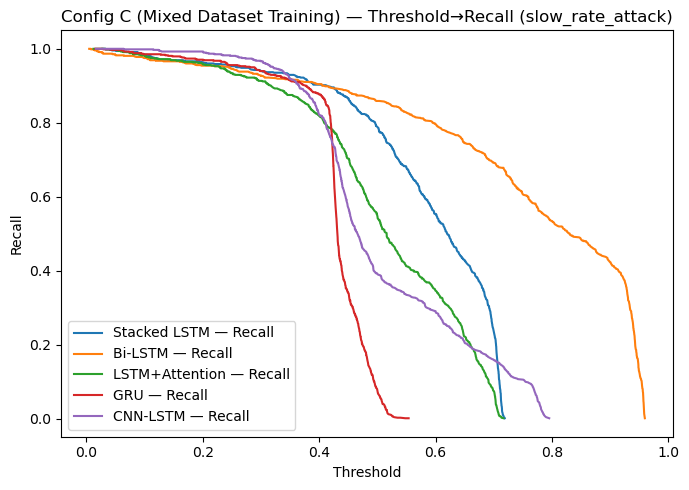

=== Config C (Mixed Dataset Training) — Best Threshold by Max F1 (slow_rate_attack) ===


,Model,BestThresh(F1),BestF1,Prec@best,Rec@best
1,Bi-LSTM,0.386869,0.877565,0.846995,0.910426
4,CNN-LSTM,0.335300,0.875256,0.816794,0.942731
3,GRU,0.402136,0.857759,0.839662,0.876652
0,Stacked LSTM,0.425133,0.852551,0.813333,0.895742
2,LSTM+Attention,0.315185,0.850416,0.804718,0.901615



===== Multi-Config Comparison (3 configs) =====

=== Macro F1 Comparison Across Configs ===


Config,A,B,C
Model,,,
Bi-LSTM,0.793380,0.411936,0.804127
CNN-LSTM,0.735005,0.314617,0.749491
LSTM+Attention,0.772173,0.271036,0.729037
Stacked LSTM,0.894181,0.371645,0.722448
GRU,0.746549,0.192639,0.708200



=== AUC Comparison Across Configs ===

Macro PR-AUC:


Config,A,B,C
Model,,,
Bi-LSTM,0.952828,0.532352,0.918800
LSTM+Attention,0.896902,0.510177,0.903013
CNN-LSTM,0.868084,0.445207,0.884693
Stacked LSTM,0.970756,0.519765,0.878712
GRU,0.923606,0.364188,0.839903



Macro ROC-AUC:


Config,A,B,C
Model,,,
Bi-LSTM,0.973294,0.752843,0.957823
LSTM+Attention,0.936339,0.685431,0.948689
CNN-LSTM,0.925478,0.632365,0.934400
Stacked LSTM,0.982954,0.732253,0.930176
GRU,0.953858,0.522657,0.900954



===== A vs B: Macro Metrics (Δ = B − A) =====


,Model,Accuracy_A,Macro Precision_A,Macro Recall_A,Macro F1_A,Accuracy_B,Macro Precision_B,Macro Recall_B,Macro F1_B,Δ Accuracy,Δ Macro Precision,Δ Macro Recall,Δ Macro F1
1,Bi-LSTM,0.857143,0.759405,0.888058,0.793380,0.567876,0.456600,0.418842,0.411936,-0.289267,-0.302804,-0.469216,-0.381444
4,CNN-LSTM,0.804173,0.713495,0.841994,0.735005,0.426943,0.422710,0.345113,0.314617,-0.377230,-0.290785,-0.496882,-0.420388
2,LSTM+Attention,0.839486,0.744658,0.863713,0.772173,0.381002,0.416466,0.324447,0.271036,-0.458485,-0.328193,-0.539266,-0.501137
0,Stacked LSTM,0.906100,0.879945,0.910353,0.894181,0.506045,0.442721,0.385057,0.371645,-0.400055,-0.437224,-0.525296,-0.522535
3,GRU,0.823435,0.725503,0.862034,0.746549,0.305354,0.354371,0.277995,0.192639,-0.518081,-0.371132,-0.584039,-0.553910



===== A vs B: Macro AUCs (Δ = B − A) =====


,Model,Macro PR-AUC_A,Macro ROC-AUC_A,Macro PR-AUC_B,Macro ROC-AUC_B,Δ PR-AUC,Δ ROC-AUC
3,LSTM+Attention,0.896902,0.936339,0.510177,0.685431,-0.386726,-0.250907
1,Bi-LSTM,0.952828,0.973294,0.532352,0.752843,-0.420476,-0.220451
4,CNN-LSTM,0.868084,0.925478,0.445207,0.632365,-0.422878,-0.293113
0,Stacked LSTM,0.970756,0.982954,0.519765,0.732253,-0.450991,-0.250702
2,GRU,0.923606,0.953858,0.364188,0.522657,-0.559418,-0.431201



===== A vs C: Macro Metrics (Δ = C − A) =====


,Model,Accuracy_A,Macro Precision_A,Macro Recall_A,Macro F1_A,Accuracy_C,Macro Precision_C,Macro Recall_C,Macro F1_C,Δ Accuracy,Δ Macro Precision,Δ Macro Recall,Δ Macro F1
4,CNN-LSTM,0.804173,0.713495,0.841994,0.735005,0.831648,0.720718,0.822143,0.749491,0.027474,0.007223,-0.019852,0.014486
1,Bi-LSTM,0.857143,0.759405,0.888058,0.793380,0.863772,0.771798,0.863876,0.804127,0.006629,0.012393,-0.024182,0.010747
3,GRU,0.823435,0.725503,0.862034,0.746549,0.799524,0.690407,0.818748,0.708200,-0.023911,-0.035096,-0.043286,-0.038349
2,LSTM+Attention,0.839486,0.744658,0.863713,0.772173,0.817965,0.704897,0.831021,0.729037,-0.021521,-0.039761,-0.032692,-0.043137
0,Stacked LSTM,0.906100,0.879945,0.910353,0.894181,0.803688,0.698561,0.821107,0.722448,-0.102411,-0.181384,-0.089245,-0.171732



===== A vs C: Macro AUCs (Δ = C − A) =====


,Model,Macro PR-AUC_A,Macro ROC-AUC_A,Macro PR-AUC_C,Macro ROC-AUC_C,Δ PR-AUC,Δ ROC-AUC
4,CNN-LSTM,0.868084,0.925478,0.884693,0.934400,0.016608,0.008922
3,LSTM+Attention,0.896902,0.936339,0.903013,0.948689,0.006111,0.012350
1,Bi-LSTM,0.952828,0.973294,0.918800,0.957823,-0.034028,-0.015471
2,GRU,0.923606,0.953858,0.839903,0.900954,-0.083703,-0.052904
0,Stacked LSTM,0.970756,0.982954,0.878712,0.930176,-0.092045,-0.052779



===== B vs C: Macro Metrics (Δ = C − B) =====


,Model,Accuracy_B,Macro Precision_B,Macro Recall_B,Macro F1_B,Accuracy_C,Macro Precision_C,Macro Recall_C,Macro F1_C,Δ Accuracy,Δ Macro Precision,Δ Macro Recall,Δ Macro F1
4,GRU,0.305354,0.354371,0.277995,0.192639,0.799524,0.690407,0.818748,0.708200,0.494170,0.336036,0.540753,0.515561
3,LSTM+Attention,0.381002,0.416466,0.324447,0.271036,0.817965,0.704897,0.831021,0.729037,0.436964,0.288432,0.506574,0.458000
2,CNN-LSTM,0.426943,0.422710,0.345113,0.314617,0.831648,0.720718,0.822143,0.749491,0.404705,0.298008,0.477030,0.434874
0,Bi-LSTM,0.567876,0.456600,0.418842,0.411936,0.863772,0.771798,0.863876,0.804127,0.295896,0.315198,0.445034,0.392191
1,Stacked LSTM,0.506045,0.442721,0.385057,0.371645,0.803688,0.698561,0.821107,0.722448,0.297643,0.255840,0.436051,0.350803



===== B vs C: Macro AUCs (Δ = C − B) =====


,Model,Macro PR-AUC_B,Macro ROC-AUC_B,Macro PR-AUC_C,Macro ROC-AUC_C,Δ PR-AUC,Δ ROC-AUC
4,GRU,0.364188,0.522657,0.839903,0.900954,0.475715,0.378296
3,CNN-LSTM,0.445207,0.632365,0.884693,0.934400,0.439486,0.302035
2,LSTM+Attention,0.510177,0.685431,0.903013,0.948689,0.392836,0.263258
0,Bi-LSTM,0.532352,0.752843,0.918800,0.957823,0.386448,0.204980
1,Stacked LSTM,0.519765,0.732253,0.878712,0.930176,0.358947,0.197923



===== Best Model Overlay (slow_rate_attack) =====


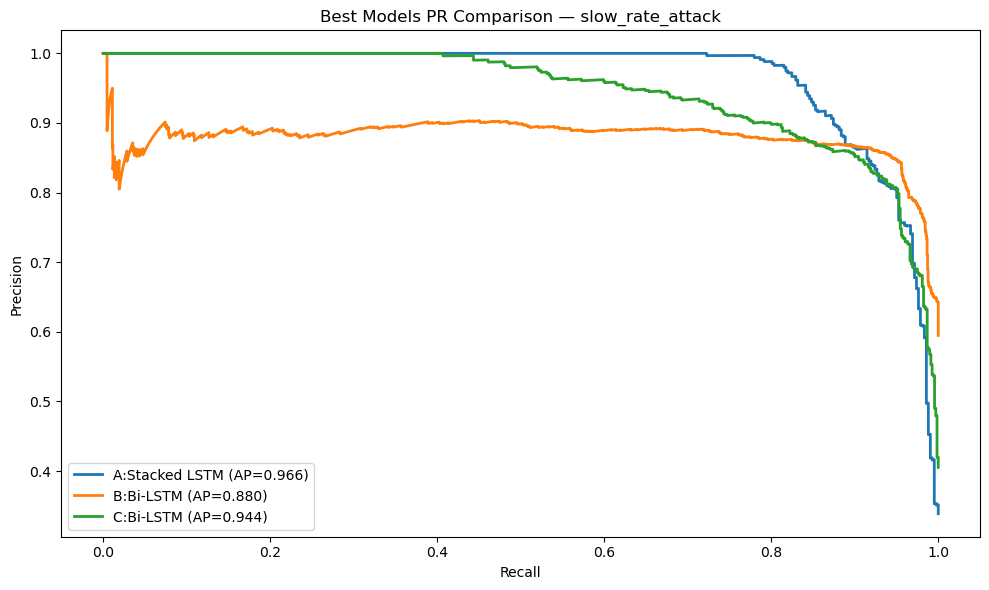

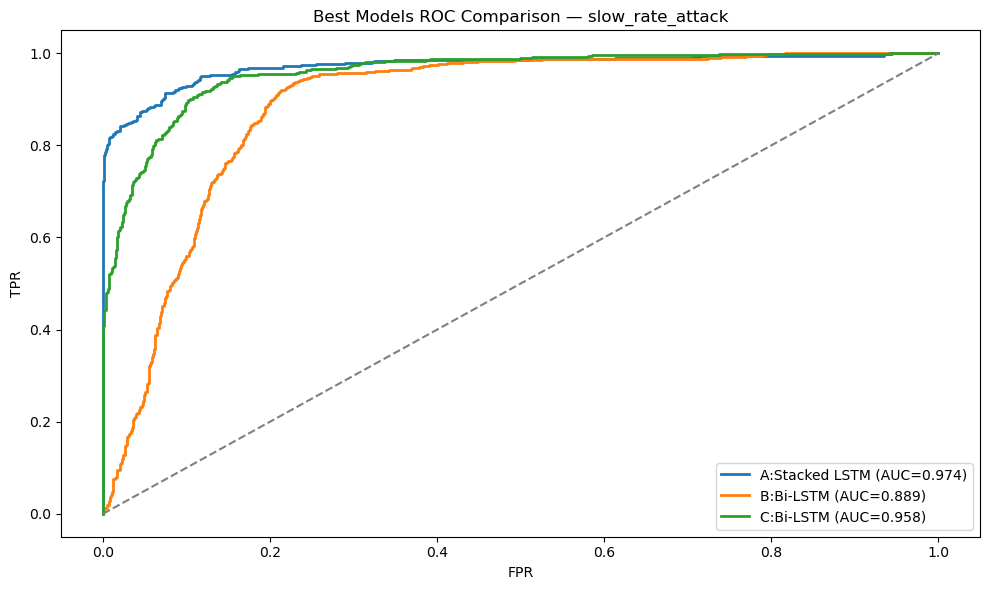


=== Evaluation Complete ===
Configurations evaluated: ['A', 'B', 'C']


In [27]:
# === Full Metrics Visualization: Accuracy/Precision/Recall/AUC/ErrorRates/Thresholds (A, B, C, and Comparisons) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, accuracy_score,
    roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
)

# ------------ Helpers ------------
def _to_2col_binary_probs(p1):
    p1 = np.asarray(p1).reshape(-1)
    p1 = np.clip(p1, 0.0, 1.0)
    return np.column_stack([1.0 - p1, p1])

def _fix_probs_shape(probs, n_classes):
    probs = np.asarray(probs)
    if probs.ndim == 1:
        probs = probs.reshape(-1, 1)
    if n_classes == 2 and probs.shape[1] == 1:
        probs = _to_2col_binary_probs(probs[:, 0])
    return probs

def _one_hot(y, n_classes):
    y = np.asarray(y, dtype=int)
    N = y.shape[0]
    Y = np.zeros((N, n_classes), dtype=int)
    valid = (y >= 0) & (y < n_classes)
    idx = np.where(valid)[0]
    if idx.size:
        Y[idx, y[idx]] = 1
    return Y

def _per_class_rates(cm, classes):
    rows=[]
    for k in range(len(classes)):
        TP=cm[k,k]; FN=cm[k,:].sum()-TP; FP=cm[:,k].sum()-TP; TN=cm.sum()-TP-FN-FP
        FPR=FP/(FP+TN) if FP+TN>0 else 0.0
        FNR=FN/(TP+FN) if TP+FN>0 else 0.0
        TPR=TP/(TP+FN) if TP+FN>0 else 0.0
        rows.append({"Class":classes[k],"TPR":TPR,"FPR":FPR,"FNR":FNR})
    return pd.DataFrame(rows)

def _pick_focus_class(classes):
    return "slow_rate_attack" if "slow_rate_attack" in classes else classes[-1]

def _macro_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1

def evaluate_config_full(results, bundle, title=""):
    """Compute & plot full metrics suite for a single configuration."""
    assert results and bundle
    y_test = bundle['y_test']; label_enc = bundle['label_encoder']
    classes = list(label_enc.classes_); num_classes = len(classes)
    model_names = list(results.keys())
    y_test_bin = _one_hot(y_test, num_classes)
    focus_class = _pick_focus_class(classes)
    focus_idx = classes.index(focus_class)

    # --- Macro metrics table ---
    macro_rows=[]
    for m in model_names:
        y_pred=np.asarray(results[m]["test_pred"])
        acc, mprec, mrec, mf1 = _macro_metrics(y_test, y_pred)
        macro_rows.append({"Model":m,"Accuracy":acc,"Macro Precision":mprec,"Macro Recall":mrec,"Macro F1":mf1})
    macro_df = pd.DataFrame(macro_rows).sort_values("Macro F1", ascending=False)
    print(f"\n===== {title} — Macro Metrics (Test) =====")
    display(macro_df)

    # --- Confusion matrices + per-class metrics ---
    per_class_rows=[]
    n_cols = min(3, len(model_names))
    n_rows = int(np.ceil(len(model_names)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.6*n_cols, 4.2*n_rows))
    if n_rows*n_cols == 1: axes = np.array([[axes]])
    elif n_rows == 1: axes = np.array([axes])
    axes = axes.flatten()
    for idx, m in enumerate(model_names):
        y_pred = np.asarray(results[m]["test_pred"])
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
        ax = axes[idx]
        im = ax.imshow(cm, interpolation="nearest", aspect="auto")
        ax.set_title(m)
        ax.set_xticks(range(num_classes)); ax.set_xticklabels(classes, rotation=45, ha="right")
        ax.set_yticks(range(num_classes)); ax.set_yticklabels(classes)
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        for r in range(num_classes):
            for c in range(num_classes):
                ax.text(c, r, cm[r, c], ha="center", va="center", fontsize=8)
        prec, rec, f1, sup = precision_recall_fscore_support(
            y_test, y_pred, labels=np.arange(num_classes), zero_division=0
        )
        for k,cls in enumerate(classes):
            per_class_rows.append({"Model":m,"Class":cls,"Precision":prec[k],"Recall":rec[k],"F1":f1[k],"Support":sup[k]})
    for k in range(len(model_names), len(axes)): axes[k].axis("off")
    fig.suptitle(f"{title} — Confusion Matrices", y=1.02); plt.tight_layout(); plt.show()

    percls_df = pd.DataFrame(per_class_rows).sort_values(["Class","F1"], ascending=[True, False])
    print(f"=== {title} — Per-class metrics (Test) ===")
    display(percls_df)

    # --- Per-class F1 grouped bars ---
    piv = percls_df.pivot(index="Class", columns="Model", values="F1").reindex(classes)
    x=np.arange(len(classes)); w=0.8/max(1,len(piv.columns))
    plt.figure(figsize=(10,5))
    for j,m in enumerate(piv.columns):
        plt.bar(x+j*w-(len(piv.columns)-1)*w/2, piv[m], w, label=m)
    plt.xticks(x, classes); plt.ylabel("F1 (Test)")
    plt.title(f"{title} — Per-Class F1 by Model"); plt.legend(); plt.tight_layout(); plt.show()

    # --- PR & ROC curves for focus class ---
    # PR
    plotted_pr=False
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        # skip if focus class absent in y_test
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        pr, rc, _ = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        ap = average_precision_score(y_test_bin[:,focus_idx], probs[:,focus_idx])
        if not plotted_pr:
            plt.figure(figsize=(7,5)); plotted_pr=True
        plt.plot(rc, pr, label=f"{m} (AP={ap:.3f})")
    if plotted_pr:
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"{title} — PR (Test), class: {focus_class}"); plt.legend(); plt.tight_layout(); plt.show()

    # ROC
    plotted_roc=False
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        fpr, tpr, _ = roc_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        ra = auc(fpr, tpr)
        if not plotted_roc:
            plt.figure(figsize=(7,5)); plotted_roc=True
        plt.plot(fpr, tpr, label=f"{m} (AUC={ra:.3f})")
    if plotted_roc:
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"{title} — ROC (Test), class: {focus_class}")
        plt.legend(); plt.tight_layout(); plt.show()

    # --- PR-AUC & ROC-AUC tables (macro + per-class) ---
    auc_rows=[]
    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None:
            auc_rows.append({"Model":m,"Macro PR-AUC":np.nan,"Macro ROC-AUC":np.nan}); continue
        probs = _fix_probs_shape(probs, num_classes)
        pr_aucs, roc_aucs = {}, {}
        for i,cls in enumerate(classes):
            if y_test_bin[:,i].max()==y_test_bin[:,i].min():
                pr_aucs[cls]=np.nan; roc_aucs[cls]=np.nan; continue
            pr_aucs[cls]=average_precision_score(y_test_bin[:,i], probs[:,i])
            roc_aucs[cls]=roc_auc_score(y_test_bin[:,i], probs[:,i])
        auc_rows.append({
            "Model": m,
            "Macro PR-AUC": np.nanmean(list(pr_aucs.values())),
            "Macro ROC-AUC": np.nanmean(list(roc_aucs.values())),
            **{f"PR-AUC/{k}":v for k,v in pr_aucs.items()},
            **{f"ROC-AUC/{k}":v for k,v in roc_aucs.items()}
        })
    auc_df = pd.DataFrame(auc_rows).sort_values("Macro PR-AUC", ascending=False)
    print(f"=== {title} — AUC Summary ===")
    display(auc_df)

    # --- Error rates (FPR/FNR/TPR) ---
    err_rows=[]
    for m in model_names:
        y_pred = np.asarray(results[m]["test_pred"])
        cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
        df = _per_class_rates(cm, classes)
        df["Model"]=m
        err_rows.append(df)
    err_df = pd.concat(err_rows, ignore_index=True)
    print(f"=== {title} — Per-class Error Rates (Test) ===")
    display(err_df)

    # --- Threshold sweeps (focus class) + best thresholds by max-F1 ---
    best_rows=[]
    for ylabel in ["Precision","Recall"]:
        plt.figure(figsize=(7,5)); plotted=False
        for m in model_names:
            probs = results[m].get("test_probs", None)
            if probs is None: continue
            probs = _fix_probs_shape(probs, num_classes)
            if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
            pr, rc, th = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
            if ylabel=="Precision":
                plt.plot(th, pr[:-1], label=f"{m} — Prec"); plotted=True
            else:
                plt.plot(th, rc[:-1], label=f"{m} — Recall"); plotted=True
        if plotted:
            plt.xlabel("Threshold"); plt.ylabel(ylabel)
            plt.title(f"{title} — Threshold→{ylabel} ({focus_class})")
            plt.legend(); plt.tight_layout(); plt.show()

    for m in model_names:
        probs = results[m].get("test_probs", None)
        if probs is None: continue
        probs = _fix_probs_shape(probs, num_classes)
        if y_test_bin[:,focus_idx].max()==y_test_bin[:,focus_idx].min(): continue
        pr, rc, th = precision_recall_curve(y_test_bin[:,focus_idx], probs[:,focus_idx])
        denom = np.clip(pr[:-1] + rc[:-1], 1e-9, None)
        f1 = 2 * pr[:-1] * rc[:-1] / denom
        j = int(np.argmax(f1))
        best_rows.append({"Model":m,"BestThresh(F1)":float(th[j]),"BestF1":float(f1[j]),"Prec@best":float(pr[j]),"Rec@best":float(rc[j])})
    best_df = pd.DataFrame(best_rows).sort_values("BestF1", ascending=False) if best_rows else pd.DataFrame()
    print(f"=== {title} — Best Threshold by Max F1 ({focus_class}) ===")
    display(best_df if not best_df.empty else pd.DataFrame({"Info":["No eligible models for threshold sweep."]}))

    return {
        "macro": macro_df,
        "perclass": percls_df,
        "auc": auc_df,
        "err": err_df,
        "best_thresh": best_df,
        "classes": classes,
        "focus_class": focus_class
    }

# ========== Run for Config A, B, and C ==========
resA = resB = resC = None

if 'results_A' in globals() and results_A:
    bundleA = globals().get("sequences_A", globals().get("export_bundle_A", globals().get("export_bundle")))
    if bundleA:
        resA = evaluate_config_full(results_A, bundleA, title="Config A (Px + PWNJUTSU)")

if 'results_B' in globals() and results_B:
    bundleB = globals().get("sequences_B", globals().get("export_bundle_B"))
    if bundleB:
        resB = evaluate_config_full(results_B, bundleB, title="Config B (Px + PWNJUTSU → LogHub)")

if 'results_C' in globals() and results_C:
    bundleC = globals().get("sequences_C")
    if bundleC:
        resC = evaluate_config_full(results_C, bundleC, title="Config C (Mixed Dataset Training)")

# ========== Multi-Config Comparisons ==========
configs = []
if resA is not None: configs.append(("A", resA))
if resB is not None: configs.append(("B", resB))
if resC is not None: configs.append(("C", resC))

if len(configs) >= 2:
    print(f"\n===== Multi-Config Comparison ({len(configs)} configs) =====")
    
    # Macro metrics comparison
    macro_dfs = []
    for name, res in configs:
        df = res["macro"].copy()
        df["Config"] = name
        macro_dfs.append(df)
    
    combined_macro = pd.concat(macro_dfs, ignore_index=True)
    macro_pivot = combined_macro.pivot(index="Model", columns="Config", values="Macro F1")
    
    print("\n=== Macro F1 Comparison Across Configs ===")
    display(macro_pivot.sort_values(macro_pivot.columns[-1], ascending=False))
    
    # AUC comparison
    auc_dfs = []
    for name, res in configs:
        df = res["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]].copy()
        df["Config"] = name
        auc_dfs.append(df)
    
    combined_auc = pd.concat(auc_dfs, ignore_index=True)
    
    print("\n=== AUC Comparison Across Configs ===")
    for metric in ["Macro PR-AUC", "Macro ROC-AUC"]:
        auc_pivot = combined_auc.pivot(index="Model", columns="Config", values=metric)
        print(f"\n{metric}:")
        display(auc_pivot.sort_values(auc_pivot.columns[-1], ascending=False))

# ========== Pairwise Comparisons (A vs B, A vs C, B vs C) ==========
def compare_configs(res1, res2, name1, name2):
    """Compare two configurations side by side."""
    print(f"\n===== {name1} vs {name2}: Macro Metrics (Δ = {name2} − {name1}) =====")
    
    comp_macro = pd.merge(res1["macro"], res2["macro"], on="Model", suffixes=(f"_{name1}", f"_{name2}"))
    for k in ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]:
        comp_macro[f"Δ {k}"] = comp_macro[f"{k}_{name2}"] - comp_macro[f"{k}_{name1}"]
    display(comp_macro.sort_values("Δ Macro F1", ascending=False))
    
    # AUC comparison
    comp_auc = pd.merge(res1["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]],
                        res2["auc"][["Model", "Macro PR-AUC", "Macro ROC-AUC"]],
                        on="Model", suffixes=(f"_{name1}", f"_{name2}"))
    comp_auc["Δ PR-AUC"] = comp_auc[f"Macro PR-AUC_{name2}"] - comp_auc[f"Macro PR-AUC_{name1}"]
    comp_auc["Δ ROC-AUC"] = comp_auc[f"Macro ROC-AUC_{name2}"] - comp_auc[f"Macro ROC-AUC_{name1}"]
    print(f"\n===== {name1} vs {name2}: Macro AUCs (Δ = {name2} − {name1}) =====")
    display(comp_auc.sort_values("Δ PR-AUC", ascending=False))

# Run pairwise comparisons
if resA is not None and resB is not None:
    compare_configs(resA, resB, "A", "B")

if resA is not None and resC is not None:
    compare_configs(resA, resC, "A", "C")

if resB is not None and resC is not None:
    compare_configs(resB, resC, "B", "C")

# ========== Best Model Overlay (Focus Class) ==========
if len(configs) >= 2:
    # Check if all configs have same focus class
    focus_classes = [res["focus_class"] for _, res in configs]
    if len(set(focus_classes)) == 1:
        focus = focus_classes[0]
        print(f"\n===== Best Model Overlay ({focus}) =====")
        
        # Get best models from each config
        best_models = []
        for name, res in configs:
            best_model = res["macro"].sort_values("Macro F1", ascending=False)["Model"].iloc[0]
            best_models.append((name, best_model, res))
        
        # PR curves overlay
        plt.figure(figsize=(10, 6))
        for name, model, res in best_models:
            if f'results_{name}' in globals():
                results = globals()[f'results_{name}']
                if model in results:
                    probs = results[model].get("test_probs")
                    if probs is not None:
                        bundle = globals().get(f"sequences_{name}")
                        if bundle:
                            y_test = bundle['y_test']
                            classes = list(bundle['label_encoder'].classes_)
                            focus_idx = classes.index(focus)
                            y_test_bin = _one_hot(y_test, len(classes))
                            probs = _fix_probs_shape(probs, len(classes))
                            
                            if y_test_bin[:, focus_idx].max() != y_test_bin[:, focus_idx].min():
                                pr, rc, _ = precision_recall_curve(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                ap = average_precision_score(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                plt.plot(rc, pr, label=f"{name}:{model} (AP={ap:.3f})", linewidth=2)
        
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.title(f"Best Models PR Comparison — {focus}")
        plt.legend(); plt.tight_layout(); plt.show()
        
        # ROC curves overlay
        plt.figure(figsize=(10, 6))
        for name, model, res in best_models:
            if f'results_{name}' in globals():
                results = globals()[f'results_{name}']
                if model in results:
                    probs = results[model].get("test_probs")
                    if probs is not None:
                        bundle = globals().get(f"sequences_{name}")
                        if bundle:
                            y_test = bundle['y_test']
                            classes = list(bundle['label_encoder'].classes_)
                            focus_idx = classes.index(focus)
                            y_test_bin = _one_hot(y_test, len(classes))
                            probs = _fix_probs_shape(probs, len(classes))
                            
                            if y_test_bin[:, focus_idx].max() != y_test_bin[:, focus_idx].min():
                                fpr, tpr, _ = roc_curve(y_test_bin[:, focus_idx], probs[:, focus_idx])
                                ra = auc(fpr, tpr)
                                plt.plot(fpr, tpr, label=f"{name}:{model} (AUC={ra:.3f})", linewidth=2)
        
        plt.plot([0, 1], [0, 1], "--", color="gray")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"Best Models ROC Comparison — {focus}")
        plt.legend(); plt.tight_layout(); plt.show()
    else:
        print(f"[INFO] Focus classes differ across configs: {dict(zip([name for name, _ in configs], focus_classes))}; skipping overlay curves.")

print(f"\n=== Evaluation Complete ===")
print(f"Configurations evaluated: {[name for name, _ in configs]}")
if not configs:
    print("No configurations found. Run training pipeline first.")